In [7]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import numpy.random as npr

import matplotlib
from matplotlib import pyplot as plt

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
from mpc import casadi_control
#from mpc.dynamics import NNDynamics
#import mpc.util as eutil
from mpc.env_dx import frenet_dyn_bicycle, frenet_kin_bicycle  #changed
from mpc.track.src import simple_track_generator, track_functions

import time
import os
import shutil
import pickle as pkl
import collections

import argparse

In [8]:
# Let's try to create a track 

track_density = 300
track_width = 0.5

gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'LONG_TRACK'

t = 0.3
init = [0,0,0]

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)
    
track_function(gen, t, init)
    
gen.populatePointsAndArcLength()
gen.centerTrack()

track_coord = torch.from_numpy(np.vstack([gen.xCoords, gen.yCoords, gen.arcLength, gen.tangentAngle, gen.curvature]))

In [9]:
k_curve = 50.

dt = 0.04

mpc_T = 20
mpc_H = 40

l_r = 0.03
l_f = 0.03

v_max = 2.0

delta_max = 0.6

a_max = 1.5

track_density = 300
track_width = 0.5
t_track = 0.3
init_track = [0,0,0]

max_p = 100 

params = torch.tensor([l_r, l_f, track_width, dt, k_curve, v_max, delta_max, a_max, mpc_T])

In [10]:
true_dx = frenet_dyn_bicycle.FrenetDynBicycleDx(track_coord, params)

n_state = true_dx.n_state
n_ctrl = true_dx.n_ctrl

eps = 5
lqr_iter = 20
grad_method = GradMethods.AUTO_DIFF

#softplus_op = torch.nn.Softplus(10)

10


In [13]:
def penalty_d(d, th, factor=100000):  
    overshoot_pos = (d - th).clamp(min=0)
    overshoot_neg = (-d - th).clamp(min=0)
    penalty_pos = torch.exp(overshoot_pos) - 1
    penalty_neg = torch.exp(overshoot_neg) - 1 
    return factor*(penalty_pos + penalty_neg)

def penalty_v(v, th, factor=100000):  
    penalty_pos = (v - th).clamp(min=0) ** 2
    return factor*penalty_pos

def penalty_ac(self, ac, factor=1000.):  
        penalty = (ac - ac_max).clamp(min=0) ** 2
        return factor*penalty

In [11]:
N_test = 1
mpc_T_test = mpc_T

In [14]:
#x_init_test = sample_xinit(N_test)

# Below you can put any initial state you want (any that make sense)
sigma = torch.tensor(0.01)

d = torch.tensor(0.05)
d_pen = penalty_d(d, 0.5*track_width*0.75)

r = torch.tensor(0.0)

v_x = torch.tensor(0.1) #make sure this is never 0
v_ub = penalty_v(v_x, v_max*0.95)

v_y = torch.tensor(0.0)  # this can be zero

sigma_0 = sigma
sigma_diff = sigma-sigma_0

x_init_test = torch.tensor([[sigma, d, -.0, r, v_x, v_y, sigma_0, 
                             sigma_diff, d_pen, v_ub]])

In [16]:
def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

In [17]:
from mpc import casadi_control
from importlib import reload
reload(casadi_control)

<module 'mpc.casadi_control' from '/home/rahel/projects/project_alan/racingDiffMPC/mpc/casadi_control.py'>

In [18]:
mpc_T_test = 40

In [19]:
n_state = 6+2+1+1
n_ctrl = 2

x_warmstart = torch.zeros(n_state+n_ctrl,mpc_T_test+1)
u_test = torch.tensor([[-0.2,0.]])
x_warmstart[:,0] = torch.cat((x_init_test,u_test),dim=1)

In [20]:
control = casadi_control.CasadiControl(track_coord, params.numpy())
dc = 2 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = 6+2+1+1 #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = 2 #number control inputs

N_sim_total = 20
x_simulated = np.zeros((6,N_sim_total))

x0 = np.array([2.3,-0.1,0. ,0., 0.5, 0.0,2.30,0.,0.,0.])

x_simulated[:,0] = np.transpose(x0[0:6])

for i in range(1,N_sim_total):
    u = np.array([0.1,0.01])
    x_simulated[:,i:i+1] = control.casadi_dyn_bicyl_step(x_simulated[:,i-1],u,df,dc,dx,du)
    
print(np.transpose(x_simulated))
    

9
[[ 2.30000000e+00 -1.00000000e-01  0.00000000e+00  0.00000000e+00
   5.00000000e-01  0.00000000e+00]
 [ 2.32500000e+00 -1.00000000e-01  1.98682151e-09  7.19329051e-05
   5.01146274e-01  1.19888175e-02]
 [ 2.35005731e+00 -9.94005591e-02  3.60062345e-06  2.56434448e-04
   5.02570333e-01 -5.20142714e-02]
 [ 2.37518584e+00 -1.02001182e-01  1.64243429e-05 -2.03842842e-05
   5.02895520e-01  1.78394783e-01]
 [ 2.40033047e+00 -9.30810300e-02  1.54071270e-05  1.28426289e-04
   5.05207132e-01 -5.97812344e-02]
 [ 2.42559087e+00 -9.60697025e-02  2.18304490e-05 -1.55890105e-04
   5.05469362e-01  1.80634539e-01]
 [ 2.45086414e+00 -8.70374239e-02  1.40379523e-05 -8.44848884e-06
   5.07760302e-01 -5.72238736e-02]
 [ 2.47625220e+00 -8.98982612e-02  1.36175455e-05 -2.90733325e-04
   5.08019169e-01  1.79822403e-01]
 [ 2.50165304e+00 -8.09067951e-02 -9.17102064e-07 -1.41532920e-04
   5.10290534e-01 -5.84372634e-02]
 [ 2.52716756e+00 -8.38286817e-02 -7.99172037e-06 -4.24543296e-04
   5.10525821e-01  1.79

In [21]:
control = casadi_control.CasadiControl(track_coord, params.numpy())

dc = 2 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = 6+2+1+1 #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = 2 #number control inputs

N_sim_total = 20
x_simulated = torch.zeros((N_sim_total,1,10))

x_simulated[0] = x_init_test[0]

#q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
#p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

   # Q_test_batch, p_test_batch = inference_params(
        #x_sim, track_coord, H_curve, model, 
        #q_penalty_batch, p_penalty_batch, 
        #N_test, mpc_T_test)
    
   # test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
   # test_p = p_test_batch[0,0].detach().numpy()
    
    #sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub 
    
    test_q=np.array([0.,1.5,0.2,0.01,0.0,0.,0.,0.0,0.,0.,0.1,0.1])
    test_p=np.array([0.,0.,0.,0.,-1.,0.,0.,-8.5,100.,100., 0., 0.])

    sol = control.mpc_casadi_with_constraints_paj(
        test_q,test_p,x_sim.detach().numpy(),
        mpc_T_test,df,dc,dx,du)
    
    u_mpc_test = sol[-du*mpc_T_test:]
    x_mpc_test = sol[:-du*mpc_T_test]
    u_mpc_test = u_mpc_test.reshape(mpc_T_test,du)
    x_mpc_test = x_mpc_test.reshape(mpc_T_test+1,dx-dc-df)


    x_simulated[i,0,:6] = torch.tensor(x_mpc_test[1])
    x_simulated[i,0,6] = torch.tensor(x_simulated[i,0,0])
    x_simulated[i,0,7] = 0.

9
It: 1 x= [[ 0.01  0.05 -0.    0.    0.1   0.    0.01  0.    0.    0.  ]]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1366
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      960

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of e

 121 -6.5904294e+02 9.61e-02 2.59e+00  -3.8 1.62e-02   1.4 1.00e+00 5.02e-01h  1
 122 -6.5905855e+02 4.26e-03 3.45e-01  -3.8 3.69e-02   1.0 1.00e+00 1.00e+00f  1
 123 -6.5911608e+02 1.03e-02 3.05e-01  -3.8 9.79e-02   0.5 1.00e+00 1.00e+00f  1
 124 -6.5931210e+02 4.28e-01 1.25e+00  -3.8 3.47e-01   0.0 1.00e+00 1.00e+00f  1
 125 -6.5985169e+02 2.13e-01 1.12e+00  -3.8 9.76e-01  -0.5 9.90e-01 1.00e+00f  1
 126 -6.6014654e+02 1.21e-01 1.94e+01  -3.8 4.29e-01  -0.0 3.83e-01 1.00e+00f  1
 127 -6.6028859e+02 5.03e-02 3.15e+00  -3.8 1.79e-01   0.4 2.01e-01 1.00e+00f  1
 128 -6.6084577e+02 8.53e-01 1.60e+00  -3.8 7.84e-01  -0.1 1.00e+00 1.00e+00f  1
 129 -6.6140150e+02 7.39e-01 3.58e+00  -3.8 3.38e-01   0.3 6.96e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.6126164e+02 1.34e-01 3.72e+00  -3.8 2.01e-01   0.8 1.00e+00 1.00e+00h  1
 131 -6.6170398e+02 8.69e-02 2.92e+00  -3.8 2.22e-01   0.3 1.00e+00 1.00e+00f  1
 132 -6.6332343e+02 6.15e-01

 232 -6.8192731e+02 2.92e-01 1.42e+01  -3.8 2.71e-01  -0.0 1.00e+00 4.54e-01h  1
 233 -6.8222929e+02 1.25e-01 1.52e+01  -3.8 5.15e-01  -0.5 1.49e-01 7.04e-01f  1
 234 -6.8246948e+02 2.52e+00 1.45e+01  -3.8 8.40e+01  -1.0 3.10e-02 2.09e-02f  1
 235 -6.8241785e+02 1.43e+00 7.46e+00  -3.8 1.75e+00  -0.6 2.65e-02 1.76e-01h  1
 236 -6.8289791e+02 3.38e-01 2.31e+00  -3.8 9.06e-01  -0.1 7.88e-01 1.00e+00f  1
 237 -6.8287221e+02 2.00e-02 2.88e+00  -3.8 6.14e-02   1.2 1.00e+00 1.00e+00h  1
 238 -6.8291062e+02 1.09e-02 3.55e+00  -3.8 8.51e-02   0.7 1.00e+00 5.24e-01f  1
 239 -6.8318218e+02 3.86e-01 1.71e+00  -3.8 4.36e-01   0.2 9.06e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -6.8317817e+02 2.19e-01 1.39e+00  -3.8 1.34e-01   0.7 1.00e+00 6.07e-01h  1
 241 -6.8313964e+02 2.89e-02 1.37e+00  -3.8 9.03e-02   1.1 1.00e+00 1.00e+00h  1
 242 -6.8314551e+02 5.85e-03 1.23e+00  -3.8 6.64e-03   1.5 1.00e+00 8.02e-01h  1
 243 -6.8315627e+02 4.92e-04

 349 -6.9072761e+02 4.80e-01 4.82e+02  -3.8 4.64e-01   3.8 1.16e-01 6.51e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -6.9054551e+02 4.91e-01 5.34e+02  -3.8 5.37e-01   3.4 1.82e-01 9.93e-02h  1
 351 -6.9048429e+02 4.70e-01 4.07e+03  -3.8 3.91e-01   3.8 1.00e+00 4.35e-02h  1
 352 -6.9019235e+02 3.86e-01 2.53e+03  -3.8 3.73e-01   3.3 5.80e-01 2.26e-01h  1
 353 -6.9004116e+02 3.09e-01 5.59e+02  -3.8 3.02e-01   2.8 9.74e-01 2.04e-01h  1
 354 -6.9002012e+02 2.90e-01 5.25e+02  -3.8 7.15e-01   2.4 5.94e-04 6.75e-02h  1
 355 -6.9002013e+02 2.90e-01 9.81e+02  -3.8 2.73e-01   2.8 8.01e-01 3.27e-04h  1
 356 -6.9001356e+02 2.78e-01 9.25e+02  -3.8 2.46e-01   2.3 1.47e-01 4.03e-02h  1
 357 -6.9001356e+02 2.78e-01 1.01e+03  -3.8 2.02e-01   2.7 1.00e+00 2.66e-05h  1
 358 -6.8998414e+02 2.00e-01 6.23e+02  -3.8 2.39e-01   2.3 8.73e-01 2.82e-01h  1
 359 -6.9002835e+02 1.80e-01 5.56e+02  -3.8 5.35e-01   1.8 1.26e-04 1.04e-01f  1
iter    objective    inf_pr 

 478 -7.0165453e+02 4.90e-07 2.50e-07  -8.6 7.30e-04    -  1.00e+00 1.00e+00h  1
 479 -7.0165453e+02 3.77e-13 3.38e-13  -9.0 3.54e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 479

                                   (scaled)                 (unscaled)
Objective...............:  -7.0165453321068060e+02   -7.0165453321068060e+02
Dual infeasibility......:   3.3750779948604759e-13    3.3750779948604759e-13
Constraint violation....:   1.1657341758564144e-15    3.7747582837255327e-13
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0913639952351472e-10    9.0913639952351472e-10
Overall NLP error.......:   9.0913639952351472e-10    9.0913639952351472e-10


Number of objective function evaluations             = 535
Number of objective gradient evaluations             = 480
Number of equality constraint evaluations            = 535
Number of inequality constraint evaluations          = 535
Number of equality constraint Jacob

/tmp/ipykernel_603124/723267711.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_simulated[i,0,6] = torch.tensor(x_simulated[i,0,0])


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1366
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      960

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0999999e+00 5.68e-01 4.60e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 117 -4.1675019e+02 4.26e+00 4.98e+08  -1.7 7.24e+00   7.9 2.82e-03 2.26e-03f  1
 118 -4.1675234e+02 4.26e+00 5.68e+08  -1.7 6.67e+00   8.3 4.85e-03 2.42e-05h  1
 119 -4.1675337e+02 4.26e+00 5.95e+08  -1.7 7.79e+00   7.8 5.25e-03 1.25e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.1690514e+02 4.25e+00 1.82e+09  -1.7 7.34e+00   8.2 9.30e-02 1.83e-03f  1
 121 -4.1720806e+02 4.23e+00 1.94e+09  -1.7 8.14e+00   8.7 7.54e-03 4.51e-03f  1
 122 -4.1742451e+02 4.21e+00 2.69e+09  -1.7 7.47e+00   9.1 1.09e-02 3.37e-03h  1
 123 -4.1788344e+02 4.18e+00 2.36e+09  -1.7 8.25e+00   8.6 1.78e-04 8.55e-03f  1
 124 -4.1796448e+02 4.17e+00 2.34e+09  -1.7 1.25e+01   8.1 7.22e-04 1.63e-03f  1
 125 -4.1803549e+02 4.17e+00 2.35e+09  -1.7 7.83e+00   8.6 1.82e-03 1.45e-03h  1
 126 -4.1810682e+02 4.16e+00 2.60e+09  -1.7 7.70e+00   9.0 4.31e-03 1.46e-03h  1
 127 -4.1874239e+02 4.10e+00 3.09e+09  -1.7 7.64e+00   8.5 3.15e-02 1.38e-02f  1
 128 -4.1874792e+02 4.10e+00

 233 -4.2390480e+02 3.20e+00 6.30e+02  -1.7 1.16e+02    -  1.02e-02 6.87e-05h  9
 234 -4.2388572e+02 3.20e+00 6.42e+02  -1.7 1.50e+02    -  3.04e-03 4.72e-05h  9
 235 -4.2017303e+02 3.62e+00 6.36e+02  -1.7 1.95e+02    -  8.41e-03 8.57e-03w  1
 236 -4.0023215e+02 3.65e+00 5.66e+02  -1.7 3.99e+01    -  2.62e-02 7.17e-02w  1
 237 -4.0101175e+02 3.64e+00 1.02e+03  -1.7 1.69e+01   0.4 2.34e-02 2.49e-03w  1
 238 -4.2387879e+02 3.20e+00 6.86e+02  -1.7 1.10e+01   0.8 8.41e-03 1.67e-05h  9
 239r-4.2387879e+02 3.20e+00 9.78e+02  -1.7 0.00e+00    -  0.00e+00 4.25e-07R 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r-4.2331254e+02 2.84e+00 9.32e+02  -1.7 7.83e+00    -  2.70e-01 2.33e-02f  1
 241 -4.2329694e+02 2.84e+00 4.27e+01  -1.7 4.93e+01    -  3.70e-02 5.21e-05h  6
 242 -4.2327200e+02 2.84e+00 6.13e+01  -1.7 3.64e+01    -  1.11e-02 6.88e-05h 10
 243 -4.2325026e+02 2.84e+00 8.22e+01  -1.7 3.19e+01    -  2.98e-02 5.89e-05h 11
 244 -4.2320698e+02 2.84e+00

 368 -3.8358272e+02 9.09e+00 9.10e+03  -1.7 7.40e+01    -  9.56e-04 7.70e-02w  1
 369 -3.8364318e+02 9.08e+00 9.31e+03  -1.7 5.14e+00   3.3 4.29e-03 1.09e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 -3.8230333e+02 8.84e+00 7.40e+03  -1.7 5.98e+00   2.8 1.34e-03 2.60e-02w  1
 371 -4.1733528e+02 2.81e+00 1.34e+04  -1.7 6.76e+00   3.3 9.56e-04 1.50e-04h  9
 372 -4.1732025e+02 2.81e+00 1.63e+04  -1.7 1.50e+02    -  7.09e-02 3.16e-05h 11
 373 -4.1723413e+02 2.80e+00 1.64e+04  -1.7 6.09e+01    -  2.49e-03 2.15e-04h  9
 374 -4.1721693e+02 2.80e+00 1.66e+04  -1.7 1.41e+02    -  3.81e-03 3.70e-05h 11
 375 -4.1719988e+02 2.80e+00 1.70e+04  -1.7 1.42e+02    -  7.89e-03 3.67e-05h 11
 376 -4.1717425e+02 2.80e+00 1.71e+04  -1.7 1.05e+02    -  9.42e-04 5.94e-05h 11
 377 -4.1715555e+02 2.80e+00 1.80e+04  -1.7 1.31e+02    -  1.82e-02 4.15e-05h 11
 378 -4.1713841e+02 2.80e+00 1.81e+04  -1.7 1.19e+02    -  1.08e-03 3.81e-05h 12
 379 -4.1712330e+02 2.80e+00

 463 -3.7000014e+02 4.89e+00 3.07e+06  -1.7 2.02e+01    -  1.87e-02 1.05e-01w  1
 464 -3.7036084e+02 4.87e+00 3.05e+06  -1.7 3.36e+00   5.2 3.81e-02 5.20e-03w  1
 465 -3.7119208e+02 4.84e+00 3.89e+06  -1.7 2.10e+01   4.7 6.26e-03 6.04e-03w  1
 466 -4.0495855e+02 3.53e+00 5.78e+04  -1.7 3.48e+00   6.0 1.87e-02 2.06e-04h  9
 467 -4.0489601e+02 3.53e+00 6.76e+04  -1.7 1.97e+01    -  2.71e-02 2.15e-04h 10
 468 -4.0483435e+02 3.53e+00 7.24e+04  -1.7 1.94e+01    -  1.15e-02 2.21e-04h 10
 469 -4.0478118e+02 3.53e+00 1.08e+05  -1.7 1.89e+01    -  7.62e-02 2.02e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 -4.0472077e+02 3.52e+00 1.14e+05  -1.7 1.94e+01    -  8.62e-03 2.18e-04h 10
 471 -4.0466310e+02 3.52e+00 2.80e+05  -1.7 1.89e+01    -  2.24e-01 2.23e-04h 10
 472 -4.0459978e+02 3.52e+00 2.93e+05  -1.7 2.05e+01    -  7.72e-03 2.07e-04h 10
 473 -4.0453977e+02 3.52e+00 3.36e+05  -1.7 1.98e+01    -  2.26e-02 2.12e-04h 10
 474 -4.0448197e+02 3.52e+00

 594 -4.1238105e+02 2.96e+00 1.06e+02  -1.7 4.83e+01    -  6.34e-02 1.16e-02f  1
 595 -4.1382715e+02 3.81e+00 1.51e+02  -1.7 2.04e+01    -  5.46e-02 2.18e-02f  1
 596 -4.1382940e+02 3.81e+00 1.79e+02  -1.7 2.37e+00   6.1 7.04e-05 6.55e-05h  1
 597r-4.1382940e+02 3.81e+00 9.99e+02  -1.4 0.00e+00   5.6 0.00e+00 3.90e-07R  5
 598r-4.1369647e+02 3.62e+00 9.92e+02  -1.4 7.42e+01    -  8.89e-03 1.42e-03f  1
 599 -4.1372833e+02 3.61e+00 8.89e+01  -1.7 3.60e+01    -  5.04e-02 7.20e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 -4.1369912e+02 3.61e+00 1.26e+02  -1.7 5.39e+01    -  9.15e-03 1.09e-04h  8
 601 -4.1366365e+02 3.61e+00 1.96e+02  -1.7 5.38e+01    -  1.49e-02 1.09e-04h  8
 602 -4.1361077e+02 3.61e+00 3.27e+02  -1.7 5.19e+01    -  2.43e-02 1.30e-04h  8
 603 -4.1355283e+02 3.61e+00 4.49e+02  -1.7 5.69e+01    -  1.91e-02 1.17e-04h  9
 604 -4.1350740e+02 3.61e+00 5.70e+02  -1.7 6.27e+01    -  1.64e-02 8.30e-05h 10
 605 -4.1346138e+02 3.61e+00

 696 -4.0743536e+02 4.08e+00 9.48e+05  -1.7 1.08e+01   3.1 1.20e-01 2.94e-04h  1
 697 -4.0633143e+02 4.05e+00 1.87e+06  -1.7 1.18e+01   3.6 5.88e-02 6.28e-03h  1
 698 -4.0638504e+02 4.05e+00 1.88e+06  -1.7 1.82e+01   3.1 3.41e-03 1.50e-03h  1
 699 -4.0848276e+02 3.96e+00 1.86e+06  -1.7 2.78e+01   2.6 3.23e-03 2.28e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700 -4.0847190e+02 3.96e+00 2.28e+06  -1.7 1.21e+01   3.9 1.07e-02 1.26e-04h  1
 701 -4.0836600e+02 3.95e+00 2.37e+06  -1.7 1.63e+01   3.5 5.78e-03 1.23e-03h  1
 702 -4.0822104e+02 3.95e+00 2.72e+06  -1.7 1.53e+01   3.9 8.56e-03 1.35e-03h  1
 703 -4.0790983e+02 3.93e+00 2.95e+06  -1.7 1.55e+01   4.3 5.07e-03 3.09e-03h  1
 704 -4.0790075e+02 3.93e+00 4.14e+06  -1.7 2.82e+01   3.8 2.23e-02 1.82e-04h  1
 705 -4.0692102e+02 3.89e+00 1.89e+07  -1.7 1.60e+01   4.3 1.17e-01 1.20e-02h  1
 706 -4.0689929e+02 3.89e+00 2.69e+07  -1.7 2.52e+01   3.8 8.48e-02 3.61e-04h  1
 707 -4.0684357e+02 3.87e+00

 798 -3.8045090e+02 3.28e+00 5.52e+03  -1.7 1.75e+02    -  2.95e-03 7.21e-05h  8
 799 -3.8036697e+02 3.28e+00 6.29e+03  -1.7 2.08e+02    -  2.44e-03 7.64e-05h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 -3.8032322e+02 3.28e+00 7.11e+03  -1.7 2.40e+02    -  2.15e-03 3.97e-05h  9
 801 -3.6889346e+02 6.90e+00 3.22e+03  -1.7 2.68e+02    -  1.43e-03 9.97e-03w  1
 802 -3.6820747e+02 6.88e+00 3.46e+03  -1.7 9.78e+00   2.0 1.77e-03 3.17e-03w  1
 803 -3.6819453e+02 6.88e+00 3.97e+03  -1.7 5.28e+00   4.2 2.11e-04 8.23e-05w  1
 804 -3.8028098e+02 3.28e+00 7.73e+03  -1.7 6.52e+00   3.7 1.43e-03 3.90e-05h  8
 805 -3.8024162e+02 3.28e+00 8.48e+03  -1.7 2.88e+02    -  1.53e-03 3.61e-05h  9
 806 -3.8020502e+02 3.28e+00 8.80e+03  -1.7 3.09e+02    -  6.32e-04 3.35e-05h  9
 807 -3.8016888e+02 3.28e+00 9.19e+03  -1.7 3.19e+02    -  6.84e-04 3.24e-05h  9
 808 -3.8013331e+02 3.28e+00 9.58e+03  -1.7 3.28e+02    -  6.67e-04 3.14e-05h  9
 809 -3.8009822e+02 3.28e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900 -3.5422441e+02 3.40e+00 8.78e+06  -1.7 4.45e+00   5.2 2.05e-02 2.86e-04h  8
 901 -3.5416872e+02 3.40e+00 8.88e+06  -1.7 5.50e+00   4.7 1.93e-02 2.65e-04h  9
 902 -3.5410344e+02 3.40e+00 1.21e+07  -1.7 5.10e+00   5.1 1.40e-01 3.52e-04h  9
 903 -3.5400255e+02 3.40e+00 1.20e+07  -1.7 5.24e+00   4.6 2.63e-02 4.95e-04h  8
 904 -3.5389392e+02 3.39e+00 1.25e+07  -1.7 4.65e+00   5.1 3.32e-02 5.47e-04h  8
 905 -3.5379695e+02 3.39e+00 1.24e+07  -1.7 5.42e+00   4.6 2.36e-02 4.88e-04h  8
 906 -3.5369470e+02 3.39e+00 1.43e+07  -1.7 4.85e+00   5.0 1.50e-01 5.09e-04h  8
 907 -3.5356054e+02 3.39e+00 1.40e+07  -1.7 5.93e+00   4.5 2.45e-02 7.11e-04h  7
 908 -3.5346864e+02 3.39e+00 1.45e+07  -1.7 5.18e+00   5.0 1.17e-01 4.53e-04h  8
 909 -3.5338931e+02 3.38e+00 1.48e+07  -1.7 6.30e+00   4.5 2.33e-02 4.41e-04h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910 -3.4243353e+02 3.20e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1010 -3.4976669e+02 3.12e+00 8.56e+02  -1.7 1.60e+01    -  2.56e-02 2.28e-04h 11
1011 -2.7560644e+02 3.09e+00 6.33e+02  -1.7 1.62e+01    -  1.55e-01 2.34e-01w  1
1012 -2.7581224e+02 3.07e+00 1.18e+03  -1.7 2.27e+00   2.9 7.54e-02 5.00e-03w  1
1013 -2.7573067e+02 2.99e+00 1.32e+03  -1.7 2.51e+00   2.4 2.95e-02 2.58e-02w  1
1014 -3.4973163e+02 3.12e+00 9.00e+02  -1.7 3.41e+00   1.9 1.55e-01 1.14e-04h 11
1015 -3.4969570e+02 3.12e+00 9.04e+02  -1.7 1.64e+01    -  2.54e-02 1.18e-04h 12
1016 -3.4965892e+02 3.12e+00 9.29e+02  -1.7 1.66e+01    -  1.40e-01 1.19e-04h 12
1017 -3.4961524e+02 3.12e+00 9.33e+02  -1.7 1.58e+01    -  1.99e-02 1.37e-04h 12
1018 -3.4957022e+02 3.12e+00 9.61e+02  -1.7 1.58e+01    -  1.47e-01 1.39e-04h 12
1019 -3.4952960e+02 3.12e+00 9.63e+02  -1.7 1.59e+01    -  1.94e-02 1.27e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020 -3.4949151e+02 3.12e+00

1135 -3.4639110e+02 3.09e+00 1.61e+09  -1.7 2.93e+01    -  2.78e-02 1.02e-04h 10
1136 -3.4635406e+02 3.09e+00 2.47e+09  -1.7 3.00e+01    -  2.38e-01 1.20e-04h 10
1137 -3.4631804e+02 3.09e+00 2.61e+09  -1.7 3.07e+01    -  2.74e-02 1.08e-04h 11
1138 -3.4628326e+02 3.09e+00 5.21e+09  -1.7 3.11e+01    -  8.02e-01 1.07e-04h 11
1139 -3.4624154e+02 3.09e+00 5.46e+09  -1.7 3.05e+01    -  2.77e-02 1.45e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1140 -3.4620331e+02 3.09e+00 6.20e+09  -1.7 3.17e+01    -  8.20e-02 1.44e-04h 11
1141 -3.1600278e+02 3.21e+00 4.69e+09  -1.7 3.25e+01    -  4.71e-02 1.25e-01w  1
1142 -3.0446877e+02 2.90e+00 4.95e+09  -1.7 9.06e+00   6.6 7.67e-04 6.20e-02w  1
1143 -3.0435806e+02 2.90e+00 5.45e+09  -1.7 3.24e+00   7.0 4.76e-02 1.68e-03w  1
1144 -3.4617518e+02 3.09e+00 6.65e+09  -1.7 1.33e+01   6.6 4.71e-02 1.22e-04h 10
1145 -3.4612972e+02 3.09e+00 6.93e+09  -1.7 3.30e+01    -  3.00e-02 2.15e-04h 10
1146 -3.4609215e+02 3.09e+00

1242 -3.1195970e+02 1.92e+00 1.43e+05  -1.7 9.97e+01   2.0 1.16e-03 1.22e-03f  3
1243 -3.0990285e+02 1.85e+00 1.22e+05  -1.7 8.21e+00   2.4 2.03e-01 3.81e-02h  2
1244 -3.0769268e+02 1.78e+00 1.22e+05  -1.7 1.12e+01   2.8 9.05e-02 3.80e-02h  1
1245 -3.0725194e+02 1.77e+00 1.28e+05  -1.7 1.28e+01   3.3 2.09e-02 6.88e-03h  1
1246 -3.0706373e+02 1.76e+00 1.25e+05  -1.7 1.28e+01   3.7 5.90e-04 1.95e-03h  1
1247 -3.0626385e+02 1.75e+00 1.23e+05  -1.7 1.19e+01   3.2 1.84e-03 7.08e-03h  3
1248 -3.0582800e+02 1.74e+00 1.45e+05  -1.7 1.20e+01   3.6 2.40e-02 4.11e-03h  1
1249 -3.0500976e+02 1.73e+00 1.41e+05  -1.7 1.19e+01   4.1 6.92e-03 7.82e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250 -3.0427471e+02 1.72e+00 1.37e+05  -1.7 1.07e+01   4.5 6.88e-03 7.26e-03h  2
1251 -3.0372254e+02 1.70e+00 1.13e+05  -1.7 7.79e+00   4.9 4.66e-03 6.88e-03h  2
1252 -3.0368602e+02 1.70e+00 1.45e+05  -1.7 1.16e+01   5.3 1.57e-03 1.01e-03h  1
1253 -3.0350290e+02 1.69e+00

1343 -2.9394590e+02 4.06e+00 2.36e+06  -1.7 5.93e-01   7.8 1.96e-01 1.84e-04h  1
1344 -2.9394600e+02 4.06e+00 2.36e+06  -1.7 5.62e-01   7.3 2.28e-02 1.32e-04h  1
1345 -2.9394716e+02 4.05e+00 7.39e+06  -2.5 5.16e-01   6.9 2.27e-01 1.54e-03h  1
1346 -2.9394989e+02 4.03e+00 7.53e+06  -2.5 6.81e-01   6.4 4.84e-02 4.26e-03h  1
1347 -2.9395692e+02 4.01e+00 1.81e+07  -2.5 4.96e-01   6.8 3.09e-01 5.18e-03h  1
1348 -2.9396064e+02 4.00e+00 1.79e+07  -2.5 1.39e+00   6.3 5.98e-02 2.52e-03h  1
1349 -2.9398229e+02 3.94e+00 2.04e+07  -2.5 4.84e-01   6.8 1.46e-01 1.47e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1350 -2.9398907e+02 3.92e+00 2.03e+07  -2.5 4.55e+00   6.3 1.26e-02 3.13e-03h  1
1351 -2.9398926e+02 3.92e+00 2.03e+07  -2.5 4.73e-01   6.7 1.60e-03 1.05e-04h  1
1352 -2.9398949e+02 3.92e+00 2.25e+07  -2.5 5.21e-01   7.1 2.32e-02 1.85e-04h  1
1353 -2.9399124e+02 3.92e+00 2.56e+07  -2.5 4.94e-01   6.7 1.73e-01 1.15e-03h  1
1354 -2.9400597e+02 3.88e+00

1446 -3.1361386e+02 4.75e+00 8.76e+03  -2.5 3.09e+00   4.1 5.61e-03 4.59e-03h  1
1447 -3.1359141e+02 4.73e+00 9.20e+03  -2.5 4.61e+00   3.7 7.73e-03 3.84e-03h  2
1448 -3.1357203e+02 4.71e+00 1.28e+04  -2.5 2.87e+00   4.1 1.41e-02 3.64e-03h  1
1449 -3.1356896e+02 4.71e+00 3.12e+04  -2.5 3.05e+00   4.5 2.12e-02 6.75e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450 -3.1347298e+02 4.58e+00 2.53e+04  -2.5 2.75e+00   4.0 2.28e-03 2.25e-02h  3
1451 -3.1344932e+02 4.56e+00 1.47e+05  -2.5 2.89e+00   4.5 1.64e-01 5.03e-03h  1
1452 -3.1344890e+02 4.56e+00 1.87e+05  -2.5 2.84e+00   4.0 2.57e-01 7.26e-05h  1
1453 -3.1304024e+02 4.13e+00 2.84e+05  -2.5 2.89e+00   4.4 2.61e-01 7.50e-02h  1
1454 -3.1303752e+02 4.13e+00 6.10e+05  -2.5 3.14e+00   4.8 1.44e-01 4.70e-04h  1
1455 -3.1278121e+02 3.87e+00 5.76e+05  -2.5 3.54e+00   4.3 6.00e-02 5.64e-02h  1
1456 -3.1276226e+02 3.85e+00 1.27e+06  -2.5 3.19e+00   4.8 4.43e-01 5.42e-03h  1
1457 -3.1267562e+02 3.49e+00

1556 -3.1905652e+02 6.72e-03 1.74e-01  -3.8 6.76e-02   0.4 1.00e+00 1.00e+00f  1
1557 -3.1910044e+02 9.44e-04 1.75e-01  -3.8 2.55e-02   0.8 1.00e+00 1.00e+00f  1
1558 -3.1922664e+02 1.71e-02 1.77e-01  -3.8 7.73e-02   0.4 1.00e+00 1.00e+00f  1
1559 -3.1927519e+02 2.91e-03 1.83e-01  -3.8 3.00e-02   0.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1560 -3.1941386e+02 9.72e-02 1.84e-01  -3.8 9.05e-02   0.3 1.00e+00 1.00e+00f  1
1561 -3.1982216e+02 7.25e-01 6.72e-01  -3.8 2.87e-01  -0.2 1.00e+00 1.00e+00f  1
1562 -3.2059899e+02 1.38e+00 8.59e+00  -3.8 1.93e+00  -0.6 2.52e-01 4.79e-01f  1
1563 -3.2062609e+02 1.37e+00 8.67e+00  -3.8 3.11e+01  -1.1 2.33e-03 1.96e-03f  1
1564 -3.2066978e+02 1.24e+00 1.22e+01  -3.8 6.61e-01   0.2 2.93e-01 1.01e-01f  1
1565 -3.2080082e+02 6.24e-01 8.52e+00  -3.8 5.80e-01   0.6 1.32e-01 5.15e-01f  1
1566 -3.2093783e+02 8.93e-03 1.53e+02  -3.8 3.32e-01   1.1 1.52e-01 1.00e+00f  1
1567 -3.2100484e+02 2.42e-02

  53 -5.8768537e+02 5.71e-03 2.98e+00  -1.7 3.69e-02   1.9 1.00e+00 1.00e+00f  1
  54 -5.8901245e+02 1.24e-02 1.44e+01  -2.5 1.03e-01   1.4 5.12e-01 2.22e-01f  1
  55 -5.9109167e+02 6.60e-03 2.84e+00  -2.5 3.96e-02   1.9 1.00e+00 1.00e+00f  1
  56 -5.9388654e+02 1.33e-02 6.75e+01  -2.5 1.73e-01   1.4 1.00e+00 3.77e-01f  1
  57 -5.9406610e+02 1.33e-02 5.56e+02  -2.5 4.83e-01   0.9 5.84e-01 1.06e-02f  1
  58 -5.9655037e+02 2.93e-02 3.29e+02  -2.5 1.54e-01   1.3 2.59e-01 4.15e-01f  1
  59 -5.9789149e+02 2.43e-02 9.64e+01  -2.5 4.23e-02   1.8 1.00e+00 6.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -6.0071489e+02 2.61e-02 4.12e+01  -2.5 1.34e-01   1.3 2.23e-01 4.35e-01f  1
  61 -6.0084086e+02 2.46e-02 8.07e+01  -2.5 6.11e-02   1.7 1.96e-01 5.78e-02f  1
  62 -6.0205387e+02 1.97e-02 1.40e+02  -2.5 1.48e-01   1.2 1.00e+00 1.94e-01f  1
  63 -6.0399803e+02 2.92e-03 5.63e+01  -2.5 4.54e-02   1.7 5.22e-01 9.28e-01f  1
  64 -6.0857310e+02 1.63e-02

 175 -7.2240302e+02 1.59e-01 1.13e+01  -3.8 1.02e-01   1.5 7.43e-01 8.72e-01h  1
 176 -7.2247720e+02 4.40e-02 4.71e+00  -3.8 3.07e-02   1.0 5.93e-01 8.87e-01f  1
 177 -7.2253718e+02 6.77e-04 4.21e-01  -3.8 1.50e-02   1.4 1.00e+00 1.00e+00f  1
 178 -7.2266255e+02 7.22e-03 1.68e+01  -3.8 1.14e+01    -  1.36e-01 9.06e-03f  1
 179 -7.2316055e+02 1.30e-01 5.52e+01  -3.8 1.69e+01    -  1.83e-01 2.45e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -7.2323914e+02 1.30e-01 5.35e+01  -3.8 2.52e+02    -  1.28e-02 4.98e-04f  1
 181 -7.2348320e+02 2.39e-03 2.27e+01  -3.8 5.82e-02   1.0 3.21e-01 1.00e+00f  1
 182 -7.2348436e+02 2.38e-03 6.94e+00  -3.8 1.02e-01   0.5 1.00e+00 3.43e-03h  1
 183 -7.2380925e+02 2.92e-02 2.51e+00  -3.8 2.82e-01   0.0 1.00e+00 1.00e+00f  1
 184 -7.2400992e+02 3.34e-02 1.00e+01  -3.8 1.49e+00  -0.5 3.83e-01 1.60e-01f  1
 185 -7.2427082e+02 2.96e-02 4.32e-01  -3.8 3.39e-01  -0.0 1.00e+00 1.00e+00f  1
 186 -7.2443898e+02 1.20e-02

 289 -7.3261209e+02 3.97e-01 2.67e+01  -3.8 6.30e-01   0.0 3.24e-01 5.74e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 -7.3263634e+02 3.81e-01 2.48e+01  -3.8 3.02e-01   0.4 2.36e-01 4.13e-02f  1
 291 -7.3276778e+02 3.47e-01 2.27e+01  -3.8 7.23e-01  -0.0 1.00e+00 9.35e-02f  1
 292 -7.3304655e+02 1.75e-01 1.13e+01  -3.8 3.38e-01   0.4 4.41e-01 5.03e-01f  1
 293 -7.3443811e+02 7.51e-02 1.41e+00  -3.8 9.58e-01  -0.1 1.00e+00 8.84e-01f  1
 294 -7.3443892e+02 7.47e-02 1.06e+01  -3.8 1.21e-01   0.3 1.00e+00 4.55e-03h  1
 295 -7.3455179e+02 1.16e+00 8.80e+00  -3.8 7.53e-01  -0.1 8.26e-01 2.69e-01f  1
 296 -7.3465665e+02 7.83e-01 6.39e+00  -3.8 3.13e-01   0.3 1.00e+00 3.33e-01f  1
 297 -7.3484299e+02 1.07e-01 5.13e+00  -3.8 1.18e-01   0.7 2.54e-01 1.00e+00f  1
 298 -7.3505239e+02 1.04e-01 1.22e+01  -3.8 6.51e-01   0.2 1.00e+00 2.39e-01f  1
 299 -7.3542608e+02 1.88e-02 6.80e-01  -3.8 1.50e-01   0.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1366
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      960

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1543605e+01 2.47e+00 4.60e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 115 -7.2176828e+02 4.64e-02 7.59e+01  -3.8 4.60e-01  -0.2 6.13e-02 2.55e-01f  1
 116 -7.2218741e+02 4.34e-02 4.26e+01  -3.8 3.69e-01   0.3 4.40e-01 5.33e-01f  1
 117 -7.2261525e+02 7.10e-02 4.38e+01  -3.8 8.55e+00  -0.2 5.58e-02 4.77e-02f  1
 118 -7.2450908e+02 6.82e-01 3.49e+01  -3.8 1.76e+01  -0.7 8.58e-02 9.55e-02f  1
 119 -7.2446739e+02 6.11e-01 1.07e+02  -3.8 4.68e-01   0.6 6.50e-03 1.05e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -7.2444362e+02 3.87e-01 1.13e+02  -3.8 4.34e-01   0.2 1.00e+00 4.90e-01h  1
 121 -7.2433049e+02 2.38e-01 3.39e+01  -3.8 2.23e-01   0.6 5.92e-01 1.00e+00h  1
 122 -7.2452904e+02 1.78e-01 1.49e+02  -3.8 1.80e-01   0.1 1.00e+00 4.36e-01f  1
 123 -7.2556478e+02 8.60e-01 2.06e+01  -3.8 6.50e-01  -0.4 8.41e-01 8.63e-01f  1
 124 -7.2596309e+02 4.63e-01 2.30e+01  -3.8 7.13e-01   0.1 2.47e-03 4.65e-01f  1
 125 -7.2613375e+02 2.70e-01 1.05e+02  -3.8 2.93e-01   0.5 1.00e+00 4.20e-01f  1
 126 -7.2652281e+02 8.77e-01

 231 -7.2596655e+02 1.72e+00 3.43e+02  -3.8 2.83e+00   2.3 2.59e-02 1.46e-02h  1
 232 -7.2583874e+02 1.69e+00 3.83e+02  -3.8 3.26e+00   1.8 6.76e-02 1.88e-02h  1
 233 -7.2539322e+02 1.60e+00 2.94e+02  -3.8 3.49e+00   2.2 7.67e-06 4.88e-02h  1
 234 -7.2526450e+02 1.58e+00 2.90e+02  -3.8 4.27e+00   1.8 3.67e-03 1.35e-02h  1
 235 -7.2403419e+02 1.42e+00 2.98e+02  -3.8 3.06e+00   2.2 7.50e-02 1.06e-01h  1
 236 -7.2314575e+02 1.28e+00 6.69e+02  -3.8 2.44e+00   2.6 1.20e-03 9.68e-02h  1
 237 -7.2308237e+02 1.27e+00 6.89e+02  -3.8 1.79e+00   3.0 7.37e-03 1.03e-02h  1
 238 -7.2307151e+02 1.26e+00 6.86e+02  -3.8 3.76e+00   2.6 6.59e-03 4.39e-03h  1
 239 -7.2278162e+02 1.20e+00 9.86e+02  -3.8 1.79e+00   3.0 9.94e-04 5.08e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -7.2270988e+02 1.18e+00 1.07e+03  -3.8 1.55e+00   3.4 8.21e-03 1.39e-02h  1
 241 -7.2251730e+02 1.12e+00 1.06e+03  -3.8 1.68e+00   2.9 1.16e-02 5.04e-02h  1
 242 -7.2238308e+02 1.08e+00

 339 -7.3303637e+02 3.21e+00 5.83e+00  -3.8 2.81e+00   0.0 7.15e-01 2.58e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -7.3300394e+02 3.59e+00 4.05e+01  -3.8 2.28e+00   0.4 4.34e-02 1.00e+00h  1
 341 -7.3301942e+02 3.51e+00 3.95e+01  -3.8 2.22e+00  -0.0 6.49e-02 2.25e-02h  1
 342 -7.3315786e+02 1.27e+00 1.82e+01  -3.8 1.56e+00   0.4 3.09e-01 6.09e-01f  1
 343 -7.3315508e+02 1.05e+00 1.61e+01  -3.8 4.80e-01   1.7 1.19e-02 1.52e-01h  1
 344 -7.3315483e+02 1.04e+00 1.60e+01  -3.8 3.12e+00   1.2 2.08e-02 8.46e-03h  2
 345 -7.3315288e+02 1.02e+00 1.58e+01  -3.8 5.76e-01   1.7 7.06e-02 1.99e-02h  1
 346 -7.3308046e+02 8.97e-01 5.80e+01  -3.8 5.91e-01   1.2 5.51e-02 1.00e+00h  1
 347 -7.3314562e+02 6.79e-01 4.29e+01  -3.8 9.78e-02   0.7 8.77e-01 2.47e-01f  1
 348 -7.3315275e+02 6.68e-01 4.22e+01  -3.8 2.25e-01   0.2 1.00e+00 1.48e-02h  1
 349 -7.3321711e+02 2.47e-01 1.46e+01  -3.8 7.32e-02   0.7 1.00e+00 6.79e-01f  1
iter    objective    inf_pr 

 459 -7.5147527e+02 1.35e+00 7.18e+00  -3.8 1.72e+00  -0.3 8.39e-02 8.29e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460 -7.5141613e+02 4.14e-01 4.75e+00  -3.8 3.99e-01   1.0 2.00e-01 1.00e+00h  1
 461 -7.5139341e+02 2.40e-01 4.21e+01  -3.8 6.13e-02   2.4 4.40e-02 4.35e-01h  1
 462 -7.5132425e+02 1.56e-02 8.13e+01  -3.8 4.60e-02   2.8 1.14e-01 1.00e+00h  1
 463 -7.5133180e+02 9.51e-03 5.24e+01  -3.8 1.30e-02   2.3 1.00e+00 4.18e-01h  1
 464 -7.5133665e+02 5.94e-04 2.78e+00  -3.8 5.10e-03   2.7 1.00e+00 1.00e+00f  1
 465 -7.5134426e+02 2.36e-04 4.84e+00  -3.8 2.62e-03   2.3 1.00e+00 6.03e-01f  1
 466 -7.5134689e+02 1.87e-04 1.39e+01  -3.8 4.26e-03   1.8 1.00e+00 2.08e-01f  1
 467 -7.5135382e+02 9.12e-05 1.08e+01  -3.8 8.21e-03   1.3 1.00e+00 5.73e-01f  1
 468 -7.5136684e+02 4.11e-04 7.23e+00  -3.8 2.44e-02   0.8 1.00e+00 4.63e-01f  1
 469 -7.5140725e+02 4.74e-03 5.21e+00  -3.8 6.76e-02   0.3 1.00e+00 5.59e-01f  1
iter    objective    inf_pr 

  48 -3.4319728e+02 5.18e+02 6.79e+05  -1.0 3.75e+02   5.7 6.30e-03 2.42e-04h  1
  49 -3.4266103e+02 5.15e+02 8.92e+05  -1.0 3.78e+02   5.2 1.18e-02 6.00e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -3.4232095e+02 5.15e+02 8.81e+05  -1.0 3.56e+02   4.7 2.14e-05 8.51e-04h  1
  51 -3.4208436e+02 5.13e+02 7.67e+05  -1.0 3.89e+02   5.1 4.99e-04 3.55e-03h  1
  52 -3.4208236e+02 5.13e+02 4.95e+06  -1.0 3.90e+02   5.6 4.23e-02 3.38e-05h  1
  53r-3.4208236e+02 5.13e+02 1.00e+03   0.0 0.00e+00   5.1 0.00e+00 2.82e-07R  4
  54r-3.4016438e+02 4.87e+02 9.98e+02   0.0 9.77e+03    -  1.09e-03 2.25e-03f  1
  55 -4.0293529e+02 4.50e+02 1.10e+01  -1.0 5.14e+02    -  1.36e-02 7.61e-02f  1
  56 -4.0858626e+02 4.46e+02 1.09e+01  -1.0 4.73e+02    -  6.15e-02 9.79e-03f  1
  57 -5.3428746e+02 3.50e+02 1.42e+02  -1.0 4.68e+02    -  2.85e-02 2.15e-01f  1
  58 -5.3432145e+02 3.50e+02 4.81e+03  -1.0 1.64e+02   4.6 2.68e-03 7.11e-04h  1
  59r-5.3432145e+02 3.50e+02

 149 -6.9395935e+02 1.13e+02 4.36e+06  -1.0 2.65e+01   5.8 1.33e-02 1.53e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -6.9387682e+02 1.13e+02 1.20e+07  -1.0 2.66e+01   6.2 9.42e-02 2.25e-03h  1
 151 -6.9310297e+02 1.11e+02 1.20e+07  -1.0 5.24e+01   5.7 3.03e-02 1.55e-02h  1
 152 -6.9307956e+02 1.11e+02 1.28e+07  -1.0 7.28e+01   6.1 2.23e-02 3.62e-04h  1
 153 -6.9304901e+02 1.11e+02 1.31e+07  -1.0 8.05e+01   5.7 4.17e-02 4.04e-04h  1
 154 -6.9290958e+02 1.11e+02 1.41e+07  -1.0 8.39e+01   6.1 1.04e-02 1.94e-03h  1
 155 -6.9269230e+02 1.11e+02 3.01e+07  -1.0 9.90e+01   6.5 1.22e-02 2.77e-03h  1
 156 -6.9023280e+02 1.07e+02 6.83e+07  -1.0 1.09e+02   6.0 7.04e-02 3.27e-02h  1
 157 -6.9020972e+02 1.07e+02 5.03e+08  -1.0 1.13e+02   6.5 1.69e-01 6.02e-04h  1
 158 -6.9017533e+02 1.07e+02 6.40e+08  -1.0 1.14e+02   6.0 4.36e-01 1.22e-03h  1
 159 -6.9012403e+02 1.07e+02 8.67e+08  -1.0 1.13e+02   6.4 1.46e-01 1.56e-03h  1
iter    objective    inf_pr 

 263 -6.9427323e+02 5.87e-02 9.39e+00  -2.5 1.29e-01   1.1 1.00e+00 6.89e-01f  1
 264 -6.9646411e+02 6.46e-02 6.19e+00  -2.5 3.19e-01   0.7 2.95e-01 2.80e-01f  1
 265 -6.9754777e+02 4.56e-02 9.24e+00  -2.5 1.07e-01   1.1 1.00e+00 5.52e-01f  1
 266 -6.9781751e+02 4.31e-02 9.17e+00  -2.5 2.88e-01   0.6 3.94e-01 5.62e-02f  1
 267 -6.9876642e+02 2.44e-02 8.23e+00  -2.5 1.17e-01   1.0 1.00e+00 6.55e-01f  1
 268 -7.0001036e+02 3.48e-02 1.07e+01  -2.5 2.34e-01   0.6 3.50e-01 3.69e-01f  1
 269 -7.0046127e+02 2.58e-02 1.43e+01  -2.5 7.87e-02   1.0 1.00e+00 8.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 -7.0094597e+02 1.95e-02 5.32e+00  -2.5 2.27e-01   0.5 5.45e-01 2.69e-01f  1
 271 -7.0173792e+02 1.65e-02 2.52e+01  -2.5 6.47e-01   0.0 7.73e-01 1.61e-01f  1
 272 -7.0287745e+02 7.01e-02 2.09e+01  -2.5 1.64e+00  -0.4 2.31e-01 1.43e-01f  1
 273 -7.0474160e+02 8.81e-02 2.41e+01  -2.5 4.52e-01  -0.0 1.00e+00 7.12e-01f  1
 274 -7.0498106e+02 8.78e-02

 369 -7.1985766e+02 1.32e-01 1.76e+01  -3.8 1.57e-01   1.2 8.63e-01 1.07e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 -7.2026865e+02 1.25e-01 2.13e+01  -3.8 3.84e-01   0.8 1.00e+00 5.40e-02f  1
 371 -7.2122824e+02 8.71e-02 1.46e+01  -3.8 1.77e-01   1.2 1.00e+00 3.07e-01f  1
 372 -7.2134431e+02 8.70e-02 3.29e+01  -3.8 1.58e+01   0.7 1.09e-02 1.23e-03f  1
 373 -7.2337167e+02 1.80e-02 4.19e+00  -3.8 1.68e-01   1.1 8.30e-01 9.85e-01f  1
 374 -7.2376219e+02 7.32e-03 2.15e+00  -3.8 5.73e-02   1.6 7.23e-01 7.58e-01f  1
 375 -7.2380646e+02 7.05e-03 8.35e+00  -3.8 1.10e-01   1.1 4.46e-01 4.31e-02f  1
 376 -7.2387887e+02 7.07e-03 1.74e+01  -3.8 2.79e-01   0.6 1.00e+00 3.11e-02f  1
 377 -7.2403713e+02 5.05e-03 1.80e+01  -3.8 8.03e-02   1.0 1.00e+00 3.32e-01f  1
 378 -7.2413687e+02 4.64e-03 1.01e+01  -3.8 1.86e-01   0.6 1.00e+00 8.94e-02f  1
 379 -7.2446578e+02 9.96e-03 1.20e+00  -3.8 8.70e-02   1.0 1.00e+00 9.34e-01f  1
iter    objective    inf_pr 

 471 -7.0320500e+02 5.21e-01 1.25e+03  -3.8 9.15e-01   1.2 7.50e-01 2.31e-02h  5
 472 -7.0352779e+02 5.21e-01 1.24e+03  -3.8 2.64e+01   0.7 2.42e-02 3.04e-03f  4
 473 -7.0347130e+02 5.17e-01 1.23e+03  -3.8 1.08e+00   1.2 9.28e-01 7.42e-03h  6
 474 -7.0324511e+02 5.04e-01 1.66e+03  -3.8 9.63e-01   1.6 3.51e-01 2.45e-02h  5
 475 -7.0247278e+02 4.43e-01 9.39e+02  -3.8 1.17e+00   1.1 1.00e+00 1.21e-01w  1
 476 -6.9844410e+02 3.09e-01 9.70e+02  -3.8 8.94e-01   1.5 1.00e+00 5.44e-01w  1
 477 -6.9841536e+02 3.02e-01 6.47e+02  -3.8 8.95e-01   1.1 2.32e-01 7.21e-02w  1
 478 -7.0286053e+02 4.74e-01 1.00e+03  -3.8 3.42e-01   1.5 1.00e+00 6.07e-02h  1
 479 -7.0262535e+02 4.49e-01 7.41e+02  -3.8 1.29e+00   1.0 9.46e-01 5.15e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480 -7.0165510e+02 3.89e-01 1.52e+03  -3.8 9.18e-01   1.4 1.00e+00 1.35e-01h  3
 481 -7.0159208e+02 3.81e-01 1.04e+03  -3.8 1.21e+00   1.0 4.04e-01 1.94e-02h  5
 482 -7.0143907e+02 3.71e-01

 571 -7.0320802e+02 1.04e+00 1.86e+02  -3.8 2.39e+01    -  8.24e-03 4.44e-04h  7
 572 -7.0315980e+02 1.04e+00 1.88e+02  -3.8 2.22e+01    -  9.15e-04 4.74e-04h  7
 573 -7.0311363e+02 1.04e+00 1.91e+02  -3.8 2.30e+01    -  1.10e-03 4.49e-04h  7
 574 -7.0308907e+02 1.04e+00 3.07e+02  -3.8 2.43e+01    -  2.44e-02 2.13e-04h  8
 575 -7.0304682e+02 1.04e+00 3.18e+02  -3.8 2.93e+01    -  2.62e-03 3.74e-04h  8
 576 -7.0301732e+02 1.04e+00 3.23e+02  -3.8 2.75e+01    -  1.16e-03 2.67e-04h  8
 577 -7.0297450e+02 1.04e+00 3.50e+02  -3.8 3.11e+01    -  5.66e-03 3.83e-04h  8
 578 -7.0295281e+02 1.04e+00 3.54e+02  -3.8 3.26e+01    -  9.65e-04 1.79e-04h  9
 579 -7.0293096e+02 1.04e+00 3.58e+02  -3.8 3.40e+01    -  9.60e-04 1.81e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580 -6.9697704e+02 4.46e+00 1.67e+02  -3.8 3.50e+01    -  1.27e-02 4.69e-02w  1
 581 -6.9608318e+02 4.39e+00 1.74e+02  -3.8 1.85e+01   0.1 2.82e-04 1.53e-02w  1
 582 -6.9599327e+02 4.39e+00

 669r-6.8999758e+02 9.74e-01 9.72e+02  -2.0 1.59e+01    -  5.61e-02 9.91e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r-6.8981012e+02 9.55e-01 8.71e+02  -2.0 4.02e-01    -  8.91e-01 5.66e-02f  1
 671 -6.8983153e+02 9.54e-01 2.16e+02  -3.8 1.66e+01    -  5.88e-02 2.91e-04f  1
 672 -6.8961648e+02 9.50e-01 4.30e+02  -3.8 1.20e+01    -  4.92e-02 4.26e-03h  3
 673 -6.8957917e+02 9.50e-01 8.34e+02  -3.8 1.31e+01    -  8.24e-02 3.92e-04h  6
 674 -6.8955531e+02 9.50e-01 1.12e+03  -3.8 1.45e+01    -  4.71e-02 2.17e-04h  8
 675 -6.8951899e+02 9.49e-01 1.89e+03  -3.8 1.48e+01    -  1.13e-01 2.90e-04h  8
 676 -6.8950569e+02 9.49e-01 2.27e+03  -3.8 1.74e+01    -  4.22e-02 7.44e-05h 10
 677 -6.8948702e+02 9.49e-01 2.64e+03  -3.8 3.44e+01    -  3.66e-02 8.60e-05h 10
 678 -6.8947972e+02 9.49e-01 2.87e+03  -3.8 5.38e+01    -  1.99e-02 2.59e-05h 12
 679 -6.8414225e+02 9.36e-01 2.83e+03  -3.8 6.51e+01    -  1.43e-02 1.43e-02s 18
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770 -6.7350961e+02 1.34e-02 1.54e+02  -3.8 3.98e-02   1.8 8.19e-01 9.69e-02f  1
 771 -6.7459709e+02 3.35e-02 1.61e+02  -3.8 1.15e-01   1.3 8.21e-01 2.26e-01f  1
 772 -6.7467123e+02 3.21e-02 1.84e+02  -3.8 5.92e-02   1.7 1.00e+00 4.92e-02f  1
 773 -6.7558550e+02 4.76e-02 1.52e+02  -3.8 1.43e-01   1.2 1.00e+00 2.90e-01f  1
 774 -6.7636029e+02 1.18e-02 1.19e+01  -3.8 7.19e-02   1.7 6.45e-01 1.00e+00f  1
 775 -6.7677533e+02 9.62e-03 1.18e+01  -3.8 1.66e-01   1.2 1.54e-01 1.93e-01f  1
 776 -6.7709150e+02 9.14e-03 7.17e+00  -3.8 4.35e-01   0.7 1.82e-01 5.38e-02f  1
 777 -6.7794360e+02 8.72e-03 3.32e+01  -3.8 1.29e+00   0.2 1.34e-01 5.03e-02f  1
 778 -6.7809798e+02 8.47e-03 2.33e+02  -3.8 5.29e-01   0.7 1.00e+00 3.01e-02f  1
 779 -6.8017540e+02 1.15e-01 2.18e+02  -3.8 2.51e+00   0.2 2.66e-01 1.12e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 -6.8038693e+02 1.11e-01

 886 -6.9958137e+02 2.30e-01 6.31e+01  -5.7 2.50e+00  -1.0 1.54e-02 4.25e-02f  1
 887 -6.9955898e+02 2.29e-01 1.99e+01  -5.7 4.29e+00    -  2.72e-01 3.94e-03h  1
 888 -6.9976966e+02 2.15e-01 1.28e+02  -5.7 2.30e+00    -  2.47e-03 7.32e-02f  1
 889 -7.0183202e+02 1.96e+00 4.35e+01  -5.7 1.78e+00  -0.6 2.50e-01 9.81e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890 -7.0183202e+02 1.96e+00 1.33e+02  -5.7 9.20e+00  -1.1 5.22e-02 2.96e-07h  2
 891 -7.0183672e+02 1.96e+00 3.49e+02  -5.7 1.93e+00  -0.6 1.88e-01 1.39e-03h  1
 892 -7.0248613e+02 1.74e+00 2.86e+02  -5.7 1.92e+00  -0.2 1.68e-02 2.03e-01f  1
 893 -7.0248621e+02 1.74e+00 3.53e+02  -5.7 1.48e+01   0.2 1.12e-02 1.14e-06h  1
 894 -7.0323758e+02 1.08e+00 2.47e+02  -5.7 6.83e-01   0.7 1.41e-01 5.97e-01f  1
 895 -7.0323151e+02 1.07e+00 2.73e+02  -5.7 1.16e+00   1.1 4.93e-02 3.68e-03h  1
 896 -7.0253302e+02 8.18e-01 2.06e+02  -5.7 1.18e+00   0.6 2.32e-01 2.42e-01h  1
 897 -7.0195588e+02 6.21e-01

  69 -4.1430556e+02 2.54e+01 7.82e+05  -1.0 8.25e+00   7.5 4.02e-04 2.79e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -4.1430580e+02 2.54e+01 7.87e+05  -1.0 7.75e+00   7.1 6.73e-03 5.73e-05h  1
  71 -4.1432084e+02 2.54e+01 6.69e+06  -1.0 9.68e+00   6.6 5.23e-06 3.99e-03f  1
  72 -4.1432105e+02 2.54e+01 6.69e+06  -1.0 4.55e+00   7.0 2.51e-02 1.46e-04h  1
  73r-4.1432105e+02 2.54e+01 9.99e+02  -1.0 0.00e+00   6.5 0.00e+00 2.61e-07R  3
  74r-4.1334807e+02 2.52e+01 9.87e+02  -1.0 2.00e+02    -  1.34e-02 1.42e-03f  1
  75 -4.2079521e+02 2.55e+01 8.29e+00  -1.0 3.26e+01    -  4.29e-02 4.62e-02f  1
  76 -4.3153156e+02 2.42e+01 1.35e+01  -1.0 2.57e+01    -  2.07e-02 5.08e-02f  1
  77 -4.3391708e+02 2.37e+01 1.55e+01  -1.0 1.06e+02    -  1.37e-02 2.03e-02f  1
  78 -4.3391715e+02 2.37e+01 1.13e+04  -1.0 1.18e+01   6.0 1.57e-02 8.53e-04h  1
  79r-4.3391715e+02 2.37e+01 9.96e+02  -1.0 0.00e+00   5.6 0.00e+00 2.89e-07R  6
iter    objective    inf_pr 

 186 -5.1488220e+02 6.85e+00 4.72e+02  -2.5 5.66e+00   5.2 2.93e-05 1.95e-04h  1
 187 -5.1488141e+02 6.85e+00 5.13e+02  -2.5 5.71e+00   5.7 8.11e-05 1.61e-05h  1
 188 -5.1484836e+02 6.84e+00 1.34e+04  -2.5 5.77e+00   5.2 1.40e-03 5.72e-04h  1
 189 -5.1481002e+02 6.83e+00 1.70e+04  -2.5 5.68e+00   4.7 3.24e-02 1.28e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r-5.1481002e+02 6.83e+00 9.99e+02  -1.2 0.00e+00   4.2 0.00e+00 2.73e-07R  5
 191r-5.1450110e+02 6.83e+00 9.99e+02  -1.2 8.29e+01    -  7.39e-05 2.85e-04f  1
 192 -5.1494583e+02 6.75e+00 2.02e+01  -2.5 8.12e+00    -  1.32e-01 1.20e-02f  1
 193 -5.2022340e+02 5.75e+00 1.95e+01  -2.5 7.57e+00    -  2.54e-02 1.48e-01f  1
 194 -5.2097947e+02 5.69e+00 1.94e+01  -2.5 6.26e+00    -  1.74e-02 1.06e-02f  1
 195 -5.2346678e+02 5.47e+00 2.02e+01  -2.5 5.88e+00    -  3.40e-02 3.74e-02f  1
 196 -5.2441726e+02 5.40e+00 2.01e+01  -2.5 1.47e+01    -  4.82e-02 1.43e-02f  1
 197 -5.2689966e+02 5.21e+00

 304r-4.9744823e+02 6.15e+00 5.52e+02  -2.5 2.09e-02   1.8 3.56e-01 2.77e-01h  1
 305r-4.9732913e+02 6.14e+00 4.03e+02  -2.5 6.47e-02   1.3 2.67e-01 4.62e-01h  1
 306r-4.9698660e+02 6.14e+00 9.42e+02  -2.5 4.57e-02   0.8 6.69e-01 1.00e+00h  1
 307r-4.9698664e+02 6.14e+00 1.62e+03  -2.5 3.90e-04   3.9 7.48e-01 6.04e-02h  1
 308r-4.9699888e+02 6.14e+00 2.19e+00  -2.5 4.32e-03   3.5 1.00e+00 1.00e+00f  1
 309r-4.9700270e+02 6.14e+00 1.13e+00  -2.5 2.09e-03   3.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310r-4.9700048e+02 6.14e+00 6.20e-01  -2.5 1.35e-03   2.5 1.00e+00 1.00e+00f  1
 311r-4.9698350e+02 6.14e+00 2.15e-01  -2.5 2.02e-03   2.0 1.00e+00 1.00e+00f  1
 312r-4.9692553e+02 6.14e+00 1.77e-01  -2.5 4.96e-03   1.6 1.00e+00 1.00e+00f  1
 313r-4.9674783e+02 6.15e+00 1.56e-01  -2.5 1.34e-02   1.1 1.00e+00 1.00e+00f  1
 314r-4.9627510e+02 6.18e+00 1.15e-01  -2.5 3.26e-02   0.6 1.00e+00 1.00e+00f  1
 315r-4.9588230e+02 6.21e+00

 409 -5.0124984e+02 2.84e+00 2.82e+03  -2.5 2.69e+02    -  3.14e-03 2.05e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 -5.0233125e+02 3.02e+00 2.05e+03  -2.5 8.09e+01    -  7.28e-03 1.27e-02f  1
 411 -5.0233468e+02 3.02e+00 2.23e+03  -2.5 6.96e+00   3.6 1.73e-04 2.76e-04h  1
 412 -5.0233757e+02 3.02e+00 3.19e+03  -2.5 5.66e+00   4.0 1.33e-04 2.44e-04h  1
 413 -5.0233753e+02 3.01e+00 3.27e+03  -2.5 7.11e+00   4.4 1.95e-05 6.07e-05h  1
 414 -5.0233829e+02 3.01e+00 9.05e+03  -2.5 4.89e+00   4.8 2.49e-04 6.56e-05h  1
 415 -5.0233891e+02 3.01e+00 6.02e+03  -2.5 6.14e+00   4.4 1.15e-06 1.81e-04f  2
 416 -5.0233877e+02 3.01e+00 3.93e+03  -2.5 6.51e+00   3.9 1.66e-05 3.45e-04f  2
 417 -5.0234339e+02 3.01e+00 9.16e+02  -2.5 7.63e+00   3.4 6.72e-04 1.71e-03h  1
 418 -5.0234199e+02 3.01e+00 1.04e+04  -2.5 9.33e+00   2.9 7.33e-03 1.41e-04h  1
 419r-5.0234199e+02 3.01e+00 9.99e+02  -1.6 0.00e+00   2.4 0.00e+00 2.57e-07R  5
iter    objective    inf_pr 

 531r-4.8551947e+02 5.81e+00 2.21e+02  -3.8 2.58e+00    -  3.12e-04 2.29e-02f  2
 532r-4.8548552e+02 5.77e+00 1.15e+02  -3.8 1.28e-01  -1.7 1.00e+00 7.40e-01h  1
 533r-4.8524446e+02 5.31e+00 8.75e+00  -3.8 3.71e-01    -  9.18e-01 1.00e+00h  1
 534r-4.8514415e+02 5.12e+00 8.82e+00  -3.8 1.52e-01    -  1.00e+00 6.65e-01h  1
 535r-4.8514493e+02 5.02e+00 4.48e-03  -3.8 6.49e-02    -  1.00e+00 1.00e+00f  1
 536r-4.8580692e+02 5.24e+00 4.26e+01  -5.7 2.89e-01    -  8.75e-01 6.01e-01f  1
 537r-4.8282308e+02 5.08e+00 4.35e+01  -5.7 2.56e+00    -  1.90e-01 2.97e-01h  1
 538r-4.8283390e+02 5.07e+00 6.17e+01  -5.7 9.62e-01  -2.2 1.30e-01 2.51e-01h  1
 539r-4.8284768e+02 5.07e+00 7.57e+01  -5.7 6.57e-01  -2.6 2.24e-02 1.19e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540r-4.8289795e+02 5.06e+00 4.44e+01  -5.7 7.96e-01  -2.2 5.19e-01 1.75e-01f  1
 541r-4.8314921e+02 5.05e+00 3.41e+01  -5.7 9.22e-01  -2.7 1.83e-01 2.15e-01h  1
 542r-4.8371178e+02 5.04e+00

 638 -4.7563339e+02 3.59e+00 3.25e+03  -2.5 1.58e+02    -  2.76e-04 5.29e-05h  9
 639 -4.7563089e+02 3.59e+00 3.25e+03  -2.5 1.08e+02    -  6.24e-04 8.37e-05h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640 -4.7562841e+02 3.59e+00 3.25e+03  -2.5 9.83e+01    -  4.00e-02 8.37e-05h  9
 641 -4.7562654e+02 3.59e+00 3.25e+03  -2.5 1.91e+02    -  3.19e-04 8.23e-05h 10
 642 -4.7562496e+02 3.59e+00 3.99e+03  -2.5 1.38e+02    -  3.27e-02 8.09e-05h 10
 643 -4.7562358e+02 3.58e+00 4.00e+03  -2.5 1.51e+02    -  4.35e-04 9.48e-05h 10
 644 -4.7562230e+02 3.58e+00 5.16e+03  -2.5 1.02e+02    -  3.00e-02 9.09e-05h 10
 645 -4.7486091e+02 4.42e+00 3.13e+04  -2.5 7.44e+01    -  6.06e-04 4.59e-02w  1
 646 -4.7483746e+02 4.42e+00 3.13e+04  -2.5 9.00e+02    -  6.09e-04 1.44e-04w  1
 647 -4.7483991e+02 4.42e+00 3.12e+04  -2.5 1.82e+01   3.8 9.51e-05 6.34e-05w  1
 648 -4.7562133e+02 3.58e+00 5.18e+03  -2.5 2.35e+01   3.3 6.06e-04 8.97e-05h  9
 649 -4.7562041e+02 3.58e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740r-4.7547295e+02 3.61e+00 6.27e+02  -3.8 1.61e+01  -0.8 9.16e-02 1.89e-03H  1
 741r-4.7550818e+02 3.60e+00 4.07e+02  -3.8 2.08e-01  -0.4 6.53e-01 3.49e-01f  1
 742r-4.7545531e+02 3.50e+00 1.62e+02  -3.8 7.52e-01  -0.9 3.78e-01 8.55e-01F  1
 743r-4.7540980e+02 3.50e+00 1.18e+02  -3.8 1.27e-01  -0.5 1.71e-01 1.28e-01h  1
 744r-4.7554383e+02 3.49e+00 4.94e+02  -3.8 1.96e-01  -0.0 1.20e-01 4.16e-01h  1
 745r-4.7567314e+02 3.49e+00 4.94e+02  -3.8 8.69e+01  -0.5 5.52e-04 5.52e-04s 13
 746r-4.7572699e+02 3.49e+00 4.72e+02  -3.8 4.13e-01  -0.1 4.42e-02 4.42e-02s 13
 747r-4.7572697e+02 3.49e+00 4.66e+02  -3.8 5.62e-04   4.8 1.28e-02 1.28e-02s 13
 748r-4.7572683e+02 3.49e+00 5.73e+02  -3.8 3.61e-03   4.4 5.32e-02 0.00e+00S 13
 749r-4.7572672e+02 3.49e+00 1.37e+03  -3.8 4.96e-04   3.9 9.28e-01 1.11e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750r-4.7572448e+02 3.49e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850r-4.5462171e+02 4.12e+00 6.33e+01  -8.6 3.82e-01  -3.5 2.72e-03 3.60e-01h  1
 851r-4.5470499e+02 4.09e+00 1.75e+01  -8.6 4.16e-01  -2.2 5.95e-01 5.41e-01h  1
 852r-4.5472257e+02 4.09e+00 5.50e+01  -8.6 1.78e-01  -1.8 6.88e-01 2.22e-01f  1
 853r-4.5460805e+02 4.08e+00 8.53e+01  -8.6 2.89e+00  -2.3 8.64e-02 6.25e-02f  1
 854r-4.5459810e+02 4.08e+00 1.18e+02  -8.6 8.18e-01  -1.8 7.52e-02 3.52e-02h  1
 855r-4.5462406e+02 4.07e+00 2.99e+01  -8.6 1.83e-01  -1.4 1.57e-01 3.24e-01f  1
 856r-4.5462812e+02 4.07e+00 2.23e+02  -8.6 9.99e-02  -1.0 4.15e-01 9.41e-02h  1
 857r-4.5464257e+02 4.06e+00 1.25e+02  -8.6 3.66e-02  -0.6 6.66e-01 5.73e-01f  1
 858r-4.5464257e+02 4.06e+00 1.14e+02  -8.6 5.37e-03   0.8 8.81e-02 1.81e-05h  1
 859r-4.5464860e+02 4.06e+00 4.53e+01  -8.6 1.12e-02   0.3 2.22e-02 2.69e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860r-4.5465005e+02 4.06e+00

 968r-4.5571860e+02 3.79e+00 3.23e+01  -8.6 6.30e-02  -2.0 1.97e-01 1.98e-01h  1
 969r-4.5568650e+02 3.79e+00 2.90e+01  -8.6 2.03e-01  -2.5 1.00e+00 1.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970r-4.5561989e+02 3.79e+00 1.45e+01  -8.6 6.62e-02  -2.1 4.70e-01 5.31e-01h  1
 971r-4.5554694e+02 3.78e+00 3.01e+01  -8.6 2.23e-01  -2.6 9.50e-01 2.35e-01h  1
 972r-4.5548552e+02 3.78e+00 6.32e+00  -8.6 5.62e-02  -2.2 1.00e+00 6.98e-01f  1
 973r-4.5528627e+02 3.77e+00 1.11e+01  -8.6 1.97e-01  -2.6 1.00e+00 7.80e-01h  1
 974r-4.5482153e+02 3.75e+00 4.63e+01  -8.6 1.95e-01  -3.1 4.05e-01 1.00e+00f  1
 975r-4.5479438e+02 3.75e+00 1.60e+01  -8.6 7.69e-02  -2.7 5.52e-01 6.42e-01h  1
 976r-4.5481731e+02 3.72e+00 2.07e+01  -8.6 1.51e-01  -3.2 2.82e-01 8.07e-01f  1
 977r-4.5483737e+02 3.71e+00 4.02e+00  -8.6 2.40e-01  -3.6 4.42e-01 1.25e-01h  1
 978r-4.5484645e+02 3.71e+00 2.37e+01  -8.6 9.42e-01  -4.1 2.81e-01 1.61e-02f  1
 979r-4.5478080e+02 3.70e+00

1076r-4.5702683e+02 7.91e+00 3.21e+02  -2.5 4.79e-03   3.5 1.00e+00 2.79e-03h  9
1077r-4.5702683e+02 7.91e+00 5.24e+02  -2.5 6.16e-04   3.9 9.16e-01 8.19e-05h 14
1078r-4.5700369e+02 6.38e+00 6.44e+02  -2.5 1.10e-02   3.4 1.00e+00 4.66e-01H  1
1079r-4.5700862e+02 6.85e+00 7.33e+02  -2.5 3.19e-03   2.9 3.76e-01 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080r-4.5700320e+02 6.12e+00 8.83e+00  -2.5 1.50e-03   4.3 1.00e+00 1.00e+00H  1
1081r-4.5699215e+02 4.68e+00 2.59e+02  -2.5 2.18e-03   3.8 7.15e-01 1.00e+00F  1
1082r-4.5697578e+02 4.10e+00 2.39e+00  -2.5 3.66e-03   3.3 1.00e+00 1.00e+00F  1
1083r-4.5696786e+02 4.07e+00 1.47e+00  -2.5 1.45e-03   2.8 1.00e+00 1.00e+00h  1
1084r-4.5695699e+02 4.05e+00 8.42e-01  -2.5 2.21e-03   2.4 1.00e+00 1.00e+00h  1
1085r-4.5694149e+02 4.03e+00 5.02e-01  -2.5 6.39e-03   1.9 1.00e+00 1.00e+00f  1
1086r-4.5691758e+02 4.02e+00 4.34e-01  -2.5 1.67e-02   1.4 1.00e+00 1.00e+00f  1
1087r-4.5687499e+02 4.00e+00

1184r-4.4852698e+02 2.65e+00 2.78e-02  -3.8 7.03e-02  -1.9 1.00e+00 1.00e+00f  1
1185r-4.4869499e+02 3.00e+00 3.35e-03  -3.8 2.07e-01    -  1.00e+00 1.00e+00h  1
1186r-4.4838199e+02 3.04e+00 6.42e+00  -5.7 1.00e-01    -  5.44e-01 6.82e-01f  1
1187r-4.4773514e+02 3.04e+00 2.31e+01  -5.7 8.01e-02  -1.5 5.92e-01 7.67e-01f  1
1188r-4.4714220e+02 3.04e+00 2.31e+01  -5.7 1.79e+01  -2.0 8.55e-03 4.80e-03h  1
1189r-4.4656151e+02 3.05e+00 2.47e+01  -5.7 1.15e-01  -1.6 9.98e-01 3.37e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190r-4.4657152e+02 3.05e+00 5.24e+01  -5.7 8.29e-02  -2.0 8.69e-01 2.98e-01f  1
1191r-4.4627614e+02 3.05e+00 1.12e-02  -5.7 5.29e-02  -1.6 1.00e+00 1.00e+00f  1
1192r-4.4468493e+02 3.06e+00 1.52e+01  -5.7 9.99e-02  -2.1 1.72e-01 5.94e-01h  1
1193r-4.4319932e+02 3.06e+00 2.77e+01  -5.7 1.16e-01  -1.7 3.57e-01 5.14e-01f  1
1194r-4.4213450e+02 3.06e+00 1.58e-02  -5.7 4.57e-02  -1.2 1.00e+00 1.00e+00f  1
1195r-4.4165370e+02 3.06e+00

1305 -4.3632227e+02 2.92e+00 2.74e+03  -2.5 2.11e+02    -  2.18e-03 5.47e-03f  2
1306 -4.3632281e+02 2.92e+00 2.74e+03  -2.5 1.85e+01   1.7 5.44e-03 6.85e-05h  4
1307 -4.3632156e+02 2.92e+00 4.70e+03  -2.5 4.31e+01   1.2 5.90e-03 1.13e-04h  6
1308 -4.3632112e+02 2.92e+00 8.38e+03  -2.5 2.59e+01   1.6 6.37e-03 4.46e-05h  8
1309 -4.3605437e+02 2.90e+00 6.38e+03  -2.5 6.81e+01   1.1 2.65e-03 6.50e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310 -4.3603554e+02 2.90e+00 5.44e+03  -2.5 4.41e+01   2.5 2.31e-04 4.51e-04w  1
1311 -4.3603530e+02 2.90e+00 5.87e+03  -2.5 1.24e+02   2.9 1.89e-05 9.89e-05w  1
1312 -4.3631751e+02 2.92e+00 9.66e+03  -2.5 1.18e+02   3.3 2.65e-03 1.02e-04h  6
1313 -4.3631763e+02 2.92e+00 2.16e+04  -2.5 2.02e+01   2.8 5.61e-03 1.88e-05h  8
1314 -4.3631735e+02 2.92e+00 4.56e+04  -2.5 2.53e+01   2.4 1.64e-02 2.39e-05h 10
1315 -4.3631651e+02 2.92e+00 5.19e+04  -2.5 3.46e+01   1.9 5.23e-03 2.70e-05h  9
1316 -4.3631370e+02 2.92e+00

1409 -4.5781229e+02 5.78e+00 6.42e+03  -2.5 1.27e+01   2.6 1.88e-04 5.95e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1410 -4.5773609e+02 5.78e+00 6.42e+03  -2.5 1.52e+01   2.1 1.25e-06 7.31e-04h  1
1411 -4.5781691e+02 5.77e+00 6.40e+03  -2.5 7.75e+00   1.6 4.32e-03 1.26e-03f  1
1412 -4.5782288e+02 5.77e+00 6.38e+03  -2.5 6.28e+00   2.1 1.58e-03 2.14e-03h  1
1413 -4.5811642e+02 5.79e+00 6.27e+03  -2.5 7.74e+00   1.6 1.01e-02 8.10e-03f  1
1414 -4.5807340e+02 5.78e+00 6.25e+03  -2.5 6.19e+00   2.0 1.18e-03 2.18e-03h  1
1415 -4.5826954e+02 5.77e+00 6.23e+03  -2.5 4.97e+01   1.5 2.33e-03 7.05e-04f  1
1416 -4.6063402e+02 5.73e+00 3.48e+03  -2.5 2.06e+01   2.0 5.91e-04 1.57e-02f  1
1417 -4.6059797e+02 5.73e+00 3.48e+03  -2.5 6.36e+00   1.5 3.43e-03 7.60e-04h  1
1418 -4.6042028e+02 5.71e+00 3.45e+03  -2.5 1.07e+01   1.0 2.17e-02 6.58e-03h  1
1419 -4.6033505e+02 5.70e+00 3.44e+03  -2.5 7.11e+00   1.4 7.04e-03 2.30e-03h  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1520 -4.4402497e+02 4.36e+00 6.45e+05  -2.5 6.47e+00   3.9 5.35e-04 1.17e-02h  1
1521 -4.4402485e+02 4.36e+00 1.70e+06  -2.5 6.21e+00   4.4 3.47e-02 2.32e-05h  1
1522 -4.4378219e+02 4.29e+00 1.57e+06  -2.5 9.27e+00   3.9 1.81e-04 1.40e-02h  3
1523 -4.4390938e+02 4.28e+00 1.56e+06  -2.5 1.12e+01   3.4 5.42e-05 2.16e-03f  1
1524 -4.4445630e+02 4.19e+00 4.03e+06  -2.5 8.18e+00   3.8 2.07e-01 1.96e-02f  1
1525 -4.4440788e+02 4.16e+00 8.92e+06  -2.5 6.47e+00   5.2 3.38e-02 6.94e-03h  1
1526 -4.4440993e+02 4.16e+00 2.13e+07  -2.5 8.81e+00   5.6 1.25e-02 4.95e-05h  1
1527 -4.4526534e+02 4.05e+00 4.70e+07  -2.5 1.82e+01   5.1 6.27e-05 2.07e-02F  1
1528 -4.4526772e+02 4.05e+00 4.70e+07  -2.5 8.98e+00   5.5 1.41e-06 8.54e-05h  1
1529r-4.4526772e+02 4.05e+00 1.00e+03  -1.4 0.00e+00   6.0 0.00e+00 2.78e-07R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1530r-4.4520080e+02 4.03e+00

1616 -5.1101521e+02 1.13e+00 5.59e+04  -2.5 3.51e+00   1.7 5.50e-04 1.57e-02h  1
1617 -5.1099338e+02 1.12e+00 5.75e+04  -2.5 2.73e+00   2.2 4.47e-02 5.14e-03h  1
1618 -5.1093714e+02 1.11e+00 5.72e+04  -2.5 3.63e+00   1.7 1.02e-02 5.50e-03h  1
1619 -5.1089784e+02 1.10e+00 5.95e+04  -2.5 2.62e+00   2.1 4.64e-02 9.19e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1620 -5.1022059e+02 1.05e+00 5.65e+04  -2.5 3.99e+00   1.6 3.05e-02 5.30e-02h  1
1621 -5.1021775e+02 1.05e+00 7.57e+04  -2.5 3.08e+00   2.1 2.08e-01 4.45e-04h  1
1622 -5.0978036e+02 1.02e+00 7.29e+04  -2.5 4.52e+00   1.6 9.78e-02 2.39e-02h  1
1623 -5.0946830e+02 9.88e-01 7.21e+04  -2.5 3.47e+00   2.0 6.00e-02 3.66e-02h  1
1624 -5.0925513e+02 9.85e-01 7.19e+04  -2.5 5.30e+00   1.5 3.00e-04 3.01e-03h  3
1625 -5.0870471e+02 9.66e-01 8.18e+04  -2.5 3.23e+00   1.9 2.85e-01 1.92e-02h  1
1626 -5.0727697e+02 9.12e-01 6.32e+04  -2.5 2.70e+00   2.4 2.39e-02 8.19e-02h  1
1627 -5.0715572e+02 9.09e-01

1757r-4.8165276e+02 3.51e+00 4.55e+02  -2.5 2.15e+00   0.4 2.43e-02 1.50e-02h  2
1758r-4.8165048e+02 3.56e+00 1.40e+03  -2.5 1.47e-01   1.7 6.02e-02 6.91e-03h  1
1759r-4.8165145e+02 3.54e+00 1.35e+03  -2.5 8.89e-02   1.2 1.91e-02 7.17e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1760r-4.8168121e+02 3.07e+00 1.37e+03  -2.5 8.11e-01   0.7 4.17e-02 4.34e-02h  1
1761r-4.8167536e+02 3.08e+00 1.45e+03  -2.5 2.07e-02   3.0 6.20e-01 1.13e-01f  1
1762r-4.8167265e+02 3.10e+00 1.37e+03  -2.5 1.80e-01   2.5 1.25e-02 1.53e-02h  1
1763r-4.8162036e+02 3.41e+00 6.90e+02  -2.5 9.57e-03   2.0 6.74e-01 1.00e+00h  1
1764r-4.8161589e+02 3.32e+00 1.44e+03  -2.5 1.72e-02   1.6 1.00e+00 8.35e-02f  1
1765r-4.8152380e+02 1.59e+00 3.12e+00  -2.5 8.14e-02   1.1 1.00e+00 1.00e+00f  1
1766r-4.8133659e+02 8.01e-01 8.43e-01  -2.5 6.31e-02   0.6 1.00e+00 1.00e+00f  1
1767r-4.8105524e+02 4.01e-01 1.54e-01  -2.5 6.49e-02   0.1 1.00e+00 1.00e+00f  1
1768 -4.8354311e+02 4.04e-01

1892 -4.9932369e+02 3.57e+00 1.67e+06  -2.5 3.46e+02   1.1 5.66e-04 5.66e-04s 14
1893 -4.9115951e+02 3.53e+00 1.65e+06  -2.5 4.41e+01   1.6 1.21e-02 1.21e-02s 14
1894 -4.9057770e+02 3.53e+00 1.64e+06  -2.5 9.01e+01   2.0 6.69e-04 6.69e-04s 14
1895 -4.9047038e+02 3.52e+00 1.64e+06  -2.5 3.41e+02   1.5 1.64e-03 1.64e-03s 14
1896r-4.9047038e+02 3.52e+00 1.00e+03  -1.6 0.00e+00   1.9 0.00e+00 0.00e+00R  1
1897r-4.9070316e+02 3.50e+00 9.73e+02  -1.6 4.65e+01    -  2.85e-02 1.10e-03f  1
1898r-4.9082416e+02 3.06e+00 9.48e+02  -1.6 1.14e+01    -  6.53e-01 2.88e-02f  1
1899r-4.9192996e+02 1.10e+00 1.74e+02  -1.6 5.44e+00    -  9.78e-01 5.60e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900r-4.9213153e+02 5.33e+00 3.45e+02  -1.6 1.48e-01   0.0 3.60e-01 1.00e+00f  1
1901r-4.9382427e+02 4.32e+00 2.15e+02  -1.6 1.24e-01  -0.5 5.37e-01 1.00e+00f  1
1902r-4.9402624e+02 4.09e+00 6.41e+02  -1.6 4.32e-01  -0.1 1.59e-01 2.49e-01f  1
1903r-4.9242669e+02 3.90e+00

It: 7 x= [[ 0.321  0.014 -0.26   3.488  1.751  0.021  0.321  0.     0.     0.   ]]
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1366
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      960

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_p

 109 -2.1738006e+02 3.62e+00 1.72e+06  -1.7 2.88e+00   5.3 3.79e-03 4.86e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.1737001e+02 3.57e+00 1.69e+06  -1.7 1.05e+01   4.8 2.24e-05 1.40e-02f  1
 111 -2.1736853e+02 3.57e+00 1.68e+06  -1.7 2.69e+00   5.2 6.43e-01 1.08e-03h  1
 112 -2.1736732e+02 3.57e+00 1.68e+06  -1.7 3.21e+00   4.8 5.70e-01 8.19e-04h  1
 113 -2.1735245e+02 3.42e+00 1.59e+06  -1.7 3.72e+00   4.3 8.53e-02 4.16e-02h  1
 114 -2.1735073e+02 3.41e+00 1.59e+06  -1.7 3.32e+00   4.7 1.00e+00 1.21e-03h  1
 115 -2.1729400e+02 3.36e+00 1.57e+06  -1.7 4.22e+00   4.2 5.09e-02 1.58e-02h  2
 116 -2.1722465e+02 3.23e+00 2.91e+06  -1.7 3.54e+00   4.7 7.50e-01 3.80e-02h  1
 117 -2.1722768e+02 3.22e+00 2.90e+06  -1.7 4.25e+00   4.2 3.79e-01 3.28e-03h  1
 118 -2.1728649e+02 3.05e+00 2.22e+06  -1.7 4.25e+00   4.6 8.23e-01 5.33e-02h  1
 119 -2.1859720e+02 2.63e+00 1.19e+07  -1.7 4.66e+00   4.1 1.28e-02 9.23e-01f  1
iter    objective    inf_pr 

 229 -4.6913900e+02 8.13e-01 1.95e+06  -1.7 3.11e-01   6.1 5.02e-01 1.10e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -4.6913724e+02 8.10e-01 1.94e+06  -1.7 2.42e-01   6.5 7.52e-01 3.72e-03h  1
 231 -4.6871294e+02 6.51e-01 2.95e+06  -1.7 2.76e-01   6.0 7.80e-02 5.79e-01h  1
 232 -4.6869482e+02 6.33e-01 2.86e+06  -1.7 4.89e-01   5.6 8.81e-01 2.79e-02h  1
 233 -4.6837698e+02 4.21e-01 2.24e+07  -1.7 2.37e-01   6.0 8.04e-02 1.00e+00h  1
 234 -4.6642949e+02 1.59e-01 1.91e+07  -1.7 8.56e-01   5.5 7.01e-01 1.00e+00H  1
 235 -4.6630200e+02 8.02e-03 2.83e+06  -1.7 3.67e-02   5.9 1.00e+00 1.00e+00h  1
 236 -4.6630516e+02 9.67e-06 5.53e+03  -1.7 4.49e-04   5.5 9.82e-01 1.00e+00f  1
 237 -4.6630379e+02 7.79e-08 2.50e+01  -1.7 2.57e-04   5.0 1.00e+00 1.00e+00f  1
 238 -4.6631529e+02 9.04e-07 4.27e+00  -2.5 1.31e-04   4.5 1.00e+00 1.00e+00f  1
 239 -4.6634976e+02 4.89e-06 4.45e+00  -2.5 4.11e-04   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 343 -6.7068508e+02 1.78e-01 2.47e+01  -3.8 1.86e+00  -0.4 1.07e-01 3.73e-01f  1
 344 -6.7101817e+02 1.39e-01 2.38e+01  -3.8 3.84e-01  -0.0 1.68e-01 2.32e-01f  1
 345 -6.7158167e+02 1.48e-01 4.65e+01  -3.8 1.54e-01   0.4 2.70e-01 1.00e+00f  1
 346 -6.7172402e+02 5.29e-02 6.57e+00  -3.8 5.13e-02   0.8 9.40e-01 7.31e-01f  1
 347 -6.7228223e+02 3.25e-01 3.65e+00  -3.8 1.49e-01   0.4 7.05e-01 1.00e+00f  1
 348 -6.7234405e+02 1.93e-01 7.99e+00  -3.8 5.99e-02   0.8 5.73e-02 4.76e-01f  1
 349 -6.7273181e+02 7.16e-02 2.31e+00  -3.8 1.68e-01   0.3 4.90e-01 6.77e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -6.7353911e+02 1.69e-01 5.40e+00  -3.8 4.56e-01  -0.2 2.77e-01 5.65e-01f  1
 351 -6.7380871e+02 1.61e-01 1.09e+01  -3.8 1.09e+00  -0.6 3.46e-01 9.07e-02f  1
 352 -6.7413280e+02 1.04e-01 1.06e+01  -3.8 3.75e-01  -0.2 1.00e+00 4.01e-01f  1
 353 -6.7487616e+02 1.78e+00 2.13e+00  -3.8 8.49e-01  -0.7 2.05e-01 5.44e-01f  1
 354 -6.7491570e+02 1.09e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460 -6.7788749e+02 1.03e-01 1.65e+00  -5.7 5.35e-01  -0.6 2.55e-01 1.00e+00f  1
 461 -6.7801118e+02 7.04e-02 1.20e-01  -5.7 1.95e-01  -0.2 1.00e+00 1.00e+00f  1
 462 -6.7818378e+02 2.55e-01 5.79e-01  -5.7 1.02e+00  -0.7 5.68e-02 3.81e-01f  1
 463 -6.7818834e+02 2.48e-01 5.91e+00  -5.7 2.95e-01  -0.3 8.20e-01 2.93e-02f  1
 464 -6.7824211e+02 1.33e-01 3.43e-01  -5.7 9.14e-02   0.2 1.00e+00 1.00e+00f  1
 465 -6.7832511e+02 1.16e-01 7.81e-01  -5.7 2.72e-01  -0.3 6.71e-01 8.90e-01f  1
 466 -6.7852232e+02 5.89e-01 1.11e+00  -5.7 5.80e-01    -  1.00e+00 1.00e+00f  1
 467 -6.7842875e+02 8.65e-02 2.08e-01  -5.7 2.73e-01    -  1.00e+00 1.00e+00h  1
 468 -6.7841235e+02 7.30e-03 2.08e-03  -5.7 9.50e-02    -  1.00e+00 1.00e+00h  1
 469 -6.7841205e+02 1.53e-05 1.75e-05  -5.7 5.37e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 -6.7841213e+02 4.21e-09

  57 -5.5023831e+00 1.13e+01 2.23e+08  -1.0 9.72e+00   9.9 6.06e-03 7.81e-04h  1
  58r-5.5023831e+00 1.13e+01 9.99e+02   0.0 0.00e+00   9.5 0.00e+00 2.87e-07R  6
  59r-5.9505948e+01 1.13e+01 9.89e+02   0.0 1.04e+02    -  8.13e-03 1.07e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -5.9525523e+01 1.12e+01 8.42e+00  -1.0 1.15e+01    -  3.75e-02 9.86e-03h  1
  61 -6.0882330e+01 1.09e+01 1.31e+01  -1.0 1.12e+01    -  1.43e-02 2.80e-02f  1
  62 -6.0875937e+01 1.08e+01 5.07e+05  -1.0 5.40e+00   9.0 3.27e-02 9.86e-05h  1
  63r-6.0875937e+01 1.08e+01 9.99e+02  -0.6 0.00e+00   8.5 0.00e+00 3.08e-07R  3
  64r-7.8620459e+01 1.08e+01 9.90e+02  -0.6 1.46e+02    -  2.26e-02 3.38e-03f  1
  65 -7.8033576e+01 1.07e+01 8.38e+00  -1.0 1.10e+01    -  9.79e-03 1.38e-02h  1
  66 -7.8432508e+01 1.36e+01 1.08e+01  -1.0 2.38e+01    -  8.89e-02 1.37e-02f  1
  67 -7.8422653e+01 1.05e+01 1.04e+01  -1.0 4.18e+02    -  8.05e-03 2.05e-04h  7
  68 -7.4591507e+01 5.94e+00

 165 -1.1550485e+02 3.31e+00 1.77e+08  -1.0 6.58e+00   6.4 4.79e-04 1.32e-04h  1
 166 -1.1552047e+02 3.31e+00 1.77e+08  -1.0 6.06e+00   6.8 8.49e-06 3.22e-04h  1
 167 -1.1855697e+02 3.23e+00 3.82e+09  -1.0 7.02e+00   6.4 1.55e-06 2.49e-02f  1
 168 -1.1856024e+02 3.23e+00 3.82e+09  -1.0 1.86e+01   6.8 2.00e-02 9.19e-05h  1
 169r-1.1856024e+02 3.23e+00 1.00e+03  -1.0 0.00e+00   6.3 0.00e+00 2.69e-07R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r-1.1898414e+02 3.22e+00 8.30e+02  -1.0 4.64e+00    -  2.24e-01 6.23e-03f  1
 171 -1.8493942e+02 3.66e+00 5.52e+01  -1.0 9.21e+00    -  2.32e-02 1.85e-01f  1
 172 -1.8477518e+02 3.65e+00 3.16e+03  -1.0 2.53e+00   5.8 1.94e-01 1.86e-03h  1
 173 -1.8476550e+02 3.65e+00 5.21e+05  -1.0 2.56e+00   5.3 4.15e-01 1.10e-04h  1
 174 -1.8359517e+02 3.61e+00 5.14e+05  -1.0 2.71e+00   4.9 8.96e-02 1.27e-02h  1
 175 -1.8319904e+02 3.59e+00 1.00e+06  -1.0 3.26e+00   5.3 5.20e-01 4.04e-03h  1
 176 -1.8245003e+02 3.56e+00

 277 -2.4517361e+02 5.61e+00 1.52e+01  -1.0 7.99e+00   1.0 1.01e-02 1.23e-02f  1
 278 -2.4879251e+02 5.16e+00 5.68e+01  -1.0 2.20e+01   0.5 1.09e-02 2.27e-02f  1
 279 -2.4883414e+02 5.16e+00 5.68e+01  -1.0 1.66e+03   0.9 2.04e-05 2.04e-05s  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -2.4899591e+02 5.15e+00 8.45e+01  -1.0 1.37e+01   1.3 1.17e-02 0.00e+00S  7
 281 -2.4957464e+02 5.10e+00 3.90e+02  -1.0 9.52e+00   1.8 2.42e-02 7.61e-03h  1
 282 -2.5008295e+02 5.06e+00 9.56e+02  -1.0 9.19e+00   2.2 1.45e-02 6.34e-03h  1
 283 -2.5029257e+02 5.05e+00 1.95e+03  -1.0 1.02e+01   2.6 6.71e-03 2.28e-03h  1
 284 -2.5030855e+02 5.04e+00 1.83e+03  -1.0 1.07e+01   3.0 2.01e-04 4.32e-04f  2
 285 -2.5029952e+02 5.04e+00 1.92e+03  -1.0 1.60e+01   2.6 1.57e-03 1.41e-04h  2
 286 -2.5034855e+02 5.04e+00 2.53e+03  -1.0 1.13e+01   3.0 1.51e-03 3.84e-04h  2
 287 -2.5049105e+02 5.04e+00 8.21e+03  -1.0 1.31e+01   2.5 3.17e-02 6.64e-04f  2
 288 -2.5053347e+02 5.04e+00

 384 -3.0511226e+02 3.68e+00 5.50e+03  -1.0 2.95e+01   2.2 1.13e-02 1.72e-03h  1
 385 -3.0510731e+02 3.67e+00 5.50e+03  -1.0 2.84e+01   1.7 2.43e-03 1.35e-04h  1
 386 -3.0502309e+02 3.67e+00 5.52e+03  -1.0 2.83e+01   2.1 1.36e-03 1.29e-03h  1
 387 -3.0483566e+02 3.66e+00 5.51e+03  -1.0 7.79e+01   1.6 3.40e-03 1.69e-03f  3
 388 -3.0462526e+02 3.65e+00 5.65e+03  -1.0 2.53e+01   2.1 4.85e-03 3.82e-03h  1
 389 -3.0330349e+02 3.61e+00 5.27e+03  -1.0 2.36e+01   1.6 3.17e-02 1.35e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390 -3.0329245e+02 3.60e+00 5.27e+03  -1.0 1.51e+01   2.0 7.50e-03 1.54e-04h  1
 391 -3.0295562e+02 3.59e+00 9.18e+03  -1.0 1.62e+01   2.4 1.43e-02 3.22e-03h  1
 392 -3.0049773e+02 3.54e+00 1.14e+04  -1.0 1.62e+01   2.0 2.84e-02 1.39e-02h  2
 393 -2.9831712e+02 3.49e+00 7.02e+03  -1.0 2.15e+01   2.4 7.43e-05 1.63e-02h  1
 394 -2.9831293e+02 3.49e+00 7.02e+03  -1.0 1.60e+01   2.8 4.29e-04 2.19e-04h  1
 395 -2.9828156e+02 3.49e+00

 485 -3.8911844e+02 3.84e+00 1.04e+05  -1.7 1.06e+01   3.0 8.76e-02 1.54e-03h  1
 486 -3.8547024e+02 3.72e+00 1.01e+05  -1.7 1.18e+01   2.5 3.56e-02 3.38e-02h  1
 487 -3.8324446e+02 3.65e+00 1.33e+05  -1.7 1.20e+01   2.9 1.09e-01 1.97e-02h  1
 488 -3.8049181e+02 3.54e+00 1.28e+05  -1.7 1.42e+01   2.5 5.69e-02 3.02e-02h  1
 489 -3.8025261e+02 3.53e+00 1.33e+05  -1.7 1.18e+01   2.9 2.12e-02 2.19e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490 -3.7971427e+02 3.51e+00 1.76e+05  -1.7 1.16e+01   3.3 4.82e-02 4.89e-03h  1
 491 -3.7879933e+02 3.49e+00 1.77e+05  -1.7 1.90e+01   2.8 1.21e-02 5.64e-03h  1
 492 -3.7656489e+02 3.44e+00 2.16e+05  -1.7 1.25e+01   3.3 4.93e-02 1.36e-02h  1
 493 -3.7546720e+02 3.43e+00 2.28e+05  -1.7 5.15e+01   2.8 1.65e-02 3.31e-03h  2
 494 -3.7364868e+02 3.40e+00 2.16e+05  -1.7 1.13e+01   3.2 2.10e-03 1.04e-02h  1
 495 -3.7361876e+02 3.40e+00 2.15e+05  -1.7 1.18e+01   3.6 1.02e-04 1.72e-04h  1
 496 -3.7360966e+02 3.40e+00

 579 -3.2472782e+02 3.46e+01 9.44e+08  -1.7 2.30e+01   6.1 2.83e-05 2.28e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580 -3.2471214e+02 3.46e+01 9.44e+08  -1.7 2.23e+01   5.6 1.07e-04 1.21e-04h  1
 581 -3.2469789e+02 3.46e+01 9.45e+08  -1.7 2.30e+01   6.0 5.90e-04 1.50e-04h  1
 582 -3.2444415e+02 3.45e+01 9.60e+08  -1.7 2.22e+01   5.5 1.99e-02 1.88e-03h  1
 583 -3.2197857e+02 3.37e+01 8.68e+08  -1.7 2.30e+01   6.0 1.29e-04 2.20e-02h  1
 584 -3.2193704e+02 3.37e+01 8.67e+08  -1.7 2.30e+01   5.5 4.08e-06 2.56e-04h  1
 585r-3.2193704e+02 3.37e+01 1.00e+03  -1.4 0.00e+00   5.9 0.00e+00 4.91e-07R  3
 586r-3.2017801e+02 3.34e+01 9.96e+02  -1.4 4.15e+02    -  2.33e-02 1.02e-03f  1
 587 -3.4676682e+02 2.99e+01 3.00e+01  -1.7 8.62e+01    -  1.71e-02 5.27e-02f  1
 588 -3.4678064e+02 2.98e+01 5.37e+03  -1.7 1.97e+01   5.4 2.87e-03 1.02e-03h  1
 589 -3.4678168e+02 2.98e+01 5.49e+03  -1.7 1.97e+01   5.0 3.43e-03 7.29e-05h  1
iter    objective    inf_pr 

 681 -3.1436958e+02 2.07e+01 5.39e+05  -1.7 3.04e+01   2.7 1.60e-03 9.68e-04h  5
 682 -3.1416269e+02 2.07e+01 4.60e+05  -1.7 8.61e+01   2.2 5.62e-03 5.23e-04h  5
 683 -3.0912330e+02 2.04e+01 4.25e+05  -1.7 3.01e+01   2.6 3.36e-03 1.46e-02w  1
 684 -3.0906549e+02 2.04e+01 5.58e+05  -1.7 1.33e+01   3.1 2.36e-02 3.14e-04w  1
 685 -3.0905555e+02 2.04e+01 7.84e+05  -1.7 1.87e+01   3.5 3.15e-03 2.13e-05w  1
 686 -3.1354218e+02 2.06e+01 4.63e+05  -1.7 2.46e+01   3.0 3.36e-03 1.82e-03h  3
 687 -3.1305064e+02 2.06e+01 4.35e+05  -1.7 3.26e+01   2.5 2.57e-02 1.63e-03h  4
 688 -3.1281223e+02 2.06e+01 4.44e+05  -1.7 6.94e+01   2.1 2.85e-04 1.02e-03h  4
 689 -3.1223000e+02 2.05e+01 4.47e+05  -1.7 2.82e+01   2.5 1.66e-04 2.91e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 -3.1013952e+02 2.03e+01 3.92e+05  -1.7 2.00e+01   2.9 9.38e-04 9.81e-03h  1
 691 -3.1012405e+02 2.03e+01 3.90e+05  -1.7 2.07e+01   2.4 3.63e-04 1.47e-04h  1
 692 -3.1010705e+02 2.03e+01

 785 -3.2273971e+02 5.52e+00 2.00e+02  -1.7 2.02e+01   0.8 6.54e-04 2.88e-03h  1
 786 -3.2229397e+02 5.51e+00 2.01e+02  -1.7 3.04e+01   0.3 7.44e-04 2.32e-03h  3
 787 -3.2181585e+02 5.50e+00 2.46e+02  -1.7 2.64e+01   0.8 6.72e-03 1.75e-03h  3
 788 -3.2142380e+02 5.49e+00 4.27e+02  -1.7 2.43e+01   1.2 2.30e-03 1.38e-03h  3
 789 -3.2126571e+02 5.49e+00 1.60e+03  -1.7 2.65e+01   0.7 1.45e-02 5.36e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790 -3.2078077e+02 5.48e+00 5.96e+03  -1.7 2.45e+01   1.1 2.50e-02 1.72e-03h  2
 791 -3.2032229e+02 5.46e+00 8.65e+03  -1.7 2.85e+01   0.7 2.94e-02 3.08e-03h  1
 792 -3.2019404e+02 5.45e+00 1.93e+04  -1.7 3.80e+01   1.1 1.97e-02 1.85e-03h  2
 793 -3.2017076e+02 5.45e+00 3.71e+04  -1.7 1.09e+02   0.6 7.56e-03 7.14e-05h  6
 794r-3.2017076e+02 5.45e+00 9.99e+02  -1.5 0.00e+00   1.0 0.00e+00 3.32e-07R 14
 795r-3.2037672e+02 5.34e+00 9.84e+02  -1.5 7.50e+01    -  1.60e-02 1.07e-03f  1
 796 -3.2031170e+02 5.34e+00

 895r-3.4134709e+02 2.38e+00 2.74e+02  -1.7 1.87e-01  -0.5 6.35e-01 1.00e+00f  1
 896r-3.3950898e+02 1.59e+00 5.28e+02  -1.7 2.27e-01  -1.0 6.22e-01 3.87e-01f  1
 897r-3.4080116e+02 1.08e+00 7.25e+02  -1.7 1.74e+00    -  3.36e-01 7.39e-01f  1
 898r-3.4098020e+02 8.71e-01 1.64e+02  -1.7 9.07e-02   1.3 7.64e-01 7.72e-01f  1
 899r-3.4112609e+02 8.71e-01 3.57e-01  -1.7 2.10e-02   0.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900r-3.4119700e+02 8.67e-01 9.32e+01  -2.5 7.38e-02   0.3 1.00e+00 7.76e-01f  1
 901r-3.4116564e+02 8.65e-01 1.03e-01  -2.5 2.41e-02   0.7 1.00e+00 1.00e+00f  1
 902r-3.4114755e+02 8.66e-01 4.58e+01  -3.8 1.38e-02   1.2 9.59e-01 8.37e-01f  1
 903 -3.9082706e+02 4.39e+00 3.94e+02  -1.7 2.55e+01    -  1.28e-01 1.02e-01f  1
 904 -3.9081794e+02 4.38e+00 2.91e+03  -1.7 1.42e+00   4.0 1.53e-01 2.34e-03h  1
 905 -3.9080468e+02 4.38e+00 1.19e+05  -1.7 1.66e+00   3.5 3.52e-01 8.45e-04h  1
 906 -3.8980491e+02 4.22e+00

1007r-3.6275588e+02 1.74e+00 2.01e-01  -1.7 7.53e-02   0.4 1.00e+00 1.00e+00f  1
1008r-3.6266420e+02 1.59e+00 1.88e+01  -2.5 2.68e-02   0.9 1.00e+00 9.38e-01f  1
1009r-3.6260553e+02 1.56e+00 3.91e-01  -2.5 1.91e-02   1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1010r-3.6258140e+02 1.55e+00 4.36e-01  -2.5 8.62e-03   1.7 1.00e+00 1.00e+00h  1
1011 -4.0303074e+02 2.10e+00 1.46e+02  -1.7 2.15e+01    -  1.22e-01 7.83e-02f  1
1012 -4.0311816e+02 2.09e+00 1.24e+03  -1.7 1.35e+00   1.5 3.25e-01 4.79e-03h  1
1013 -4.0420232e+02 1.92e+00 1.92e+03  -1.7 2.07e+00   1.0 4.16e-01 1.61e-01f  1
1014 -4.0344435e+02 1.89e+00 2.40e+03  -1.7 2.78e+00   1.5 1.59e-01 2.80e-02h  1
1015 -4.0338951e+02 1.87e+00 2.52e+03  -1.7 3.87e+00   1.9 4.52e-02 9.90e-03h  1
1016 -4.0261956e+02 1.72e+00 2.15e+03  -1.7 5.81e+00   1.4 2.78e-03 5.68e-02h  1
1017 -4.0210853e+02 1.70e+00 4.62e+03  -1.7 4.38e+00   1.8 7.17e-02 1.44e-02h  1
1018 -4.0049147e+02 1.67e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110 -4.2409366e+02 3.98e+00 8.13e+06  -1.7 3.71e+02    -  4.43e-03 5.92e-05h  9
1111 -4.2380453e+02 3.98e+00 9.85e+06  -1.7 3.68e+02    -  1.22e-02 6.91e-05h  9
1112 -4.2360960e+02 3.98e+00 1.07e+07  -1.7 3.66e+02    -  4.88e-03 4.66e-05h 10
1113 -4.2339031e+02 3.98e+00 1.46e+07  -1.7 3.65e+02    -  2.13e-02 5.26e-05h 10
1114 -4.2312789e+02 3.98e+00 1.57e+07  -1.7 3.69e+02    -  4.16e-03 6.39e-05h 10
1115 -4.2285155e+02 3.98e+00 2.03e+07  -1.7 3.66e+02    -  1.67e-02 6.75e-05h 10
1116 -4.2256026e+02 3.97e+00 2.20e+07  -1.7 3.66e+02    -  4.86e-03 7.24e-05h 10
1117 -2.6001539e+02 1.26e+01 1.94e+07  -1.7 3.63e+02    -  3.25e-02 3.72e-02w  1
1118 -2.5811866e+02 1.25e+01 1.61e+07  -1.7 5.30e+01   3.3 5.87e-02 7.17e-03w  1
1119 -2.5724704e+02 1.24e+01 1.59e+07  -1.7 2.64e+02   2.8 2.05e-03 4.34e-04w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1120 -4.2226850e+02 3.97e+00

1221 -4.4681885e+02 4.36e+00 4.23e+07  -1.7 7.38e+02   2.4 3.08e-03 8.30e-05h  6
1222 -4.4553335e+02 4.36e+00 4.23e+07  -1.7 7.27e+02   1.9 1.44e-04 1.44e-04s 14
1223r-4.4553335e+02 4.36e+00 1.00e+03  -0.6 0.00e+00   2.4 0.00e+00 0.00e+00R  1
1224r-4.4684133e+02 4.67e+00 1.01e+03  -0.6 2.23e+02    -  7.72e-03 1.04e-03f  1
1225 -4.4848805e+02 4.94e+00 4.18e+02  -1.7 7.00e+01    -  1.18e-04 1.41e-02f  1
1226 -4.4850008e+02 4.93e+00 4.16e+02  -1.7 1.74e+00   1.9 3.62e-03 9.44e-04h  1
1227 -4.4853195e+02 4.92e+00 4.16e+02  -1.7 3.19e+00   1.4 2.04e-03 2.31e-03h  1
1228 -4.4856025e+02 4.90e+00 4.15e+02  -1.7 9.25e+00   0.9 3.16e-03 3.97e-03h  1
1229 -4.4856278e+02 4.90e+00 3.01e+02  -1.7 2.78e+00   1.3 5.95e-03 1.18e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1230 -4.4862062e+02 4.83e+00 3.85e+02  -1.7 1.20e+01   0.9 4.31e-03 1.58e-02f  1
1231 -4.4860405e+02 4.81e+00 2.87e+02  -1.7 2.60e+00   2.2 4.38e-03 2.94e-03h  1
1232 -4.4860644e+02 4.80e+00

1329 -4.5183885e+02 6.60e+00 1.04e+05  -1.7 8.85e+01   0.9 2.19e-03 8.61e-04h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1330r-4.5183885e+02 6.60e+00 9.99e+02  -1.1 0.00e+00   0.4 0.00e+00 2.96e-07R 11
1331r-4.5048997e+02 6.91e+00 9.81e+02  -1.1 2.10e+02    -  2.35e-02 1.30e-03f  1
1332 -4.5049222e+02 6.91e+00 7.37e+01  -1.7 2.36e+01    -  8.39e-04 2.10e-05h  1
1333 -4.5155776e+02 6.88e+00 9.60e+01  -1.7 1.41e+01    -  7.33e-05 4.48e-03f  1
1334 -4.5179356e+02 6.86e+00 1.04e+02  -1.7 1.10e+01    -  5.25e-02 2.37e-03f  1
1335 -4.5617333e+02 6.55e+00 8.59e+01  -1.7 8.72e+00    -  1.14e-02 4.49e-02f  1
1336 -4.5797357e+02 6.00e+00 1.02e+03  -1.7 8.23e+00    -  3.65e-02 8.43e-02f  1
1337 -4.5798186e+02 5.99e+00 3.71e+03  -1.7 1.61e+01    -  6.52e-02 1.37e-03h  1
1338 -4.5793317e+02 5.98e+00 7.16e+03  -1.7 2.91e+01    -  2.36e-02 2.42e-03h  1
1339 -4.5784314e+02 5.98e+00 2.17e+04  -1.7 8.77e+01    -  4.01e-03 2.81e-04h  1
iter    objective    inf_pr 

1441 -4.9430177e+02 6.66e+00 4.99e+02  -1.7 8.93e+01    -  8.61e-03 5.13e-04f  1
1442 -4.9446901e+02 6.54e+00 3.45e+03  -1.7 5.27e+01   0.5 3.13e-03 5.18e-04h  1
1443r-4.9446901e+02 6.54e+00 9.99e+02  -1.0 0.00e+00   0.0 0.00e+00 4.74e-07R  9
1444r-4.9804091e+02 6.17e+00 1.00e+03  -1.0 2.33e+02    -  6.89e-04 1.64e-03f  1
1445r-4.9804091e+02 6.17e+00 9.99e+02  -1.7 0.00e+00    -  0.00e+00 2.96e-07R  5
1446r-4.9788832e+02 6.04e+00 9.79e+02  -1.7 2.05e+01    -  2.00e-02 1.17e-03f  1
1447 -4.9791534e+02 6.04e+00 2.15e+02  -1.7 3.04e+01    -  2.12e-02 1.06e-04h  1
1448 -4.9789590e+02 6.04e+00 7.39e+03  -1.7 6.99e+01    -  2.75e-03 4.95e-05h  1
1449r-4.9789590e+02 6.04e+00 9.99e+02  -1.7 0.00e+00    -  0.00e+00 4.73e-07R 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450r-4.9757284e+02 5.62e+00 9.90e+02  -1.7 6.80e+00    -  1.11e-01 4.67e-03f  1
1451 -4.9757779e+02 5.62e+00 7.11e+03  -1.7 1.40e+01    -  4.47e-02 1.79e-05h  1
1452r-4.9757779e+02 5.62e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540 -6.5887406e+02 1.14e+00 3.45e+06  -1.7 4.03e+01   2.7 2.53e-02 1.31e-03h  5
1541 -6.5887989e+02 1.14e+00 3.45e+06  -1.7 5.95e+01   2.3 2.65e-04 3.37e-04f  6
1542 -6.5884965e+02 1.14e+00 3.45e+06  -1.7 5.06e+01   2.7 7.58e-04 4.66e-04h  6
1543 -6.5895781e+02 1.14e+00 3.46e+06  -1.7 7.89e+01   2.2 6.81e-04 9.02e-04f  4
1544 -6.5895302e+02 1.14e+00 3.46e+06  -1.7 5.29e+01   2.6 1.32e-02 3.71e-04h  6
1545 -6.5900585e+02 1.14e+00 3.37e+06  -1.7 8.15e+01   2.2 1.31e-03 1.92e-04f  6
1546 -6.5901712e+02 1.14e+00 3.31e+06  -1.7 5.52e+01   2.6 6.51e-03 6.68e-04f  5
1547 -6.6116439e+02 1.09e+00 3.63e+06  -1.7 8.71e+01   2.1 1.76e-03 5.37e-03w  1
1548 -6.6119920e+02 1.09e+00 3.74e+06  -1.7 1.18e+01   4.3 2.26e-03 1.49e-03w  1
1549 -6.6120015e+02 1.09e+00 3.80e+06  -1.7 1.75e+01   3.9 5.67e-04 6.85e-05w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1550 -6.5908707e+02 1.14e+00

1636 -6.4562020e+02 2.45e+00 8.03e+05  -1.7 2.90e+00   4.4 3.03e-04 1.05e-02f  1
1637 -6.4562098e+02 2.45e+00 8.02e+05  -1.7 4.46e+00   4.0 1.25e-02 2.80e-04h  1
1638 -6.4561998e+02 2.45e+00 8.02e+05  -1.7 4.84e+00   4.4 9.36e-03 6.16e-04h  1
1639 -6.4584396e+02 2.29e+00 7.53e+05  -1.7 5.03e+00   3.9 3.75e-04 6.04e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1640 -6.4583568e+02 2.29e+00 7.53e+05  -1.7 1.25e+00   5.2 1.93e-02 9.69e-04h  1
1641 -6.4583225e+02 2.29e+00 7.52e+05  -1.7 5.22e+00   4.8 1.37e-04 5.89e-04h  1
1642 -6.4554677e+02 2.22e+00 7.28e+05  -1.7 1.62e+00   5.2 3.32e-04 3.23e-02h  1
1643 -6.4554163e+02 2.21e+00 7.28e+05  -1.7 3.72e+00   5.6 4.46e-03 3.44e-04h  1
1644 -6.4547646e+02 2.21e+00 7.25e+05  -1.7 4.09e+00   5.1 1.23e-04 4.17e-03h  1
1645 -6.4544092e+02 2.20e+00 7.23e+05  -1.7 3.97e+00   5.6 7.07e-03 2.35e-03h  1
1646 -6.4529810e+02 2.18e+00 7.16e+05  -1.7 3.89e+00   5.1 4.01e-03 9.89e-03h  1
1647 -6.4529576e+02 2.18e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1740 -7.0062476e+02 7.48e-02 4.42e+01  -3.8 7.12e-01  -0.4 1.71e-01 2.35e-01f  1
1741 -7.0104780e+02 1.79e-01 1.17e+02  -3.8 7.19e+00  -0.9 8.49e-02 1.01e-01f  1
1742 -7.0122576e+02 1.51e+00 6.91e+01  -3.8 3.20e+00  -0.5 9.71e-02 8.16e-02f  1
1743 -7.0191596e+02 1.62e-01 1.48e+01  -3.8 5.74e-01  -0.0 7.97e-01 1.00e+00f  1
1744 -7.0199376e+02 1.26e-01 1.14e+02  -3.8 1.58e-01   1.3 6.77e-01 2.38e-01f  1
1745 -7.0197427e+02 5.46e-02 3.39e+02  -3.8 1.69e-01   1.7 2.31e-01 5.31e-01h  1
1746 -7.0196893e+02 3.75e-02 1.90e+02  -3.8 7.75e-02   2.1 1.06e-01 3.26e-01h  1
1747 -7.0196603e+02 3.40e-02 1.38e+02  -3.8 3.09e-02   2.6 2.56e-01 9.51e-02h  1
1748 -7.0196652e+02 1.32e-02 6.09e+01  -3.8 3.23e-02   2.1 1.00e+00 6.28e-01f  1
1749 -7.0196105e+02 2.58e-04 4.05e+00  -3.8 1.23e-02   2.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750 -7.0198136e+02 1.34e-04

1855 -7.2046039e+02 2.73e+00 5.86e-01  -3.8 2.86e+00  -1.9 1.00e+00 6.17e-01f  1
1856 -7.2043559e+02 1.46e+00 1.17e+00  -3.8 1.29e+00    -  1.00e+00 5.00e-01h  2
1857 -7.2042415e+02 1.07e+00 8.50e-02  -3.8 1.18e+00    -  1.00e+00 1.00e+00h  1
1858 -7.2044353e+02 1.59e-01 1.48e-02  -3.8 1.18e-01    -  1.00e+00 1.00e+00h  1
1859 -7.2044240e+02 6.55e-03 8.87e-04  -3.8 6.32e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860 -7.2044920e+02 7.95e-05 5.99e-05  -5.7 5.26e-03    -  1.00e+00 1.00e+00h  1
1861 -7.2044929e+02 1.48e-07 8.67e-08  -8.6 2.75e-04    -  1.00e+00 1.00e+00h  1
1862 -7.2044929e+02 4.32e-13 3.13e-13  -9.0 5.29e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1862

                                   (scaled)                 (unscaled)
Objective...............:  -7.2044928931519030e+02   -7.2044928931519030e+02
Dual infeasibility......:   3.1263880373444408e-13    3.1263880373444408e-13
Constraint vi

  56 -1.6432125e+02 2.33e+01 6.15e+05  -1.7 1.64e+01   5.0 5.14e-02 2.20e-02h  1
  57 -1.6428455e+02 2.27e+01 2.36e+06  -1.7 1.60e+01   5.4 3.80e-01 2.52e-02h  1
  58 -1.6374130e+02 1.92e+01 2.70e+06  -1.7 1.59e+01   5.8 1.10e-01 1.55e-01h  1
  59 -1.6366533e+02 1.86e+01 4.73e+06  -1.7 1.32e+01   6.3 9.23e-02 2.98e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.6366419e+02 1.86e+01 4.73e+06  -1.7 1.38e+01   6.7 5.13e-04 1.70e-04h  1
  61r-1.6366419e+02 1.86e+01 1.00e+03  -0.8 0.00e+00   6.2 0.00e+00 2.61e-07R  5
  62r-1.7135354e+02 1.85e+01 9.95e+02  -0.8 1.69e+02    -  9.73e-03 2.09e-03f  1
  63 -2.3807824e+02 1.61e+01 9.67e+00  -1.7 3.38e+01    -  4.24e-02 1.30e-01f  1
  64 -2.3792011e+02 1.61e+01 3.12e+04  -1.7 1.20e+01   5.7 1.68e-03 4.73e-03h  1
  65 -2.3791839e+02 1.61e+01 3.14e+04  -1.7 1.28e+01   5.3 1.77e-02 5.26e-05h  1
  66 -2.3785785e+02 1.60e+01 3.30e+04  -1.7 1.30e+01   4.8 1.88e-01 2.15e-03h  1
  67 -2.3785363e+02 1.60e+01

 161 -5.3426249e+02 6.11e-02 1.93e+01  -2.5 5.16e+00   0.1 5.40e-02 3.85e-02f  1
 162 -5.3533378e+02 4.66e-02 2.40e+01  -2.5 1.67e-01   1.4 1.00e+00 3.63e-01f  1
 163 -5.3623413e+02 8.62e-02 2.78e+01  -2.5 1.59e+01   1.0 1.27e-02 9.19e-03f  1
 164 -5.3870767e+02 7.45e-02 1.21e+02  -2.5 1.46e-01   1.4 3.19e-01 1.00e+00f  1
 165 -5.3870050e+02 6.01e-02 9.65e+01  -2.5 4.78e-02   2.7 3.28e-01 1.94e-01h  1
 166 -5.3890568e+02 2.48e-03 8.15e+00  -2.5 4.95e-02   2.2 1.00e+00 9.61e-01f  1
 167 -5.3921698e+02 2.59e-03 2.48e+01  -2.5 4.47e-02   1.8 1.00e+00 2.50e-01f  1
 168 -5.3965224e+02 1.19e-03 2.67e+00  -2.5 1.79e-02   2.2 1.00e+00 1.00e+00f  1
 169 -5.4027956e+02 2.44e-03 7.64e+00  -2.5 4.75e-02   1.7 1.00e+00 4.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -5.4076908e+02 2.01e-03 1.91e+01  -2.5 9.41e-02   1.2 1.00e+00 1.74e-01f  1
 171 -5.4392640e+02 6.23e-03 1.61e+01  -2.5 2.76e-01   0.7 1.00e+00 3.99e-01f  1
 172 -5.4499343e+02 8.06e-03

 278 -5.9210818e+02 2.38e-02 4.23e-01  -5.7 7.66e-02   0.4 1.00e+00 1.00e+00h  1
 279 -5.9212655e+02 1.13e-02 1.18e-01  -5.7 5.33e-02  -0.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -5.9214330e+02 1.95e-02 2.48e-02  -5.7 8.99e-02  -0.6 1.00e+00 9.12e-01h  1
 281 -5.9214406e+02 3.84e-02 1.05e-01  -5.7 9.53e-02  -1.1 1.00e+00 1.00e+00h  1
 282 -5.9214673e+02 1.68e-03 1.08e-02  -5.7 4.67e-02  -0.6 1.00e+00 1.00e+00h  1
 283 -5.9215021e+02 9.17e-02 4.43e-02  -5.7 9.01e-02  -1.1 1.00e+00 1.00e+00h  1
 284 -5.9215364e+02 2.61e-02 1.21e-02  -5.7 5.89e-02  -0.7 1.00e+00 1.00e+00h  1
 285 -5.9215807e+02 2.01e-01 3.66e-02  -5.7 2.00e-01  -1.2 1.00e+00 1.00e+00h  1
 286 -5.9215983e+02 6.25e-02 1.33e-02  -5.7 7.25e-02  -0.7 1.00e+00 1.00e+00h  1
 287 -5.9216268e+02 2.70e-01 2.37e-02  -5.7 3.80e-01  -1.2 1.00e+00 1.00e+00h  1
 288 -5.9219689e+02 3.46e-01 9.22e-02  -5.7 2.12e+00  -1.7 5.40e-02 1.72e-01F  1
 289 -5.9219879e+02 9.96e-01

  59 -1.7805099e+02 3.25e+01 2.59e+09  -1.7 1.74e+01   8.6 3.12e-03 1.29e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.7839449e+02 3.21e+01 2.49e+09  -1.7 1.67e+01   9.0 9.35e-04 1.20e-02f  1
  61r-1.7839449e+02 3.21e+01 1.00e+03  -0.7 0.00e+00   8.5 0.00e+00 4.06e-07R  4
  62r-1.8114442e+02 3.22e+01 9.99e+02  -0.7 7.19e+02    -  1.41e-03 1.01e-03f  1
  63 -2.2275670e+02 2.84e+01 2.38e+01  -1.7 4.77e+01    -  5.90e-02 1.20e-01f  1
  64 -2.2278879e+02 2.83e+01 4.32e+06  -1.7 1.39e+01   8.0 2.27e-03 2.95e-03h  1
  65 -2.2278909e+02 2.83e+01 4.33e+06  -1.7 1.38e+01   7.5 9.77e-03 2.88e-05h  1
  66 -2.2278922e+02 2.83e+01 4.34e+06  -1.7 1.38e+01   7.1 1.42e-02 2.13e-05h  1
  67 -2.2279128e+02 2.83e+01 4.37e+06  -1.7 1.39e+01   6.6 2.72e-02 6.18e-04h  1
  68 -2.2279270e+02 2.83e+01 4.43e+06  -1.7 1.38e+01   7.0 7.04e-03 4.73e-04h  1
  69 -2.2279525e+02 2.82e+01 4.56e+06  -1.7 1.39e+01   6.5 1.06e-01 2.84e-03h  1
iter    objective    inf_pr 

 163 -5.6349536e+02 3.75e+00 2.45e+07  -1.7 3.00e+00   7.5 3.76e-02 6.38e-03h  1
 164 -5.6348671e+02 3.75e+00 4.18e+07  -1.7 2.78e+00   7.9 4.31e-02 4.12e-04h  1
 165 -5.6342352e+02 3.74e+00 6.01e+07  -1.7 3.13e+00   7.4 1.20e-01 2.77e-03h  1
 166 -5.6340244e+02 3.73e+00 6.45e+07  -1.7 3.67e+00   7.9 1.05e-02 1.04e-03h  1
 167 -5.6263541e+02 3.54e+00 6.64e+07  -1.7 3.88e+00   7.4 5.82e-02 3.40e-02h  1
 168 -5.6202868e+02 3.42e+00 2.87e+08  -1.7 3.98e+00   7.8 3.30e-01 3.07e-02h  1
 169 -5.5999086e+02 2.97e+00 8.06e+08  -1.7 4.14e+00   8.2 1.53e-01 1.10e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -5.5994134e+02 2.96e+00 7.05e+09  -1.7 3.56e+00   8.7 5.78e-01 3.97e-03h  1
 171 -5.5994077e+02 2.96e+00 5.96e+09  -1.7 3.60e+00   8.2 3.78e-01 2.54e-05h  1
 172 -5.5990764e+02 2.95e+00 8.19e+09  -1.7 3.60e+00   8.6 4.38e-01 2.56e-03h  1
 173 -5.5886950e+02 2.66e+00 1.46e+10  -1.7 3.56e+00   9.0 4.59e-01 9.18e-02h  1
 174 -5.5886351e+02 2.66e+00

 259 -6.6484870e+02 2.68e-03 1.07e+01  -2.5 1.30e-01   0.9 1.00e+00 2.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -6.6583200e+02 9.37e-03 1.23e+01  -2.5 4.30e-01   0.4 2.93e-01 1.17e-01f  1
 261 -6.6670686e+02 9.61e-03 1.26e+01  -2.5 1.78e+00  -0.0 8.96e-02 4.85e-02f  1
 262 -6.6761060e+02 8.11e-03 3.87e+01  -2.5 4.84e-01   0.4 1.00e+00 1.90e-01f  1
 263 -6.6856204e+02 4.96e-01 3.97e+01  -2.5 1.74e+00  -0.1 1.62e-01 8.20e-02f  1
 264 -6.6915028e+02 4.08e-01 2.47e+01  -2.5 3.69e-01   0.3 6.19e-01 1.81e-01f  1
 265 -6.6953690e+02 2.70e-01 8.47e+00  -2.5 1.41e-01   0.8 1.00e+00 3.64e-01f  1
 266 -6.7090270e+02 1.47e-01 4.95e+00  -2.5 4.15e-01   0.3 7.22e-01 4.81e-01f  1
 267 -6.7161551e+02 9.62e-03 5.03e-01  -2.5 9.77e-02   0.7 1.00e+00 1.00e+00f  1
 268 -6.7203712e+02 2.36e+00 3.55e+00  -2.5 1.95e+00   0.2 8.34e-02 1.43e-01f  1
 269 -6.7222334e+02 4.29e-01 4.09e+00  -2.5 1.68e-01   0.7 1.00e+00 7.45e-01f  1
iter    objective    inf_pr 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1366
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      960

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2736817e+02 1.90e+00 4.60e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.0711415e+02 4.41e+00 4.72e+06  -1.7 4.38e+00   4.8 1.70e-01 7.90e-02h  1
 111 -3.0442358e+02 4.11e+00 4.02e+06  -1.7 4.06e+00   5.2 6.76e-01 6.79e-02h  1
 112 -3.0439730e+02 4.11e+00 3.16e+06  -1.7 4.54e+00   4.7 1.92e-01 6.54e-04h  1
 113 -3.0437900e+02 4.11e+00 5.62e+06  -1.7 4.24e+00   5.1 5.07e-01 5.36e-04h  1
 114 -3.0397141e+02 4.06e+00 5.52e+06  -1.7 2.04e+01   4.7 2.01e-02 1.02e-02h  1
 115 -3.0393349e+02 4.06e+00 6.78e+06  -1.7 4.26e+00   5.1 1.00e+00 1.10e-03h  1
 116 -3.0301678e+02 3.97e+00 5.38e+06  -1.7 4.53e+00   4.6 3.60e-01 2.14e-02h  1
 117 -3.0300307e+02 3.97e+00 5.57e+06  -1.7 4.21e+00   5.0 4.11e-02 3.90e-04h  1
 118 -3.0062843e+02 3.78e+00 5.40e+06  -1.7 4.60e+00   4.6 8.65e-04 4.93e-02h  1
 119 -2.9841724e+02 3.52e+00 4.74e+06  -1.7 4.61e+00   5.0 1.57e-05 6.84e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -2.9556749e+02 3.27e+00

 203 -4.0136980e+02 1.69e+00 2.99e+04  -1.7 1.44e+00   3.5 1.04e-01 1.78e-02h  1
 204 -3.9413481e+02 1.44e+00 2.62e+04  -1.7 1.53e+00   3.0 7.64e-03 1.45e-01h  1
 205 -3.9405864e+02 1.44e+00 2.86e+04  -1.7 1.56e+00   3.4 4.22e-02 1.51e-03h  1
 206 -3.9366018e+02 1.43e+00 2.85e+04  -1.7 2.61e+00   2.9 9.54e-04 7.63e-03h  1
 207 -3.9216819e+02 1.38e+00 3.65e+04  -1.7 2.49e+00   3.4 2.54e-01 2.94e-02h  2
 208 -3.9205265e+02 1.38e+00 3.63e+04  -1.7 6.66e+00   2.9 5.64e-03 3.19e-03h  1
 209 -3.9145804e+02 1.36e+00 3.57e+04  -1.7 2.55e+00   3.3 5.84e-03 1.18e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -3.9145127e+02 1.36e+00 3.57e+04  -1.7 2.63e+00   2.8 1.98e-03 1.32e-04h  1
 211 -3.9138842e+02 1.36e+00 3.56e+04  -1.7 4.23e+00   3.3 7.44e-05 1.27e-03h  1
 212 -3.8904509e+02 1.28e+00 6.57e+04  -1.7 3.05e+00   3.7 1.18e-01 4.72e-02h  1
 213 -3.8681167e+02 1.62e+00 9.71e+04  -1.7 8.69e+00   3.2 1.08e-02 5.28e-02h  1
 214 -3.8673778e+02 1.62e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -5.3137882e+02 4.72e-01 7.80e+01  -2.5 4.62e-01   1.4 2.79e-01 1.23e-01f  1
 301 -5.3468936e+02 4.07e-01 6.47e+01  -2.5 5.49e-01   1.0 4.10e-03 1.42e-01f  1
 302 -5.3473666e+02 4.02e-01 6.41e+01  -2.5 3.03e-01   1.4 4.78e-01 1.01e-02f  1
 303 -5.3733539e+02 3.23e-01 4.81e+01  -2.5 2.98e-01   0.9 6.17e-02 2.00e-01f  1
 304 -5.4106486e+02 2.96e-01 1.81e+02  -2.5 2.54e-01   1.3 1.11e-01 7.89e-01f  1
 305 -5.4127034e+02 2.68e-01 2.02e+02  -2.5 6.81e-02   1.8 6.41e-01 1.01e-01f  1
 306 -5.4346464e+02 1.95e-01 1.36e+02  -2.5 1.64e-01   1.3 2.55e-01 3.33e-01f  1
 307 -5.5120533e+02 1.30e-01 7.10e+01  -2.5 4.83e-01   0.8 1.75e-01 4.26e-01f  1
 308 -5.5500828e+02 1.20e-01 6.47e+01  -2.5 1.16e+00   0.3 2.45e-01 8.78e-02f  1
 309 -5.6002543e+02 8.50e-02 4.23e+01  -2.5 4.35e-01   0.8 1.00e+00 3.46e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -5.6145441e+02 8.31e-02

 407 -6.0966389e+02 6.74e-02 1.13e+00  -5.7 8.37e-01  -1.3 2.83e-03 1.00e+00f  1
 408 -6.0973252e+02 1.35e-01 5.03e+00  -5.7 1.61e+00  -0.8 1.00e+00 2.53e-01f  1
 409 -6.0998366e+02 5.56e-01 1.23e+00  -5.7 7.03e-01  -0.4 1.00e+00 8.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 -6.1020482e+02 2.47e+00 1.79e+00  -5.7 5.80e+00    -  1.03e-01 1.90e-01f  1
 411 -6.1015440e+02 1.39e+00 1.57e+01  -5.7 1.40e+00   0.9 5.39e-01 4.09e-01h  1
 412 -6.1005362e+02 6.07e-01 8.04e+01  -5.7 6.13e-01   1.3 4.58e-01 1.00e+00h  1
 413 -6.1007058e+02 5.48e-01 7.30e+01  -5.7 3.03e-01   1.8 3.45e-03 9.59e-02h  1
 414 -6.1009240e+02 4.74e-01 6.35e+01  -5.7 2.62e-01   1.3 4.03e-01 1.33e-01f  1
 415 -6.1009244e+02 4.74e-01 6.35e+01  -5.7 2.82e-01   0.8 5.72e-01 9.20e-05h  1
 416 -6.1018776e+02 5.83e-02 3.12e+01  -5.7 2.16e-01   1.2 2.33e-01 6.41e-01f  1
 417 -6.1018954e+02 5.02e-02 3.02e+01  -5.7 3.12e-02   1.7 1.00e+00 1.26e-01h  1
 418 -6.1020933e+02 3.08e-02

  43 -9.0511421e+01 4.11e+01 1.81e+10  -1.0 2.77e+01   8.5 2.31e-01 5.42e-04h  1
  44 -9.0285892e+01 4.10e+01 1.79e+10  -1.0 1.94e+02   8.0 1.44e-03 2.61e-03h  1
  45 -9.0263977e+01 4.10e+01 1.80e+10  -1.0 2.56e+01   8.4 3.31e-03 3.18e-04h  1
  46 -9.0200681e+01 4.09e+01 6.89e+10  -1.0 2.72e+01   8.9 4.92e-01 8.74e-04h  1
  47 -8.9833500e+01 4.04e+01 6.83e+10  -1.0 2.46e+01   8.4 2.86e-03 1.30e-02h  1
  48 -8.9926131e+01 4.03e+01 6.84e+10  -1.0 2.10e+01   8.8 1.19e-02 3.65e-03h  1
  49 -8.9954630e+01 4.03e+01 6.84e+10  -1.0 1.00e+04   9.2 2.61e-05 6.73e-05f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -9.0231162e+01 4.02e+01 6.78e+10  -1.0 4.42e+01   8.8 7.95e-03 1.62e-03f  2
  51 -9.0484555e+01 3.97e+01 1.01e+11  -1.0 2.93e+01   9.2 2.25e-01 1.11e-02h  1
  52 -9.0648105e+01 3.96e+01 2.21e+11  -1.0 2.82e+01   9.6 1.74e-01 4.55e-03h  1
  53 -9.0650112e+01 3.96e+01 5.95e+11  -1.0 2.77e+01  10.0 1.75e-01 4.64e-05h  1
  54 -9.0891417e+01 3.94e+01

 148 -5.1135493e+02 6.49e+00 7.86e+00  -1.7 1.01e+01    -  3.18e-02 7.81e-02f  1
 149 -5.1154854e+02 6.48e+00 7.85e+00  -1.7 5.40e+01    -  4.55e-02 8.13e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -5.2486785e+02 5.85e+00 1.05e+02  -1.7 1.73e+01    -  9.10e-02 9.81e-02f  1
 151 -5.2485944e+02 5.85e+00 1.47e+04  -1.7 2.98e+00   7.2 1.57e-03 3.19e-04h  1
 152r-5.2485944e+02 5.85e+00 9.98e+02  -1.7 0.00e+00   6.7 0.00e+00 3.38e-07R  5
 153r-5.2482118e+02 5.80e+00 9.51e+02  -1.7 3.17e+01    -  4.89e-02 1.68e-03f  1
 154 -5.3848179e+02 5.25e+00 3.41e+01  -1.7 8.64e+00    -  9.87e-02 9.77e-02f  1
 155 -5.3845709e+02 5.25e+00 4.36e+03  -1.7 1.56e+00   6.2 7.72e-03 1.63e-03h  1
 156 -5.3845659e+02 5.25e+00 1.99e+04  -1.7 1.67e+00   5.8 3.22e-02 2.41e-05h  1
 157 -5.3838099e+02 5.23e+00 2.61e+04  -1.7 1.81e+00   5.3 1.34e-02 2.61e-03h  1
 158 -5.3825337e+02 5.22e+00 4.02e+04  -1.7 2.28e+00   4.8 8.08e-02 2.63e-03h  1
 159 -5.3810815e+02 5.20e+00

 277 -4.5554359e+02 1.37e+00 2.72e+07  -1.7 1.43e+00   6.8 1.21e-01 7.52e-02h  1
 278 -4.5540766e+02 1.36e+00 4.51e+07  -1.7 1.26e+00   7.3 8.48e-02 9.37e-03h  1
 279 -4.5062910e+02 9.23e-01 3.14e+07  -1.7 1.30e+00   6.8 2.99e-03 3.24e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -4.5062723e+02 9.23e-01 2.64e+07  -1.7 7.57e-01   7.2 1.34e-01 5.33e-04h  1
 281 -4.5062333e+02 9.21e-01 2.64e+07  -1.7 3.49e+00   6.7 5.65e-04 1.59e-03h  1
 282 -4.5051065e+02 8.92e-01 2.52e+07  -1.7 7.57e-01   7.2 1.57e-05 3.15e-02f  1
 283 -4.5047825e+02 8.85e-01 2.50e+07  -1.7 7.40e-01   7.6 3.87e-03 7.97e-03h  1
 284 -4.5034024e+02 8.59e-01 2.38e+07  -1.7 7.36e-01   7.1 6.54e-02 3.00e-02h  1
 285 -4.5014614e+02 8.08e-01 3.01e+07  -1.7 7.18e-01   7.5 1.04e-03 5.98e-02h  1
 286 -4.4772998e+02 2.97e-01 2.77e+08  -1.7 6.91e-01   7.0 2.98e-04 6.76e-01h  1
 287 -4.4774964e+02 2.95e-01 2.75e+08  -1.7 3.45e-01   8.4 3.84e-02 4.82e-03h  1
 288 -4.4775108e+02 2.95e-01

 419 -4.8941878e+02 1.98e-01 2.84e+06  -1.7 6.92e-01   4.8 1.23e-02 8.44e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420 -4.8941881e+02 1.98e-01 1.07e+06  -1.7 2.42e+00   7.0 4.16e-05 8.55e-04h  1
 421 -4.8941876e+02 1.98e-01 1.10e+06  -1.7 3.11e-01   9.2 8.47e-05 3.48e-05h  1
 422 -4.8941884e+02 1.98e-01 1.30e+06  -1.7 7.32e-01   8.8 1.29e-06 7.47e-05h  1
 423 -4.8941871e+02 1.98e-01 1.23e+06  -1.7 4.82e-01   9.2 1.45e-05 7.95e-05h  1
 424 -4.8941831e+02 1.98e-01 1.09e+06  -1.7 4.78e-01   8.7 1.11e-04 2.70e-04h  1
 425 -4.8941625e+02 1.97e-01 1.32e+06  -1.7 3.84e-01   8.2 4.07e-05 1.57e-03f  1
 426 -4.8941422e+02 1.97e-01 1.05e+06  -1.7 7.37e-01   7.8 1.22e-04 1.31e-03f  1
 427 -4.8941135e+02 1.97e-01 1.56e+06  -1.7 3.25e-01   8.2 1.03e-03 2.35e-03f  1
 428 -4.8941131e+02 1.97e-01 1.50e+06  -1.7 2.62e-01   7.7 5.66e-04 3.67e-05h  1
 429r-4.8941131e+02 1.97e-01 1.00e+03  -1.7 0.00e+00   8.1 0.00e+00 1.92e-07R  2
iter    objective    inf_pr 

 559 -6.2480234e+02 8.16e-01 2.56e+02  -3.8 2.14e-01   1.3 3.15e-01 3.25e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560 -6.2485432e+02 6.28e-01 1.59e+02  -3.8 1.67e-01   1.7 1.77e-01 2.97e-01h  1
 561 -6.2481578e+02 4.90e-01 8.75e+01  -3.8 2.07e-01   2.1 1.72e-02 3.29e-01h  1
 562 -6.2488640e+02 3.32e-01 5.89e+01  -3.8 2.73e-01   1.6 3.10e-01 3.22e-01f  1
 563 -6.2484392e+02 1.69e-02 5.29e+01  -3.8 2.08e-01   2.1 4.67e-01 1.00e+00h  1
 564 -6.2485283e+02 1.18e-02 3.67e+01  -3.8 1.63e-02   2.5 9.91e-01 2.99e-01h  1
 565 -6.2485292e+02 2.76e-05 8.69e+00  -3.8 1.08e-02   2.9 1.00e+00 1.00e+00f  1
 566 -6.2491905e+02 5.42e-05 1.03e+00  -3.8 3.84e-03   2.4 1.00e+00 1.00e+00f  1
 567 -6.2509084e+02 4.56e-04 1.03e+00  -3.8 1.15e-02   2.0 1.00e+00 8.69e-01f  1
 568 -6.2550560e+02 1.79e-03 1.33e+00  -3.8 3.35e-02   1.5 1.00e+00 7.79e-01f  1
 569 -6.2614210e+02 2.29e-03 1.94e+00  -3.8 9.60e-02   1.0 1.00e+00 4.52e-01f  1
iter    objective    inf_pr 

 659 -6.5987156e+02 1.39e-01 2.72e+00  -3.8 3.55e-01    -  1.00e+00 4.77e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660 -6.5979736e+02 9.78e-02 3.60e-02  -3.8 2.73e-01    -  1.00e+00 1.00e+00h  1
 661 -6.5980162e+02 1.37e-02 8.60e+01  -5.7 2.40e-01    -  9.75e-01 1.00e+00h  1
 662 -6.5980169e+02 6.62e-07 6.04e-07  -5.7 1.29e-02    -  1.00e+00 1.00e+00h  1
 663 -6.5980178e+02 1.41e-09 2.05e-08  -8.6 7.57e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 663

                                   (scaled)                 (unscaled)
Objective...............:  -6.5980178117137211e+02   -6.5980178117137211e+02
Dual infeasibility......:   2.0538365674838133e-08    2.0538365674838133e-08
Constraint violation....:   4.6060703862149666e-11    1.4088359368003012e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.3276006712343680e-09    3.3276006712343680e-09
Overall NLP error.......: 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -1.0897925e+02 4.11e+01 6.77e+05  -1.7 4.37e+01   2.8 1.21e-03 3.51e-02f  1
  91 -1.0897635e+02 4.10e+01 6.77e+05  -1.7 4.35e+01   4.2 1.03e-02 3.97e-04h  1
  92 -1.0899104e+02 4.10e+01 6.76e+05  -1.7 4.41e+01   4.6 1.64e-04 2.69e-04h  1
  93 -1.0898077e+02 4.10e+01 6.76e+05  -1.7 4.46e+01   4.1 2.31e-04 6.95e-04h  1
  94 -1.0935294e+02 4.07e+01 6.68e+05  -1.7 4.45e+01   4.5 2.13e-03 6.82e-03f  1
  95 -1.0833087e+02 3.97e+01 2.40e+06  -1.7 4.44e+01   4.1 5.54e-03 2.46e-02h  1
  96 -1.0832285e+02 3.97e+01 2.40e+06  -1.7 4.33e+01   4.5 3.82e-04 3.41e-04h  1
  97 -1.0849711e+02 3.96e+01 2.39e+06  -1.7 4.32e+01   4.9 1.86e-04 2.27e-03f  1
  98 -1.0755102e+02 3.94e+01 2.66e+06  -1.7 4.32e+01   4.4 5.08e-03 6.71e-03h  1
  99 -1.0759775e+02 3.93e+01 2.65e+06  -1.7 4.28e+01   5.8 2.31e-03 6.33e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r-1.0759775e+02 3.93e+01

 209 -3.6123028e+02 3.08e+00 9.25e+05  -1.7 1.86e+00   5.8 4.06e-02 9.26e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -3.6119210e+02 3.07e+00 1.12e+06  -1.7 1.84e+00   5.3 2.95e-02 3.35e-03h  1
 211 -3.6116752e+02 3.06e+00 1.11e+06  -1.7 4.41e+00   4.9 1.16e-02 2.50e-03h  1
 212 -3.6116689e+02 3.06e+00 1.86e+06  -1.7 1.84e+00   5.3 1.13e-01 5.40e-05h  1
 213 -3.6103413e+02 3.03e+00 1.86e+06  -1.7 1.91e+00   4.8 3.55e-02 1.12e-02h  1
 214 -3.6067961e+02 2.94e+00 3.02e+06  -1.7 1.85e+00   5.2 2.08e-01 2.92e-02h  1
 215 -3.5822168e+02 2.36e+00 2.49e+06  -1.7 1.92e+00   4.8 8.14e-02 2.08e-01h  1
 216 -3.5820381e+02 2.35e+00 7.21e+06  -1.7 1.31e+00   6.1 8.59e-02 1.59e-03h  1
 217 -3.5819878e+02 2.35e+00 9.36e+06  -1.7 1.16e+00   5.6 2.27e-01 4.42e-04h  1
 218 -3.5734046e+02 2.24e+00 9.14e+06  -1.7 1.39e+00   6.0 8.65e-02 7.58e-02h  1
 219 -3.5732131e+02 2.23e+00 8.19e+06  -1.7 1.62e+00   5.6 1.17e-01 1.80e-03h  1
iter    objective    inf_pr 

 341 -4.0392826e+02 1.98e+00 1.28e+07  -2.5 1.03e+00   6.4 9.69e-01 3.77e-04h  1
 342 -4.0327463e+02 1.74e+00 1.10e+07  -2.5 1.03e+00   5.9 2.74e-01 1.32e-01h  1
 343 -4.0326959e+02 1.74e+00 1.10e+07  -2.5 9.06e-01   5.4 4.12e-01 1.19e-03h  1
 344 -4.0317592e+02 1.72e+00 1.08e+07  -2.5 1.69e+00   4.9 3.00e-03 1.60e-02h  1
 345 -4.0317475e+02 1.71e+00 1.08e+07  -2.5 8.91e-01   5.4 3.57e-01 2.65e-04h  1
 346 -4.0253879e+02 1.54e+00 9.25e+06  -2.5 8.37e-01   4.9 2.50e-03 1.21e-01h  1
 347 -4.0227953e+02 1.45e+00 8.56e+06  -2.5 7.87e-01   5.3 5.65e-01 6.17e-02h  1
 348 -4.0027506e+02 1.23e+00 1.60e+06  -2.5 7.15e-01   4.8 1.26e-03 4.39e-01h  1
 349 -4.0027500e+02 1.23e+00 1.60e+06  -2.5 3.67e+00   8.0 2.69e-04 2.89e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350r-4.0027500e+02 1.23e+00 1.00e+03  -2.5 0.00e+00   7.5 0.00e+00 5.76e-08R  2
 351r-4.0033718e+02 1.25e+00 9.87e+02  -2.5 4.52e+00    -  2.13e-01 2.29e-03f  1
 352 -4.0642290e+02 1.23e+00

 435 -4.2389603e+02 1.28e+00 2.15e+03  -2.5 9.81e+00   2.5 8.29e-03 2.63e-04h  1
 436 -4.2390172e+02 1.39e+00 8.67e+03  -2.5 4.65e+00   2.9 1.48e-03 2.62e-03f  1
 437 -4.2389426e+02 1.38e+00 8.66e+03  -2.5 2.34e+00   2.5 3.73e-02 1.20e-03h  1
 438 -4.2378772e+02 1.36e+00 7.65e+03  -2.5 2.31e+00   2.0 6.98e-02 1.82e-02h  1
 439 -4.2330754e+02 1.53e+00 4.55e+04  -2.5 2.27e+00   1.5 3.03e-04 4.58e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440 -4.2329865e+02 1.52e+00 4.54e+04  -2.5 3.41e+00   1.0 4.50e-02 8.62e-04h  1
 441 -4.2304155e+02 1.50e+00 3.83e+04  -2.5 2.68e+00   1.5 2.11e-03 2.75e-02h  1
 442 -4.2254654e+02 1.48e+00 2.96e+04  -2.5 6.57e+00   1.0 1.49e-01 2.50e-02h  1
 443 -4.2171159e+02 1.45e+00 3.53e+03  -2.5 9.52e+00   1.4 2.58e-02 2.84e-02h  1
 444 -4.2167531e+02 1.45e+00 3.53e+03  -2.5 4.56e+01   0.9 9.65e-03 3.41e-04h  1
 445 -4.2128792e+02 1.44e+00 3.74e+03  -2.5 1.58e+01   1.4 5.47e-02 6.35e-03h  3
 446 -4.2080096e+02 1.43e+00

 569 -4.0193946e+02 2.24e-01 3.55e+02  -2.5 1.45e+00  -1.6 5.30e-01 6.73e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570 -4.0227997e+02 1.08e-01 1.33e+02  -2.5 9.10e-01    -  1.00e+00 5.32e-01f  1
 571 -4.0233110e+02 1.08e-01 9.74e+00  -2.5 5.02e-01    -  7.18e-01 1.00e+00f  1
 572 -4.0243300e+02 7.11e-02 2.71e+03  -3.8 2.32e-01    -  8.80e-01 9.24e-01f  1
 573 -4.0243998e+02 2.46e-03 6.58e-03  -3.8 1.15e-01    -  1.00e+00 1.00e+00f  1
 574 -4.0244740e+02 5.47e-05 9.18e-04  -5.7 1.25e-02    -  1.00e+00 1.00e+00h  1
 575 -4.0244750e+02 1.08e-07 1.54e-06  -8.6 8.32e-04    -  1.00e+00 1.00e+00h  1
 576 -4.0244750e+02 4.37e-13 1.02e-11  -9.0 1.56e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 576

                                   (scaled)                 (unscaled)
Objective...............:  -4.0244749923799168e+02   -4.0244749923799168e+02
Dual infeasibility......:   1.0182077403442236e-11    1.0182077403442236e-11
Constraint vio

  64r-1.6780570e+02 3.38e+00 9.99e+02  -0.5 0.00e+00    -  0.00e+00 2.83e-07R 13
  65r-1.8253298e+02 3.62e+00 9.91e+02  -0.5 4.67e+01    -  6.19e-02 5.61e-03f  1
  66 -1.8268457e+02 3.62e+00 8.50e+00  -1.0 1.40e+02    -  4.80e-04 2.63e-04f  1
  67 -1.8694408e+02 3.76e+00 1.08e+02  -1.0 1.05e+02    -  1.77e-04 3.52e-03f  1
  68 -1.8702650e+02 3.77e+00 1.10e+02  -1.0 1.10e+02    -  5.63e-04 4.88e-04h  1
  69 -1.8727481e+02 3.70e+00 2.18e+02  -1.0 5.00e+01    -  1.54e-03 1.55e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.8724306e+02 3.70e+00 2.37e+02  -1.0 5.35e+01    -  9.51e-04 2.77e-04h  1
  71 -1.8728319e+02 3.70e+00 2.46e+02  -1.0 2.67e+02    -  2.08e-04 2.95e-05h  1
  72 -1.8746538e+02 3.68e+00 4.94e+02  -1.0 1.39e+03    -  2.49e-05 1.42e-04h  1
  73 -1.8754672e+02 3.68e+00 1.54e+03  -1.0 2.37e+03    -  2.89e-04 6.02e-05h  1
  74 -1.8766672e+02 3.68e+00 8.32e+03  -1.0 3.14e+03    -  6.03e-04 2.07e-05f  3
  75 -1.8763537e+02 3.68e+00

 171 -4.2550991e+02 9.91e+00 6.44e+01  -2.5 2.12e+01   2.4 7.55e-05 7.08e-04h  1
 172 -4.2543391e+02 9.88e+00 3.34e+02  -2.5 2.18e+01   1.9 1.33e-03 2.53e-03h  1
 173 -4.2534200e+02 9.85e+00 3.16e+02  -2.5 5.22e+01   1.4 2.79e-03 2.67e-03h  3
 174 -4.2581026e+02 9.82e+00 3.41e+02  -2.5 5.76e+01   0.9 3.32e-03 3.81e-03f  1
 175 -4.2678132e+02 9.74e+00 2.60e+02  -2.5 6.00e+01   1.3 1.45e-02 7.91e-03f  1
 176 -4.2624615e+02 9.72e+00 2.99e+02  -2.5 2.20e+01   1.8 1.65e-03 2.30e-03h  1
 177 -4.2545580e+02 9.68e+00 3.31e+03  -2.5 2.35e+01   2.2 1.56e-04 3.96e-03h  1
 178 -4.2168125e+02 9.55e+00 5.92e+03  -2.5 2.45e+01   1.7 3.92e-03 1.31e-02h  1
 179 -4.2163112e+02 9.55e+00 9.86e+02  -2.5 2.71e+01   2.1 4.40e-03 1.08e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -4.2076250e+02 9.54e+00 5.79e+03  -2.5 3.79e+01   1.7 1.17e-02 1.00e-03h  4
 181 -4.1955455e+02 9.52e+00 6.99e+03  -2.5 3.49e+01   2.1 2.74e-03 1.99e-03h  3
 182 -4.1923671e+02 9.52e+00

 312 -3.6836904e+02 8.50e+00 5.23e+06  -2.5 2.68e+01   3.4 1.33e-02 1.30e-03h  1
 313 -3.6780736e+02 8.50e+00 8.96e+06  -2.5 4.30e+01   3.8 1.39e-02 2.93e-04h  2
 314 -3.6736614e+02 8.50e+00 1.02e+07  -2.5 5.27e+01   3.4 1.48e-02 2.12e-04h  5
 315 -3.6684996e+02 8.50e+00 1.57e+07  -2.5 4.39e+01   3.8 2.16e-02 2.39e-04h  5
 316 -3.6611327e+02 8.50e+00 1.59e+07  -2.5 2.37e+02   3.3 2.96e-03 3.91e-04h  1
 317 -3.6592994e+02 8.49e+00 1.62e+07  -2.5 3.64e+01   2.8 2.44e-02 6.43e-05h  1
 318 -3.6568498e+02 8.49e+00 1.83e+07  -2.5 3.27e+01   3.3 2.75e-02 8.68e-05h  7
 319 -3.6546023e+02 8.49e+00 1.85e+07  -2.5 3.85e+01   2.8 3.00e-02 7.68e-05h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320 -3.6524387e+02 8.49e+00 2.14e+07  -2.5 3.40e+01   3.2 4.47e-02 7.51e-05h  9
 321 -3.6502178e+02 8.49e+00 2.14e+07  -2.5 3.91e+01   2.7 6.10e-02 7.58e-05h  9
 322 -3.6480297e+02 8.49e+00 2.44e+07  -2.5 3.63e+01   3.2 5.07e-02 7.56e-05h  9
 323 -3.6454655e+02 8.49e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r-2.9561398e+02 3.14e+00 2.07e+02  -2.5 1.06e+00  -1.3 6.75e-01 5.00e-01h  2
 441r-2.9560848e+02 3.14e+00 6.79e+02  -2.5 1.95e-02   0.9 1.00e+00 1.22e-01h  1
 442r-2.9553645e+02 3.14e+00 3.41e+03  -2.5 2.23e-01   0.5 1.71e-01 5.86e-01h  1
 443r-2.9553300e+02 3.14e+00 1.67e-01  -2.5 2.76e-03   1.8 1.00e+00 1.00e+00h  1
 444 -3.0734082e+02 3.10e+00 8.41e+00  -2.5 2.03e+01    -  3.49e-02 1.34e-02f  2
 445 -3.1430443e+02 3.07e+00 1.02e+01  -2.5 3.11e+01    -  7.09e-02 7.57e-03f  2
 446 -3.2635784e+02 3.20e+00 7.63e+01  -2.5 3.97e+01    -  1.13e-01 1.79e-02f  1
 447 -3.2636055e+02 3.19e+00 1.10e+02  -2.5 5.34e+01    -  1.25e-02 3.42e-03h  2
 448 -3.2548129e+02 3.17e+00 4.41e+02  -2.5 9.07e+00   0.3 3.95e-02 7.92e-03h  1
 449 -3.2543790e+02 3.17e+00 3.06e+03  -2.5 1.24e+01   0.7 5.75e-02 2.27e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450 -3.2455978e+02 3.16e+00

 554 -2.6761761e+02 2.00e+00 1.20e+08  -2.5 5.43e+01   3.5 5.97e-02 1.36e-02w  1
 555 -2.6587133e+02 1.99e+00 1.19e+08  -2.5 1.05e+02   3.0 8.40e-03 3.21e-03w  1
 556 -2.6586541e+02 1.99e+00 1.17e+08  -2.5 3.02e+02   3.4 4.22e-03 2.54e-05w  1
 557 -2.7270710e+02 2.02e+00 1.21e+08  -2.5 3.02e+01   3.8 5.97e-02 8.48e-04h  4
 558 -2.7222603e+02 2.02e+00 1.20e+08  -2.5 5.76e+01   3.4 1.76e-02 1.21e-03h  5
 559 -2.7188200e+02 2.02e+00 1.36e+08  -2.5 4.85e+01   3.8 3.33e-01 8.15e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560 -2.7173851e+02 2.02e+00 1.35e+08  -2.5 7.01e+01   3.3 6.68e-03 3.60e-04h  8
 561 -2.7138782e+02 2.02e+00 1.37e+08  -2.5 5.77e+01   3.7 2.38e-02 8.24e-04h  7
 562 -2.7115729e+02 2.02e+00 1.36e+08  -2.5 6.80e+01   3.3 1.48e-02 5.33e-04h  7
 563 -2.7091460e+02 2.02e+00 1.45e+08  -2.5 5.62e+01   3.7 1.07e-01 5.37e-04h  7
 564 -2.7071472e+02 2.02e+00 1.44e+08  -2.5 6.33e+01   3.2 5.95e-02 4.05e-04h  6
 565 -2.7051032e+02 2.01e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660 -1.9657078e+02 3.00e+00 8.94e+11  -2.5 1.87e+02   7.1 1.49e-05 5.40e-04h  3
 661 -1.9634754e+02 2.99e+00 8.78e+11  -2.5 1.65e+02   7.5 1.26e-05 6.83e-04h  3
 662 -1.9554258e+02 2.99e+00 8.76e+11  -2.5 2.34e+02   7.0 4.57e-04 5.22e-04h  3
 663 -1.9526617e+02 2.99e+00 8.64e+11  -2.5 2.13e+02   7.5 1.08e-04 4.38e-04h  3
 664 -1.9474131e+02 2.99e+00 8.58e+11  -2.5 3.04e+02   7.0 3.56e-07 1.94e-04h  4
 665 -1.9252924e+02 2.97e+00 8.04e+11  -2.5 2.33e+02   7.4 2.37e-08 1.74e-03w  1
 666 -1.9156349e+02 2.97e+00 7.94e+11  -2.5 3.14e+03   6.9 2.11e-04 6.27e-05w  1
 667 -1.9155971e+02 2.97e+00 9.79e+11  -2.5 2.38e+02   8.3 1.65e-03 1.15e-05w  1
 668 -1.9419693e+02 2.99e+00 8.45e+11  -2.5 7.86e+02   7.8 2.37e-08 4.34e-04h  2
 669 -1.9383156e+02 2.98e+00 8.50e+11  -2.5 2.70e+02   7.3 3.73e-04 1.90e-04h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670 -1.9356116e+02 2.98e+00

 793 -2.0997306e+02 3.35e+00 2.32e+04  -2.5 1.31e+01   1.3 5.44e-03 3.53e-02w  1
 794 -2.2512937e+02 1.43e+00 4.25e+03  -2.5 5.54e+00   2.6 1.34e-02 4.58e-04h  7
 795 -2.2508378e+02 1.42e+00 1.92e+04  -2.5 1.12e+01   2.2 2.03e-01 4.24e-04h  7
 796 -2.2505938e+02 1.42e+00 2.14e+04  -2.5 1.17e+01   1.7 6.55e-02 1.78e-04h 10
 797 -2.2501988e+02 1.42e+00 2.27e+04  -2.5 1.08e+01   1.2 4.91e-02 2.29e-04h 10
 798 -2.2496782e+02 1.42e+00 2.34e+04  -2.5 1.68e+01   0.7 2.63e-02 2.37e-04h  9
 799 -2.2489208e+02 1.42e+00 2.35e+04  -2.5 4.48e+01   0.2 7.24e-03 3.98e-04h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 -2.2484396e+02 1.42e+00 2.44e+04  -2.5 2.40e+01   0.7 3.34e-02 2.22e-04h  9
 801 -2.2661765e+02 1.42e+00 2.44e+04  -2.5 4.79e+02   0.2 1.48e-03 1.13e-03f  1
 802 -2.2657073e+02 1.42e+00 2.44e+04  -2.5 2.09e+01   0.6 5.64e-05 2.28e-04h  8
 803 -2.2654362e+02 1.42e+00 2.43e+04  -2.5 7.95e+01   0.1 2.53e-03 1.24e-04h  8
 804 -2.2649091e+02 1.42e+00

 906 -2.3731811e+02 1.40e+00 1.16e+03  -2.5 5.68e+01    -  2.09e-02 1.23e-05h 14
 907r-2.3731811e+02 1.40e+00 1.00e+03  -2.1 0.00e+00    -  0.00e+00 3.68e-07R 19
 908r-2.3735725e+02 1.39e+00 9.88e+02  -2.1 2.94e+01    -  7.18e-02 1.01e-03f  1
 909 -2.5247139e+02 1.39e+00 7.89e+01  -2.5 4.95e+01    -  3.74e-02 1.22e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910 -2.5236945e+02 1.39e+00 7.21e+01  -2.5 3.51e+00   2.4 5.31e-04 2.05e-03h  1
 911 -2.5216461e+02 1.39e+00 4.08e+02  -2.5 3.79e+00   2.0 2.90e-02 2.94e-03h  1
 912 -2.5123611e+02 1.37e+00 4.41e+02  -2.5 7.13e+00   1.5 1.19e-02 8.50e-03h  1
 913 -2.5061092e+02 1.37e+00 7.26e+02  -2.5 9.82e+00   1.0 5.72e-02 7.24e-03h  1
 914 -2.5054157e+02 1.36e+00 9.94e+02  -2.5 1.30e+01   0.5 6.27e-02 2.32e-04h  1
 915 -2.5043753e+02 1.36e+00 9.93e+02  -2.5 6.06e+01   0.0 8.33e-03 1.57e-04h  8
 916 -2.5018707e+02 1.36e+00 1.81e+03  -2.5 1.54e+01   0.5 2.01e-01 7.10e-04h  7
 917 -2.5012279e+02 1.36e+00

1012 -2.1542432e+02 4.59e+00 2.70e+05  -2.5 2.83e+01   2.6 1.31e-01 3.33e-03w  1
1013 -2.0806836e+02 4.31e+00 3.31e+05  -2.5 2.83e+01   3.0 4.60e-02 3.23e-02w  1
1014 -2.3526135e+02 9.65e-01 8.02e+04  -2.5 2.22e+01   3.5 2.26e-02 1.45e-04h  7
1015 -2.3507573e+02 9.64e-01 8.27e+04  -2.5 2.74e+02    -  1.16e-02 1.92e-04h  7
1016 -2.3491715e+02 9.64e-01 8.80e+04  -2.5 3.13e+02    -  2.09e-02 1.69e-04h  7
1017 -2.3485048e+02 9.64e-01 9.35e+04  -2.5 3.59e+02    -  1.70e-02 7.35e-05h  8
1018 -2.3478853e+02 9.64e-01 1.10e+05  -2.5 3.85e+02    -  4.16e-02 6.99e-05h  8
1019 -2.3472284e+02 9.64e-01 1.17e+05  -2.5 4.16e+02    -  1.29e-02 7.64e-05h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020 -2.3468305e+02 9.64e-01 1.55e+05  -2.5 4.21e+02    -  6.20e-02 4.68e-05h  9
1021 -2.3464187e+02 9.64e-01 2.00e+05  -2.5 4.34e+02    -  4.65e-02 4.92e-05h  9
1022 -2.3460476e+02 9.64e-01 2.54e+05  -2.5 4.61e+02    -  3.96e-02 4.52e-05h  9
1023 -2.3456568e+02 9.64e-01

1125 -2.1565288e+02 9.50e+00 6.45e+06  -2.5 1.38e+02    -  2.96e-02 3.34e-04h  3
1126 -2.1528431e+02 9.50e+00 6.64e+06  -2.5 7.41e+01    -  2.29e-03 4.82e-04h  5
1127 -2.1495917e+02 9.49e+00 9.32e+06  -2.5 8.39e+01    -  2.50e-02 4.25e-04h  5
1128 -2.1447712e+02 9.48e+00 9.72e+06  -2.5 1.26e+02    -  3.26e-03 5.91e-04h  5
1129 -2.1423406e+02 9.48e+00 1.33e+07  -2.5 1.45e+02    -  2.24e-02 2.97e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130 -2.0683525e+02 1.04e+01 1.23e+07  -2.5 1.38e+02    -  4.62e-03 8.71e-03w  1
1131 -2.0568369e+02 1.04e+01 1.21e+07  -2.5 9.80e+01   2.9 1.97e-03 2.45e-03w  1
1132 -2.0527789e+02 1.04e+01 1.27e+07  -2.5 3.24e+02   2.4 5.27e-03 1.39e-03w  1
1133 -2.1378029e+02 9.46e+00 1.41e+07  -2.5 3.51e+01   3.7 4.62e-03 5.44e-04h  4
1134 -2.1328638e+02 9.45e+00 1.63e+07  -2.5 9.57e+01    -  9.88e-03 5.89e-04h  5
1135 -2.1209498e+02 9.44e+00 1.68e+07  -2.5 1.29e+02    -  3.37e-03 1.41e-03h  2
1136 -2.1187511e+02 9.43e+00

1232 -1.7370855e+02 8.77e+00 4.04e+03  -2.5 8.54e+01    -  3.27e-02 3.03e-04h  7
1233 -1.7362880e+02 8.77e+00 4.16e+03  -2.5 1.37e+02    -  9.52e-04 1.42e-04h  8
1234 -1.7354742e+02 8.77e+00 4.36e+03  -2.5 1.45e+02    -  1.44e-03 1.36e-04h  8
1235 -1.7346269e+02 8.76e+00 4.46e+03  -2.5 1.52e+02    -  7.63e-04 1.35e-04h  8
1236 -1.7340693e+02 8.76e+00 6.00e+03  -2.5 1.58e+02    -  9.01e-03 8.45e-05h  8
1237 -1.7329820e+02 8.76e+00 6.09e+03  -2.5 1.81e+02    -  5.64e-04 1.28e-04h  8
1238 -1.6078545e+02 8.66e+00 3.77e+03  -2.5 1.87e+02    -  2.52e-03 1.24e-02w  1
1239 -1.5903129e+02 8.62e+00 2.23e+04  -2.5 1.61e+01   1.3 2.70e-02 4.86e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240 -1.5807269e+02 8.61e+00 2.76e+04  -2.5 1.35e+02   0.8 3.22e-03 3.50e-04w  1
1241 -1.7311302e+02 8.76e+00 6.62e+03  -2.5 1.16e+02   1.3 2.52e-03 1.93e-04h  6
1242 -1.7268913e+02 8.76e+00 6.72e+03  -2.5 1.99e+02    -  7.58e-04 3.45e-04h  6
1243 -1.7226529e+02 8.76e+00

1354r-1.7506938e+02 4.26e+00 9.70e+02  -2.5 5.21e+00    -  1.76e-01 1.78e-02f  1
1355 -1.7514371e+02 4.25e+00 1.08e+01  -2.5 6.99e+01    -  4.64e-03 1.79e-03f  1
1356 -1.7527904e+02 4.21e+00 2.39e+01  -2.5 5.90e+01    -  4.14e-05 1.03e-02f  2
1357 -1.7523160e+02 4.21e+00 2.39e+01  -2.5 1.39e+01   1.4 2.48e-03 1.06e-03h  1
1358 -1.8163204e+02 4.19e+00 2.72e+01  -2.5 2.38e+02    -  3.73e-05 4.82e-03f  1
1359 -1.8147922e+02 4.17e+00 2.20e+02  -2.5 1.59e+01   0.9 3.00e-02 3.08e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1360 -1.8144527e+02 4.17e+00 2.94e+02  -2.5 1.66e+01   0.4 2.78e-02 7.15e-04h  7
1361 -1.8144222e+02 4.17e+00 3.22e+02  -2.5 1.74e+01  -0.0 2.55e-02 7.40e-05h 11
1362 -1.8144031e+02 4.17e+00 3.33e+02  -2.5 1.81e+01  -0.5 2.25e-02 8.43e-05h 11
1363 -1.8188145e+02 3.81e+00 6.91e+02  -2.5 1.84e+01  -1.0 1.83e-02 8.50e-02f  1
1364 -1.8344602e+02 3.79e+00 6.88e+02  -2.5 1.65e+01  -1.5 1.94e-02 5.86e-03f  1
1365 -1.8335611e+02 3.79e+00

1452 -2.2298794e+02 2.72e+00 4.56e+04  -2.5 4.71e+00   3.2 3.34e-01 4.99e-02h  1
1453 -2.2283409e+02 2.72e+00 4.55e+04  -2.5 7.19e+00   3.6 3.22e-03 3.40e-03h  1
1454 -2.2280996e+02 2.71e+00 4.55e+04  -2.5 5.86e+00   3.1 1.17e-01 2.32e-04h  1
1455 -2.2212836e+02 2.70e+00 4.52e+04  -2.5 7.59e+00   2.6 1.81e-01 4.48e-03h  1
1456 -2.1985726e+02 2.66e+00 3.44e+04  -2.5 7.10e+00   3.1 2.58e-02 1.52e-02h  2
1457 -2.1744570e+02 2.62e+00 3.29e+04  -2.5 6.43e+00   3.5 7.37e-03 1.56e-02h  1
1458 -2.1663673e+02 2.60e+00 1.43e+05  -2.5 6.90e+00   3.9 8.61e-02 4.87e-03h  1
1459 -2.1662334e+02 2.60e+00 1.79e+05  -2.5 7.90e+00   3.4 7.40e-02 6.56e-05h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1460r-2.1662334e+02 2.60e+00 1.00e+03  -1.3 0.00e+00   3.9 0.00e+00 4.76e-07R 18
1461r-2.1766652e+02 2.53e+00 9.84e+02  -1.3 6.52e+01    -  1.59e-02 1.05e-03f  1
1462 -2.2795957e+02 2.31e+00 1.84e+01  -2.5 1.24e+01    -  1.58e-02 4.50e-02f  1
1463 -2.3962755e+02 2.25e+00

1579 -2.2733843e+02 4.21e+00 9.49e+02  -2.5 6.87e+01    -  1.06e-02 9.11e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1580 -2.2732987e+02 4.21e+00 9.04e+02  -2.5 6.69e+00   2.2 7.95e-03 2.25e-04h  1
1581 -2.2632724e+02 4.29e+00 9.38e+02  -2.5 7.05e+00   1.7 3.19e-03 2.70e-02h  1
1582 -2.2631383e+02 4.29e+00 8.95e+02  -2.5 1.06e+01   1.2 3.16e-02 3.45e-04h  1
1583 -2.2630020e+02 4.28e+00 8.90e+02  -2.5 1.27e+01   0.7 4.65e-03 1.07e-03h  5
1584 -2.2620774e+02 4.27e+00 8.69e+02  -2.5 1.15e+01   1.1 1.99e-02 2.28e-03h  1
1585 -2.2622463e+02 4.25e+00 8.52e+02  -2.5 1.51e+01   0.7 2.00e-02 4.62e-03f  3
1586 -2.2674778e+02 4.23e+00 8.38e+02  -2.5 1.63e+01   0.2 1.76e-02 4.33e-03f  2
1587 -2.2692831e+02 4.21e+00 8.10e+02  -2.5 1.55e+01   0.6 3.67e-02 6.05e-03f  1
1588 -2.2721748e+02 4.21e+00 7.49e+02  -2.5 2.23e+01   0.1 4.66e-02 2.26e-03f  1
1589 -2.3225380e+02 5.98e+00 3.13e+03  -2.5 2.10e+01   0.6 4.67e-02 1.69e-01f  1
iter    objective    inf_pr 

1695 -3.0459031e+02 2.11e+00 2.51e+04  -2.5 3.41e+00   4.9 4.86e-03 2.01e-05h  1
1696 -3.0462866e+02 2.10e+00 1.20e+04  -2.5 3.18e+00   5.3 4.65e-04 2.40e-03f  1
1697 -3.0461410e+02 2.10e+00 2.95e+04  -2.5 6.97e+00   4.8 4.63e-04 1.96e-04h  1
1698 -3.0461402e+02 2.10e+00 2.95e+04  -2.5 7.67e+00   6.1 3.31e-07 3.31e-07s  2
1699 -3.0461049e+02 2.10e+00 3.36e+05  -2.5 1.75e+00   6.6 7.51e-03 0.00e+00S  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700 -3.0467951e+02 2.10e+00 6.96e+05  -2.5 2.70e+00   6.1 2.58e-03 1.50e-03f  1
1701 -3.0468509e+02 2.10e+00 1.76e+06  -2.5 2.57e+00   5.6 1.34e-01 1.63e-04h  1
1702 -3.0471508e+02 2.10e+00 1.76e+06  -2.5 2.67e+00   5.1 1.58e-03 7.21e-04f  1
1703 -3.0471921e+02 2.10e+00 1.76e+06  -2.5 2.77e+00   4.7 4.21e-03 8.90e-05h  1
1704 -3.0480032e+02 2.09e+00 1.66e+06  -2.5 2.90e+00   4.2 7.47e-02 1.81e-03f  1
1705 -3.0491193e+02 2.09e+00 1.65e+06  -2.5 3.97e+00   3.7 5.91e-03 3.36e-03f  1
1706 -3.0491360e+02 2.09e+00

1832 -4.2126362e+02 1.67e+00 3.57e+04  -2.5 1.04e+01   2.6 4.80e-03 4.61e-03f  1
1833 -4.2119521e+02 1.66e+00 9.18e+04  -2.5 5.73e+00   3.1 1.00e-01 5.18e-03h  1
1834 -4.2187132e+02 1.64e+00 8.76e+04  -2.5 1.26e+01   2.6 2.03e-02 1.13e-02f  1
1835 -4.2187172e+02 1.64e+00 1.01e+05  -2.5 5.12e+00   3.0 7.69e-02 5.59e-04h  1
1836 -4.2160068e+02 1.61e+00 1.24e+05  -2.5 3.66e+00   3.4 4.94e-02 2.19e-02h  1
1837 -4.2160034e+02 1.61e+00 1.29e+05  -2.5 4.08e+00   3.0 4.65e-02 5.56e-05h  1
1838 -4.2154627e+02 1.60e+00 1.47e+05  -2.5 4.10e+00   3.4 1.37e-02 1.67e-03h  1
1839 -4.2154983e+02 1.60e+00 1.67e+05  -2.5 1.64e+01   2.9 3.71e-03 4.30e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1840 -4.2168521e+02 1.60e+00 1.41e+05  -2.5 1.44e+01   3.3 6.89e-06 2.75e-03f  1
1841 -4.2016658e+02 1.56e+00 1.10e+05  -2.5 7.10e+00   2.9 3.74e-05 2.59e-02h  1
1842 -4.2011849e+02 1.56e+00 1.13e+05  -2.5 5.74e+00   3.3 2.14e-03 8.82e-04h  1
1843 -4.2031862e+02 1.56e+00

1956 -3.4703884e+02 2.25e+00 2.56e+05  -2.5 5.76e+01    -  2.08e-05 8.16e-03w  1
1957 -3.6152641e+02 2.32e+00 3.20e+05  -2.5 3.13e+01   2.9 6.55e-02 1.37e-03h  4
1958 -3.6114730e+02 2.32e+00 5.40e+05  -2.5 1.89e+01    -  4.98e-02 7.72e-04h  6
1959 -3.6065000e+02 2.32e+00 8.41e+05  -2.5 1.84e+01    -  3.78e-02 9.15e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960 -3.5937069e+02 2.31e+00 8.67e+05  -2.5 6.43e+01    -  2.92e-03 9.93e-04h  6
1961 -3.5646762e+02 2.31e+00 9.64e+05  -2.5 8.32e+01    -  7.90e-03 1.82e-03h  5
1962 -3.5097731e+02 2.30e+00 9.12e+05  -2.5 1.15e+02    -  2.65e-04 2.55e-03h  4
1963 -3.4618518e+02 2.30e+00 8.81e+05  -2.5 1.65e+02    -  3.80e-06 1.73e-03h  4
1964 -3.4510289e+02 2.30e+00 1.06e+06  -2.5 3.21e+02    -  1.18e-02 3.25e-04h  6
1965 -3.4466181e+02 2.30e+00 1.14e+06  -2.5 1.36e+02    -  4.98e-03 2.41e-04h  6
1966 -3.4431260e+02 2.30e+00 1.26e+06  -2.5 1.10e+02    -  5.79e-03 2.14e-04h  6
1967 -3.3407706e+02 2.34e+00

  55 -7.4962619e+01 7.54e+00 4.52e+08  -1.0 4.35e+00   5.9 1.32e-01 1.56e-04h  1
  56 -7.4973552e+01 7.54e+00 4.51e+08  -1.0 4.31e+00   6.4 4.51e-03 8.03e-04h  1
  57 -7.4992193e+01 7.52e+00 4.50e+08  -1.0 4.30e+00   6.8 5.11e-01 2.70e-03h  1
  58 -7.5796130e+01 7.07e+00 4.21e+08  -1.0 4.30e+00   6.3 8.09e-03 5.89e-02f  1
  59 -7.5797601e+01 7.07e+00 4.21e+08  -1.0 4.15e+00   6.7 7.87e-03 6.25e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -7.5797762e+01 7.07e+00 4.21e+08  -1.0 4.19e+00   6.3 1.55e-04 1.51e-05h  1
  61 -7.5798286e+01 7.07e+00 4.21e+08  -1.0 3.69e+00   6.7 3.89e-06 3.92e-05h  1
  62 -7.8022382e+01 6.32e+00 3.73e+08  -1.0 3.75e+00   6.2 5.65e-05 1.07e-01f  1
  63 -7.8023943e+01 6.32e+00 3.73e+08  -1.0 3.40e+00   6.6 2.26e-01 7.35e-05h  1
  64 -7.8063131e+01 6.30e+00 3.72e+08  -1.0 3.27e+00   7.1 4.05e-03 2.57e-03h  1
  65 -7.8063511e+01 6.30e+00 3.72e+08  -1.0 3.39e+00   6.6 2.32e-05 1.85e-05h  1
  66r-7.8063511e+01 6.30e+00

 185 -2.2242453e+02 1.75e+00 6.07e+03  -1.7 3.93e+00   2.5 1.90e-01 5.75e-03h  1
 186 -2.2208335e+02 1.70e+00 1.08e+04  -1.7 3.84e+00   2.0 3.50e-01 3.02e-02h  1
 187 -2.1641279e+02 1.77e+00 9.05e+03  -1.7 3.80e+00   2.4 5.59e-02 6.33e-01h  1
 188 -2.1580727e+02 1.54e+00 7.08e+03  -1.7 1.44e+00   2.8 2.28e-01 1.30e-01h  1
 189 -2.1580014e+02 1.54e+00 2.79e+04  -1.7 1.20e+00   3.3 3.33e-01 1.16e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -2.1433439e+02 1.26e+00 2.22e+04  -1.7 1.26e+00   2.8 8.13e-01 1.80e-01h  1
 191 -2.1362650e+02 1.13e+00 1.59e+04  -1.7 1.01e+00   3.2 2.26e-03 1.02e-01h  1
 192 -2.1315819e+02 1.10e+00 6.12e+04  -1.7 1.38e+00   2.7 6.53e-01 2.97e-02h  1
 193 -2.1312355e+02 1.09e+00 8.86e+04  -1.7 1.14e+00   3.1 1.52e-01 5.63e-03h  1
 194 -2.1095916e+02 9.75e-01 7.91e+04  -1.7 4.56e+00   2.7 1.83e-01 1.15e-01h  1
 195 -2.1093862e+02 9.73e-01 7.90e+04  -1.7 2.87e+00   3.1 8.73e-04 1.82e-03h  1
 196 -2.1093799e+02 9.73e-01

 329 -4.4710208e+02 2.17e+00 1.63e+02  -5.7 2.64e+01    -  4.92e-04 5.06e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330 -4.4858177e+02 2.09e+00 1.56e+02  -5.7 1.14e+01    -  3.66e-02 3.91e-02f  1
 331 -4.4867858e+02 2.09e+00 1.56e+02  -5.7 4.89e+01    -  3.79e-05 7.06e-04f  1
 332 -4.4908170e+02 2.08e+00 1.57e+02  -5.7 3.61e+01    -  8.57e-02 5.88e-03f  1
 333 -4.5009847e+02 1.97e+00 1.56e+02  -5.7 6.14e+00  -0.8 2.20e-02 5.08e-02f  1
 334r-4.5009847e+02 1.97e+00 9.99e+02  -1.7 0.00e+00  -0.3 0.00e+00 2.99e-07R  6
 335r-4.4980935e+02 1.96e+00 9.74e+02  -1.7 1.31e+02    -  2.46e-02 9.90e-04f  1
 336 -4.5082603e+02 1.94e+00 1.54e+02  -5.7 1.29e+01    -  1.74e-02 1.00e-02f  1
 337 -4.5112932e+02 1.93e+00 1.22e+02  -5.7 1.51e+01    -  1.83e-01 6.71e-03f  1
 338 -4.5180524e+02 1.86e+00 1.10e+02  -5.7 2.61e+01    -  8.29e-02 3.78e-02f  1
 339 -4.5168946e+02 1.85e+00 1.07e+02  -5.7 1.01e+01    -  1.27e-01 7.86e-03h  1
iter    objective    inf_pr 

 441 -4.2900379e+02 1.40e+00 2.91e+05  -5.7 8.08e+00   2.4 8.04e-02 8.97e-04h  7
 442 -4.2888169e+02 1.40e+00 2.96e+05  -5.7 4.02e+00   2.8 3.20e-02 1.01e-03h  7
 443 -4.2867600e+02 1.40e+00 2.85e+05  -5.7 3.15e+01   2.3 5.61e-02 1.70e-03h  7
 444 -4.2853881e+02 1.40e+00 2.88e+05  -5.7 5.53e+00   2.8 2.47e-02 1.14e-03h  7
 445 -4.2841851e+02 1.39e+00 4.54e+05  -5.7 4.39e+00   3.2 2.11e-01 1.01e-03h  7
 446 -4.2828161e+02 1.39e+00 4.54e+05  -5.7 7.16e+00   2.7 8.64e-03 1.10e-03h  8
 447 -4.2810998e+02 1.39e+00 5.93e+05  -5.7 4.93e+00   3.1 2.18e-01 1.41e-03h  7
 448 -4.0267979e+02 2.86e+00 5.28e+05  -5.7 9.03e+00   2.7 2.80e-04 1.85e-01w  1
 449 -4.0267951e+02 2.86e+00 4.48e+05  -5.7 2.70e+00   3.1 8.01e-02 7.18e-06w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450 -3.9899243e+02 2.66e+00 4.19e+05  -5.7 2.53e+00   3.5 2.75e-02 9.65e-02w  1
 451 -4.2801250e+02 1.39e+00 5.93e+05  -5.7 2.37e+00   3.9 2.80e-04 7.22e-04h  8
 452 -4.2789722e+02 1.39e+00

 542 -4.0381955e+02 7.94e-01 3.86e+02  -5.7 1.45e+00   0.6 1.09e-01 9.36e-02h  3
 543 -4.0098375e+02 7.06e-01 4.48e+02  -5.7 1.26e+00   1.0 3.95e-01 1.10e-01h  3
 544 -3.9897578e+02 6.43e-01 4.15e+02  -5.7 1.82e+00   0.5 7.92e-02 8.82e-02h  3
 545 -3.9266089e+02 4.38e-01 3.60e+02  -5.7 9.30e-01   0.9 4.38e-01 3.09e-01w  1
 546 -3.9263033e+02 4.38e-01 7.90e+02  -5.7 9.85e-01   0.5 2.92e-01 1.88e-03w  1
 547 -3.8725724e+02 2.81e-01 2.90e+04  -5.7 1.03e+00   0.9 5.21e-01 3.25e-01h  1
 548 -3.8760004e+02 2.79e-01 2.87e+04  -5.7 4.46e+00   1.3 1.61e-02 5.41e-03f  1
 549 -3.8810523e+02 2.66e-01 2.59e+04  -5.7 1.20e+00   1.7 6.09e-08 4.43e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550 -3.8907474e+02 3.21e-01 2.70e+04  -5.7 2.68e+00   1.3 3.17e-02 6.39e-02f  1
 551 -3.8907681e+02 3.21e-01 2.69e+04  -5.7 4.25e-01   2.6 4.50e-02 2.82e-03h  1
 552 -3.8907922e+02 3.14e-01 2.63e+04  -5.7 4.18e-01   3.0 2.75e-03 2.18e-02f  1
 553 -3.8911555e+02 2.67e-01

 635 -4.4402358e+02 2.70e-01 1.41e+02  -5.7 3.42e+00  -1.2 6.51e-02 8.28e-02f  1
 636 -4.4463568e+02 4.71e-01 1.40e+02  -5.7 4.77e+01    -  2.67e-06 8.32e-03f  1
 637 -4.4463735e+02 4.71e-01 1.41e+02  -5.7 7.45e+00  -1.7 6.36e-03 7.62e-05f  1
 638 -4.4520675e+02 4.63e-01 1.85e+02  -5.7 7.33e+00    -  1.65e-01 2.13e-02f  1
 639 -4.4541382e+02 4.58e-01 1.84e+02  -5.7 6.25e+00    -  1.25e-02 1.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640 -4.4555570e+02 4.50e-01 4.01e+01  -5.7 4.38e+00  -2.2 3.54e-01 1.91e-02f  1
 641 -4.4564629e+02 4.43e-01 4.35e+01  -5.7 1.12e+01    -  3.00e-02 1.13e-02f  1
 642 -4.4564632e+02 4.43e-01 4.35e+01  -5.7 4.28e+00    -  6.44e-04 3.69e-06h  1
 643 -4.4592586e+02 2.37e+00 3.97e+01  -5.7 1.72e+01    -  1.60e-02 6.62e-02f  1
 644 -4.4593917e+02 2.32e+00 6.89e+01  -5.7 2.53e-01   0.0 6.54e-01 1.99e-02h  1
 645 -4.4608899e+02 2.15e+00 6.38e+01  -5.7 1.98e+00  -0.4 6.42e-02 7.23e-02f  1
 646 -4.4667413e+02 4.67e-01

 735 -4.4912574e+02 7.16e-01 2.39e+00  -5.7 8.44e-01  -1.7 1.28e-01 1.00e+00f  1
 736 -4.4922704e+02 9.98e-01 1.86e+00  -5.7 3.72e-01  -0.4 5.70e-01 1.00e+00h  1
 737 -4.4925531e+02 8.82e-01 1.73e+00  -5.7 5.37e-01   0.0 7.86e-01 1.32e-01h  1
 738 -4.4925677e+02 7.75e-01 1.50e+01  -5.7 3.58e-01   0.4 3.95e-02 1.27e-01f  1
 739 -4.4922825e+02 6.80e-01 5.33e+01  -5.7 2.78e-01   0.9 8.63e-03 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740 -4.4920516e+02 6.20e-01 9.57e+01  -5.7 2.77e-01   1.3 9.90e-03 8.89e-02h  1
 741 -4.4918559e+02 5.53e-01 8.56e+01  -5.7 2.26e-01   0.8 9.99e-02 1.05e-01H  1
 742 -4.4905866e+02 1.95e-01 2.78e+01  -5.7 1.90e-01   1.3 2.50e-05 6.77e-01h  1
 743 -4.4903422e+02 2.93e-02 3.59e+00  -5.7 4.51e-02   1.7 5.38e-01 9.92e-01h  1
 744 -4.4903427e+02 2.69e-02 6.44e+00  -5.7 2.98e-03   2.1 1.00e+00 8.06e-02f  1
 745 -4.4903575e+02 5.48e-04 1.71e-01  -5.7 2.80e-03   1.6 1.00e+00 1.00e+00f  1
 746 -4.4903847e+02 2.82e-04

  51  4.1246863e+01 1.51e+01 6.31e+04  -1.0 7.94e+00   4.4 4.19e-02 5.49e-04h  1
  52  4.1244474e+01 1.51e+01 1.25e+05  -1.0 3.57e+01   3.9 1.89e-03 4.01e-04h  1
  53  4.1232988e+01 1.51e+01 1.03e+06  -1.0 8.32e+00   4.3 1.19e-01 2.01e-04h  1
  54  4.0513660e+01 1.50e+01 1.01e+06  -1.0 8.43e+00   3.9 2.42e-03 8.06e-03h  1
  55  4.0415016e+01 1.49e+01 1.49e+06  -1.0 7.59e+00   4.3 7.27e-02 1.17e-03h  1
  56  4.0289982e+01 1.49e+01 3.19e+06  -1.0 8.99e+00   4.7 1.15e-01 1.26e-03h  1
  57  3.9793957e+01 1.48e+01 3.17e+06  -1.0 9.09e+00   4.2 1.34e-03 5.23e-03h  1
  58  3.9784440e+01 1.48e+01 3.25e+06  -1.0 8.53e+00   4.7 2.17e-02 1.09e-04h  1
  59  3.9395174e+01 1.48e+01 4.65e+06  -1.0 9.07e+00   5.1 9.43e-02 4.05e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.9332493e+01 1.48e+01 4.62e+06  -1.0 7.91e+00   4.6 1.39e-02 7.18e-04h  1
  61  3.8707146e+01 1.47e+01 5.45e+06  -1.0 9.33e+00   5.0 1.99e-01 6.09e-03h  1
  62  3.8481086e+01 1.46e+01

 151 -3.8049146e+01 1.01e+01 2.84e+05  -1.0 1.64e+01   3.5 4.38e-03 3.40e-05h  1
 152 -3.7403158e+01 1.01e+01 1.36e+06  -1.0 1.51e+01   3.9 1.36e-02 2.45e-03h  1
 153 -3.7388192e+01 1.01e+01 1.36e+06  -1.0 1.61e+01   3.4 2.92e-03 6.50e-05h  1
 154 -3.7355776e+01 1.01e+01 1.34e+06  -1.0 1.23e+02   2.9 1.11e-05 3.63e-04h  1
 155 -3.7352823e+01 1.01e+01 1.34e+06  -1.0 2.00e+01   3.4 2.00e-03 1.63e-05h  1
 156 -3.7346493e+01 1.01e+01 1.34e+06  -1.0 1.92e+01   3.8 1.32e-05 1.84e-05h  1
 157 -3.4736900e+01 1.00e+01 1.22e+06  -1.0 2.06e+01   3.3 4.60e-05 6.80e-03h  1
 158 -3.4718239e+01 1.00e+01 1.22e+06  -1.0 2.00e+01   3.7 4.57e-03 5.22e-05h  1
 159 -3.4456696e+01 1.00e+01 1.22e+06  -1.0 1.98e+01   4.2 4.91e-03 7.82e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -3.3933151e+01 1.00e+01 1.09e+06  -1.0 2.98e+01   3.7 3.94e-04 2.45e-03h  1
 161 -3.3924829e+01 1.00e+01 1.09e+06  -1.0 1.75e+01   5.0 1.70e-03 5.63e-05h  1
 162 -3.3575825e+01 9.97e+00

 251 -8.2838458e+01 5.97e+00 1.05e+05  -1.0 7.63e+00   2.9 1.69e-03 7.09e-04h  1
 252 -8.6883784e+01 5.76e+00 1.85e+05  -1.0 7.67e+00   3.3 1.39e-05 3.48e-02f  1
 253 -8.9933396e+01 5.74e+00 1.82e+05  -1.0 4.24e+01   2.8 1.03e-03 3.89e-03f  1
 254 -8.9939355e+01 5.74e+00 1.26e+05  -1.0 8.05e+00   3.2 8.42e-02 6.06e-05h  1
 255 -9.1007932e+01 5.68e+00 1.29e+05  -1.0 7.48e+00   2.8 5.41e-04 1.13e-02f  1
 256 -9.1023345e+01 5.68e+00 1.25e+05  -1.0 7.80e+00   3.2 4.99e-03 1.66e-04h  1
 257 -9.1272831e+01 5.65e+00 1.25e+05  -1.0 9.63e+00   2.7 3.53e-03 4.35e-03f  1
 258 -9.3469545e+01 5.49e+00 1.67e+05  -1.0 8.57e+00   3.1 5.23e-03 2.80e-02f  1
 259 -9.3809710e+01 5.48e+00 1.95e+05  -1.0 8.85e+00   3.6 4.22e-05 2.92e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -9.6543151e+01 5.45e+00 1.79e+05  -1.0 2.36e+01   3.1 5.92e-05 5.54e-03f  1
 261 -9.6629655e+01 5.44e+00 1.70e+05  -1.0 1.41e+01   3.5 7.63e-03 1.68e-03f  1
 262 -9.6632398e+01 5.44e+00

 379 -1.7052466e+02 3.88e+00 9.95e+01  -1.7 2.49e+02   0.9 5.20e-05 5.20e-05s 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380 -1.7025698e+02 3.88e+00 9.94e+01  -1.7 4.04e+02   0.5 1.08e-04 1.08e-04s 12
 381r-1.7025698e+02 3.88e+00 9.99e+02  -1.7 0.00e+00    -  0.00e+00 0.00e+00R  1
 382r-1.7024523e+02 3.83e+00 9.89e+02  -1.7 6.81e+01    -  1.01e-02 1.31e-03f  1
 383 -1.6779068e+02 3.81e+00 2.12e+02  -1.7 1.00e+02    -  1.24e-03 4.08e-03f  2
 384 -1.6901507e+02 3.79e+00 2.11e+02  -1.7 3.39e+01    -  2.56e-03 4.64e-03f  1
 385 -1.6914996e+02 3.77e+00 2.10e+02  -1.7 3.85e+01  -0.0 3.23e-05 3.80e-03f  1
 386 -1.6915631e+02 3.77e+00 2.09e+02  -1.7 1.21e+01   1.3 4.53e-03 1.06e-03h  1
 387 -1.6918551e+02 3.76e+00 1.93e+02  -1.7 1.11e+01   1.7 8.21e-05 3.19e-03h  1
 388 -1.6921391e+02 3.74e+00 1.54e+02  -1.7 1.18e+01   1.3 6.89e-03 4.50e-03h  1
 389 -1.6894956e+02 3.72e+00 3.15e+02  -1.7 2.00e+01   0.8 9.49e-04 4.36e-03h  1
iter    objective    inf_pr 

 474 -1.8707193e+02 5.14e+00 4.42e+03  -1.7 8.40e+00   3.0 1.18e-02 1.35e-02f  1
 475 -1.8908263e+02 5.03e+00 7.39e+03  -1.7 8.61e+00   2.6 8.43e-04 2.13e-02f  1
 476 -1.9064406e+02 4.97e+00 6.73e+03  -1.7 9.09e+00   2.1 3.68e-02 1.17e-02f  1
 477 -2.0167218e+02 4.48e+00 1.77e+04  -1.7 8.42e+00   2.5 4.88e-03 1.17e-01f  1
 478 -2.0488276e+02 4.34e+00 2.39e+04  -1.7 8.74e+00   2.9 7.46e-03 4.00e-02f  1
 479 -2.0671167e+02 4.26e+00 2.21e+04  -1.7 8.77e+00   2.5 1.20e-03 1.75e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480 -2.0712246e+02 4.25e+00 2.26e+04  -1.7 1.08e+01   2.9 1.30e-03 3.86e-03f  1
 481 -2.0721016e+02 4.24e+00 1.62e+04  -1.7 5.77e+00   4.2 2.10e-03 8.64e-04h  1
 482 -2.0819330e+02 4.20e+00 3.88e+04  -1.7 5.87e+00   3.7 2.12e-04 9.70e-03f  1
 483 -2.0847099e+02 4.19e+00 3.86e+04  -1.7 6.12e+00   4.2 5.83e-03 2.71e-03f  1
 484 -2.1098632e+02 4.09e+00 5.95e+04  -1.7 6.30e+00   3.7 1.94e-04 2.49e-02f  1
 485 -2.1109031e+02 4.08e+00

 607 -2.6359182e+02 4.60e+00 2.75e+01  -1.7 4.48e+01    -  1.54e-02 7.36e-04f  1
 608 -2.6399994e+02 4.58e+00 5.45e+01  -1.7 3.99e+01    -  1.63e-03 2.80e-03f  1
 609 -2.6400177e+02 4.58e+00 9.70e+02  -1.7 5.84e+01    -  5.69e-03 1.77e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610 -2.6393903e+02 4.58e+00 4.24e+03  -1.7 5.03e+02    -  2.89e-03 5.50e-05h  5
 611 -2.6390332e+02 4.58e+00 5.02e+03  -1.7 6.41e+02    -  5.46e-04 2.50e-05h  7
 612 -2.6386762e+02 4.58e+00 4.99e+03  -1.7 4.27e+02    -  1.21e-05 2.47e-05f  7
 613 -2.6383185e+02 4.58e+00 8.20e+03  -1.7 4.28e+02    -  1.85e-03 2.44e-05h  7
 614 -2.6381427e+02 4.58e+00 8.19e+03  -1.7 5.22e+02    -  1.21e-05 1.25e-05f  8
 615 -2.6379902e+02 4.58e+00 1.34e+04  -1.7 6.54e+02    -  1.82e-03 1.29e-05f  8
 616r-2.6379902e+02 4.58e+00 9.99e+02  -1.7 0.00e+00    -  0.00e+00 4.11e-07R 13
 617r-2.6414397e+02 4.54e+00 9.61e+02  -1.7 2.22e+01    -  4.60e-02 3.13e-03f  1
 618 -2.6414486e+02 4.54e+00

 715 -3.4645730e+02 8.79e+00 2.06e+03  -1.7 8.53e+00   2.5 5.42e-03 6.20e-03f  1
 716 -3.4652934e+02 8.76e+00 2.15e+03  -1.7 6.45e+00   2.0 2.13e-02 4.74e-03f  1
 717 -3.4640969e+02 8.75e+00 2.13e+03  -1.7 6.53e+00   1.5 2.29e-02 2.53e-03h  4
 718 -3.4691907e+02 8.75e+00 7.94e+03  -1.7 6.39e+00   1.9 1.00e-01 6.46e-02f  1
 719 -3.5213875e+02 9.20e+00 8.97e+03  -1.7 1.01e+02   1.5 4.35e-04 3.95e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720 -3.5204846e+02 9.17e+00 9.00e+03  -1.7 4.57e+00   2.8 2.80e-03 2.38e-03h  1
 721 -3.5124341e+02 9.04e+00 9.45e+03  -1.7 4.53e+00   2.3 1.04e-02 1.50e-02h  1
 722 -3.5071320e+02 8.94e+00 1.00e+04  -1.7 4.47e+00   2.7 9.03e-05 1.05e-02h  1
 723 -3.4995009e+02 8.75e+00 1.07e+04  -1.7 5.82e+00   2.3 2.50e-02 2.08e-02h  1
 724 -3.4984926e+02 8.73e+00 1.06e+04  -1.7 4.92e+00   1.8 1.02e-01 3.22e-03h  1
 725 -3.4833399e+02 8.45e+00 1.14e+04  -1.7 4.56e+00   2.2 9.03e-02 3.28e-02h  1
 726 -3.4902339e+02 8.36e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850 -2.8507719e+02 6.39e+00 4.74e+05  -1.7 5.23e+00   3.2 3.13e-04 1.15e-02h  1
 851 -2.8465527e+02 6.36e+00 4.32e+05  -1.7 5.25e+00   3.7 1.53e-05 5.71e-03h  1
 852 -2.8450795e+02 6.35e+00 6.34e+05  -1.7 9.09e+00   3.2 8.21e-02 1.14e-03h  1
 853 -2.8367830e+02 6.31e+00 6.18e+05  -1.7 6.41e+00   3.6 4.96e-03 6.49e-03h  2
 854 -2.8345585e+02 6.30e+00 7.85e+05  -1.7 1.29e+01   3.1 7.98e-02 1.48e-03h  4
 855 -2.8289464e+02 6.27e+00 8.59e+05  -1.7 6.52e+00   3.6 1.47e-02 4.38e-03h  4
 856 -2.8255703e+02 6.26e+00 1.75e+06  -1.7 6.16e+00   4.0 4.60e-02 2.74e-03h  4
 857 -2.8250772e+02 6.25e+00 1.75e+06  -1.7 1.21e+01   3.5 1.16e-03 4.32e-04h  5
 858 -2.8216243e+02 6.24e+00 1.70e+06  -1.7 5.95e+00   3.9 6.41e-06 2.88e-03h  3
 859 -2.8163537e+02 6.21e+00 1.60e+06  -1.7 5.41e+00   4.4 2.72e-03 4.74e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 -2.8156002e+02 6.20e+00

 973 -2.9437227e+02 3.80e+00 3.11e+06  -1.7 2.55e+00   5.2 1.84e-01 3.18e-03h  1
 974 -2.9409167e+02 3.71e+00 3.02e+06  -1.7 2.91e+00   4.7 4.34e-03 2.33e-02h  1
 975 -2.9408035e+02 3.71e+00 3.06e+06  -1.7 2.60e+00   5.1 1.18e-02 8.11e-04h  1
 976 -2.9335192e+02 3.48e+00 2.78e+06  -1.7 2.89e+00   4.6 2.11e-01 6.22e-02h  1
 977 -2.9332177e+02 3.47e+00 3.99e+06  -1.7 2.68e+00   5.0 5.65e-01 2.60e-03h  1
 978 -2.9290062e+02 3.28e+00 3.73e+06  -1.7 3.02e+00   4.6 7.31e-02 5.42e-02h  1
 979 -2.9286717e+02 3.27e+00 3.67e+06  -1.7 2.70e+00   5.0 2.44e-01 3.68e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980 -2.9263084e+02 3.09e+00 2.02e+06  -1.7 3.03e+00   4.5 5.13e-01 5.30e-02h  1
 981 -2.9266605e+02 3.08e+00 2.01e+06  -1.7 5.94e+00   4.0 3.80e-03 3.10e-03h  1
 982 -2.9266407e+02 3.08e+00 1.67e+06  -1.7 2.83e+00   4.5 1.55e-01 5.51e-04h  1
 983 -2.9256247e+02 2.96e+00 4.97e+06  -1.7 4.28e+00   4.0 8.86e-02 3.82e-02h  1
 984 -2.9255212e+02 2.96e+00

1111 -3.1980774e+02 1.06e-02 1.20e+02  -5.7 2.23e+00    -  1.97e-01 2.85e-02f  1
1112 -3.1982151e+02 9.97e-03 9.46e+01  -5.7 2.41e-01    -  3.47e-01 1.90e-01f  1
1113 -3.1982152e+02 9.97e-03 9.45e+01  -5.7 2.23e-02   0.4 3.83e-01 7.47e-04h  1
1114 -3.1984896e+02 4.12e-02 7.27e+01  -5.7 1.32e+00    -  5.50e-01 1.96e-01f  1
1115 -3.1987210e+02 2.95e-02 8.39e+01  -5.7 7.03e-02  -0.0 8.92e-01 1.00e+00f  1
1116 -3.1990135e+02 5.16e-02 3.68e+01  -5.7 3.41e-01  -0.5 6.36e-01 2.74e-01f  1
1117 -3.1991740e+02 4.53e-02 3.73e+01  -5.7 7.47e-01    -  7.34e-01 1.25e-01f  1
1118 -3.2009456e+02 2.88e+00 5.70e+01  -5.7 9.51e+00    -  6.92e-05 2.26e-01F  1
1119 -3.2009414e+02 2.75e+00 4.16e+01  -5.7 6.64e+00    -  7.39e-01 5.33e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1120 -3.2015271e+02 3.08e+00 3.82e+01  -5.7 9.34e+00    -  1.09e-04 7.84e-02F  1
1121r-3.2015271e+02 3.08e+00 9.99e+02  -1.5 0.00e+00   4.4 0.00e+00 3.33e-07R  4
1122r-3.2015384e+02 3.08e+00

1217 -3.3521260e+02 1.32e+00 4.53e+01  -5.7 3.28e+01    -  4.01e-02 6.15e-03h  4
1218 -3.3481715e+02 1.32e+00 6.09e+01  -5.7 2.67e+01    -  1.47e-01 3.84e-03h  4
1219 -3.3419269e+02 1.31e+00 6.57e+01  -5.7 2.11e+01    -  5.51e-02 5.89e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220 -3.3354238e+02 1.30e+00 8.13e+01  -5.7 1.62e+01    -  1.50e-01 6.02e-03h  1
1221 -3.3284515e+02 1.29e+00 8.80e+01  -5.7 9.96e+00    -  6.92e-02 6.24e-03h  6
1222 -3.3233090e+02 1.29e+00 1.08e+02  -5.7 8.48e+00    -  1.64e-01 4.55e-03h  6
1223 -3.3188788e+02 1.28e+00 1.20e+02  -5.7 8.02e+00    -  9.38e-02 3.87e-03h  6
1224 -3.3140485e+02 1.28e+00 1.39e+02  -5.7 8.59e+00    -  1.31e-01 4.19e-03h  6
1225 -3.3077445e+02 1.27e+00 1.54e+02  -5.7 9.62e+00    -  9.66e-02 5.39e-03h  6
1226 -3.3024562e+02 1.26e+00 1.53e+02  -5.7 8.15e+00    -  5.51e-03 3.97e-03h  7
1227 -3.2952162e+02 1.26e+00 1.61e+02  -5.7 7.97e+00    -  7.22e-02 5.47e-03h  6
1228 -3.2888183e+02 1.25e+00

1319 -3.0699487e+02 1.11e+00 3.11e+03  -5.7 2.81e+01    -  2.18e-02 2.05e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1320 -3.0690978e+02 1.11e+00 3.12e+03  -5.7 2.52e+01    -  3.50e-03 2.57e-04h  8
1321 -3.0682258e+02 1.11e+00 3.30e+03  -5.7 2.51e+01    -  5.04e-02 2.66e-04h  8
1322 -2.9452468e+02 1.07e+00 3.02e+03  -5.7 2.97e+01    -  6.80e-03 3.97e-02w  1
1323 -2.8982420e+02 1.04e+00 2.63e+03  -5.7 2.25e+01    -  7.12e-07 2.54e-02w  1
1324 -2.8973812e+02 1.04e+00 2.90e+03  -5.7 8.21e+01  -0.9 1.25e-02 6.57e-04w  1
1325 -3.0663692e+02 1.11e+00 3.33e+03  -5.7 3.28e+01  -0.5 6.80e-03 6.21e-04h  6
1326 -3.0645883e+02 1.11e+00 3.49e+03  -5.7 2.87e+01    -  3.54e-02 6.05e-04h  7
1327 -3.0627403e+02 1.11e+00 3.56e+03  -5.7 3.53e+01    -  1.35e-02 6.58e-04h  7
1328 -3.0607236e+02 1.11e+00 3.90e+03  -5.7 3.51e+01    -  5.87e-02 7.33e-04h  7
1329 -3.0569140e+02 1.11e+00 4.04e+03  -5.7 4.47e+01    -  2.20e-02 1.46e-03h  6
iter    objective    inf_pr 

1413 -3.0394748e+02 1.03e+00 1.70e+03  -5.7 3.60e+01    -  4.59e-02 7.77e-05h  9
1414 -3.0391687e+02 1.03e+00 1.71e+03  -5.7 3.57e+01    -  2.54e-03 7.81e-05h  9
1415 -3.0388645e+02 1.03e+00 1.75e+03  -5.7 3.58e+01    -  2.22e-02 7.76e-05h  9
1416 -2.9585204e+02 1.01e+00 1.68e+03  -5.7 3.53e+01    -  2.93e-03 2.01e-02w  1
1417 -2.7662458e+02 1.15e+00 1.40e+03  -5.7 4.56e+01    -  9.64e-05 4.63e-02w  1
1418 -2.7632130e+02 1.15e+00 1.25e+03  -5.7 4.19e+02    -  6.06e-07 7.14e-03w  1
1419 -3.0385576e+02 1.03e+00 1.76e+03  -5.7 7.12e+01  -1.4 2.93e-03 7.83e-05h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1420 -3.0382521e+02 1.03e+00 1.96e+03  -5.7 3.53e+01    -  9.51e-02 7.80e-05h  9
1421 -3.0378658e+02 1.03e+00 1.97e+03  -5.7 3.13e+01    -  3.21e-03 9.99e-05h  8
1422 -3.0374852e+02 1.03e+00 2.01e+03  -5.7 3.09e+01    -  1.48e-02 9.86e-05h  8
1423 -3.0371179e+02 1.03e+00 2.03e+03  -5.7 2.85e+01    -  4.77e-03 9.64e-05h  8
1424 -3.0367514e+02 1.03e+00

1517 -2.9042597e+02 2.69e+00 2.75e+02  -5.7 1.66e+01  -1.8 1.74e-01 5.08e-02w  1
1518 -2.9010414e+02 2.67e+00 3.39e+02  -5.7 5.02e+02    -  7.86e-02 2.15e-03w  1
1519 -2.8837463e+02 2.78e+00 4.20e+02  -5.7 1.75e+01  -2.3 7.58e-02 1.02e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1520 -2.9660149e+02 2.02e+00 2.96e+02  -5.7 5.13e+01  -1.0 1.74e-01 6.35e-03h  3
1521 -2.9585349e+02 2.02e+00 3.33e+02  -5.7 1.33e+01  -1.4 1.27e-01 4.84e-03h  4
1522 -2.9575419e+02 2.07e+00 3.51e+02  -5.7 9.23e+02    -  7.70e-02 5.56e-04h  7
1523 -2.9539388e+02 2.00e+00 3.87e+02  -5.7 8.06e+02    -  1.33e-01 2.02e-03h  5
1524 -2.9473801e+02 1.45e+00 4.50e+02  -5.7 3.73e+02    -  1.83e-01 3.62e-03h  4
1525 -2.9395650e+02 1.44e+00 6.17e+02  -5.7 4.95e+00  -0.1 1.87e-01 4.62e-03h  5
1526 -2.9313360e+02 1.43e+00 6.54e+02  -5.7 6.93e+00  -0.6 4.39e-02 4.09e-03h  5
1527 -2.9230948e+02 1.43e+00 9.41e+02  -5.7 5.12e+00  -0.2 1.76e-01 4.27e-03h  5
1528 -2.9182995e+02 1.42e+00

1623 -2.8067758e+02 3.25e+00 2.25e+08  -5.7 5.09e+02    -  2.56e-03 2.31e-05h  9
1624 -2.7965243e+02 3.22e+00 2.29e+08  -5.7 5.10e+02    -  1.64e-02 5.93e-03w  1
1625 -2.7964944e+02 3.22e+00 2.28e+08  -5.7 6.80e+01    -  1.42e-05 3.53e-04w  1
1626 -2.7965014e+02 3.22e+00 3.21e+08  -5.7 6.74e+01    -  7.44e-02 1.02e-04w  1
1627 -2.8067424e+02 3.25e+00 2.33e+08  -5.7 1.59e+02    -  1.64e-02 2.32e-05h  8
1628 -2.8067122e+02 3.25e+00 2.34e+08  -5.7 5.54e+02    -  2.76e-03 2.15e-05h  9
1629 -2.8066824e+02 3.25e+00 2.65e+08  -5.7 5.54e+02    -  6.55e-02 2.14e-05h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630 -2.8038530e+02 3.24e+00 2.64e+08  -5.7 7.34e+02    -  1.97e-03 1.97e-03s 15
1631 -2.7941780e+02 3.21e+00 2.62e+08  -5.7 1.39e+02    -  8.07e-03 8.07e-03s 15
1632 -2.7948939e+02 3.20e+00 2.61e+08  -5.7 2.25e+02    -  2.65e-03 2.65e-03s 15
1633r-2.7948939e+02 3.20e+00 1.00e+03  -2.2 0.00e+00    -  0.00e+00 0.00e+00R  1
1634r-2.7956360e+02 3.06e+00

1729 -2.9573219e+02 7.96e-01 8.93e+04  -5.7 2.00e+01   3.3 3.85e-05 3.28e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730 -2.9671353e+02 7.88e-01 8.80e+04  -5.7 5.65e+00   2.9 3.14e-03 9.60e-03f  1
1731 -2.9720575e+02 7.84e-01 8.75e+04  -5.7 6.42e+00   3.3 2.13e-02 4.68e-03f  1
1732 -2.9942931e+02 7.67e-01 7.68e+04  -5.7 8.36e+00   2.8 7.96e-03 2.17e-02f  1
1733 -2.9942937e+02 7.67e-01 7.68e+04  -5.7 7.07e+00   4.1 2.99e-03 5.22e-07h  1
1734 -2.9962575e+02 7.66e-01 7.67e+04  -5.7 7.00e+00   3.7 2.86e-08 1.80e-03f  1
1735 -2.9963531e+02 7.65e-01 7.67e+04  -5.7 1.08e+01   3.2 3.09e-05 8.78e-05f  1
1736 -2.9963531e+02 7.65e-01 7.67e+04  -5.7 7.07e+00   3.6 1.81e-02 1.65e-08f  2
1737 -3.0092566e+02 7.56e-01 4.76e+04  -5.7 1.61e+01   3.1 6.15e-05 1.17e-02f  1
1738 -3.0092580e+02 7.56e-01 5.35e+04  -5.7 5.81e+00   5.4 7.49e-05 1.19e-06f  1
1739r-3.0092580e+02 7.56e-01 1.00e+03  -1.9 0.00e+00   4.9 0.00e+00 8.41e-10R  2
iter    objective    inf_pr 

1844 -3.3828310e+02 3.43e+00 6.82e+04  -5.7 1.98e+02  -0.1 1.01e-02 3.53e-03w  1
1845 -3.3909136e+02 3.31e+00 9.95e+04  -5.7 5.76e+01   1.2 8.31e-03 3.27e-03w  1
1846 -3.4750329e+02 2.30e+00 1.26e+05  -5.7 1.63e+01   3.4 4.82e-03 3.59e-04h  6
1847 -3.4738229e+02 2.30e+00 3.17e+05  -5.7 5.42e+01    -  4.42e-02 3.41e-04h  7
1848 -3.4725851e+02 2.30e+00 3.70e+05  -5.7 5.72e+01    -  5.14e-03 3.33e-04h  7
1849 -3.4715446e+02 2.30e+00 1.03e+06  -5.7 5.27e+01    -  4.71e-02 3.16e-04h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1850 -3.4704795e+02 2.29e+00 1.23e+06  -5.7 5.62e+01    -  5.50e-03 3.10e-04h  7
1851 -3.4695699e+02 2.29e+00 3.88e+06  -5.7 5.02e+01    -  5.17e-02 2.91e-04h  7
1852 -3.4685923e+02 2.29e+00 4.78e+06  -5.7 5.52e+01    -  5.91e-03 2.91e-04h  7
1853 -3.4677743e+02 2.29e+00 1.67e+07  -5.7 4.65e+01    -  5.54e-02 2.73e-04h  7
1854 -3.4673123e+02 2.29e+00 2.14e+07  -5.7 6.00e+01    -  6.37e-03 1.39e-04h  8
1855 -3.4664788e+02 2.29e+00

1952 -4.0102732e+02 6.27e+00 1.80e+02  -5.7 1.81e+01    -  4.85e-02 6.38e-02f  1
1953 -4.0102681e+02 6.27e+00 1.78e+02  -5.7 1.80e+00   1.5 3.49e-02 4.48e-05h  1
1954 -4.0012408e+02 5.64e+00 1.70e+02  -5.7 1.83e+00   1.0 1.00e-01 1.15e-01h  2
1955 -4.0004704e+02 5.61e+00 1.91e+02  -5.7 4.13e+00   1.4 8.11e-02 5.09e-03h  1
1956 -3.9873782e+02 5.30e+00 1.52e+02  -5.7 1.61e+00   1.9 1.61e-02 6.63e-02h  1
1957 -3.9819838e+02 5.18e+00 1.48e+02  -5.7 1.71e+00   2.3 2.73e-02 2.37e-02h  1
1958 -3.9736658e+02 5.02e+00 2.96e+02  -5.7 1.90e+00   1.8 8.07e-02 3.77e-02h  1
1959r-3.9736658e+02 5.02e+00 9.99e+02  -1.9 0.00e+00   2.2 0.00e+00 1.26e-07R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960r-3.9828884e+02 4.98e+00 9.93e+02  -1.9 2.64e+02    -  5.62e-03 9.34e-04f  1
1961 -4.0111711e+02 4.95e+00 6.48e+02  -5.7 3.81e+01    -  4.49e-04 5.22e-03f  1
1962 -4.0150589e+02 4.95e+00 5.96e+02  -5.7 4.27e+01    -  8.05e-02 7.14e-04f  1
1963 -4.0180707e+02 4.94e+00

  51 -5.0676994e+02 1.36e+02 3.21e+06  -1.0 1.11e+02   5.3 9.92e-03 1.82e-03h  1
  52 -5.0677405e+02 1.36e+02 4.42e+06  -1.0 1.12e+02   5.8 4.09e-03 1.46e-04h  1
  53 -5.0718650e+02 1.35e+02 2.18e+06  -1.0 1.13e+02   5.3 1.44e-04 7.74e-03f  1
  54 -5.0717316e+02 1.35e+02 2.10e+06  -1.0 1.10e+02   4.8 7.26e-06 1.16e-03h  1
  55 -5.0716626e+02 1.35e+02 2.12e+06  -1.0 1.12e+02   5.2 9.44e-04 4.42e-04h  1
  56 -5.0707463e+02 1.34e+02 2.42e+06  -1.0 1.08e+02   4.8 2.96e-02 4.23e-03h  1
  57 -5.0706312e+02 1.34e+02 2.61e+06  -1.0 1.10e+02   5.2 5.37e-03 3.89e-04h  1
  58 -5.0620047e+02 1.32e+02 2.68e+06  -1.0 1.05e+02   4.7 3.30e-02 1.97e-02h  1
  59 -5.0613543e+02 1.31e+02 2.64e+06  -1.0 1.05e+02   5.1 1.69e-04 1.55e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -5.0525053e+02 1.29e+02 2.55e+06  -1.0 9.35e+01   4.7 3.69e-06 1.49e-02h  1
  61 -5.0524130e+02 1.29e+02 3.11e+06  -1.0 1.03e+02   5.1 3.18e-02 1.90e-04h  1
  62r-5.0524130e+02 1.29e+02

 154 -5.6394568e+02 2.70e+01 2.58e+06  -1.7 7.81e+00   5.1 1.30e-01 1.80e-02h  1
 155 -5.6147061e+02 2.56e+01 2.33e+06  -1.7 1.34e+01   4.6 1.48e-01 5.22e-02h  1
 156 -5.6116519e+02 2.54e+01 2.41e+06  -1.7 1.30e+01   5.1 3.31e-02 8.52e-03h  1
 157 -5.6097753e+02 2.54e+01 2.38e+06  -1.7 1.85e+01   4.6 7.36e-03 1.42e-03h  1
 158 -5.5994056e+02 2.46e+01 2.36e+06  -1.7 1.30e+01   5.0 4.32e-02 2.94e-02h  1
 159 -5.5948383e+02 2.43e+01 2.24e+06  -1.7 1.31e+01   5.4 9.73e-03 1.41e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -5.5926973e+02 2.41e+01 2.22e+06  -1.7 1.64e+01   5.0 4.44e-03 6.28e-03h  1
 161 -5.5925773e+02 2.41e+01 2.73e+06  -1.7 1.67e+01   5.4 2.67e-02 3.59e-04h  1
 162 -5.5903693e+02 2.40e+01 2.69e+06  -1.7 1.94e+01   4.9 9.10e-04 6.36e-03h  1
 163 -5.5893943e+02 2.39e+01 2.74e+06  -1.7 1.91e+01   5.3 6.51e-03 3.01e-03h  1
 164 -5.5849650e+02 2.36e+01 2.66e+06  -1.7 2.05e+01   4.9 1.96e-04 1.26e-02h  1
 165 -5.5849264e+02 2.36e+01

 252 -5.2987215e+02 4.93e+00 1.39e+04  -1.7 6.45e+00   1.4 2.00e-03 1.77e-01f  1
 253 -5.2972150e+02 4.89e+00 1.38e+04  -1.7 5.57e+00   3.7 6.97e-03 8.82e-03h  1
 254 -5.2971972e+02 4.89e+00 1.59e+04  -1.7 5.50e+00   3.2 1.95e-02 7.56e-05h  1
 255 -5.2942948e+02 4.84e+00 1.30e+04  -1.7 5.48e+00   2.7 5.36e-04 1.08e-02h  1
 256 -5.2935082e+02 4.82e+00 4.77e+04  -1.7 5.36e+00   2.2 6.54e-02 2.38e-03h  1
 257 -5.2879233e+02 4.74e+00 4.13e+04  -1.7 5.11e+00   1.8 2.46e-03 1.72e-02h  1
 258 -5.2837485e+02 4.70e+00 3.92e+04  -1.7 5.24e+00   2.2 7.04e-03 8.83e-03h  1
 259 -5.2830262e+02 4.69e+00 3.89e+04  -1.7 1.56e+01   1.7 1.56e-04 1.64e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -5.2789788e+02 4.65e+00 3.60e+04  -1.7 6.08e+00   2.1 4.62e-03 7.92e-03h  1
 261 -5.2789112e+02 4.65e+00 3.62e+04  -1.7 5.18e+00   2.6 2.59e-04 1.33e-04h  1
 262 -5.2786879e+02 4.65e+00 3.80e+04  -1.7 5.20e+00   3.0 9.89e-04 4.12e-04h  1
 263 -5.2768879e+02 4.63e+00

 355 -5.1439008e+02 3.88e+00 3.42e+05  -1.7 4.57e+00   2.9 3.79e-02 5.84e-02w  1
 356 -5.1182826e+02 3.72e+00 3.42e+05  -1.7 4.24e+00   2.4 1.80e-04 4.09e-02w  1
 357 -5.1174193e+02 3.72e+00 3.35e+05  -1.7 4.12e+00   2.8 1.03e-01 1.43e-03w  1
 358 -5.1808681e+02 4.11e+00 3.71e+05  -1.7 4.06e+00   2.3 3.79e-02 3.65e-03h  4
 359 -5.1787478e+02 4.10e+00 3.76e+05  -1.7 4.55e+00   2.8 1.00e+00 3.17e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360 -5.1769929e+02 4.09e+00 3.71e+05  -1.7 4.46e+00   2.3 1.39e-02 2.55e-03h  5
 361 -5.1747511e+02 4.07e+00 3.69e+05  -1.7 4.52e+00   2.7 3.10e-02 3.38e-03h  6
 362 -5.1722189e+02 4.06e+00 6.99e+05  -1.7 4.52e+00   3.1 4.68e-01 3.91e-03h  4
 363 -5.1699988e+02 4.04e+00 6.83e+05  -1.7 4.48e+00   2.7 3.51e-02 3.36e-03h  6
 364 -5.1675276e+02 4.03e+00 7.52e+05  -1.7 4.49e+00   3.1 2.65e-01 3.84e-03h  4
 365 -5.1636635e+02 4.00e+00 7.28e+05  -1.7 4.44e+00   2.6 4.31e-02 5.85e-03h  6
 366 -5.1602841e+02 3.98e+00

 461 -4.8890770e+02 1.49e+00 1.16e+05  -1.7 5.16e-01   3.5 3.67e-01 1.36e-01h  1
 462 -4.8790263e+02 1.39e+00 7.73e+05  -1.7 6.23e-01   3.9 1.00e+00 6.45e-02h  1
 463 -4.8187297e+02 9.24e-01 5.83e+05  -1.7 6.51e-01   3.5 2.10e-01 3.37e-01h  1
 464 -4.8108998e+02 8.72e-01 4.73e+05  -1.7 5.05e-01   3.9 6.56e-01 5.66e-02h  1
 465 -4.7550458e+02 5.30e-01 4.49e+05  -1.7 4.24e-01   3.4 7.55e-02 4.04e-01h  1
 466 -4.7544071e+02 5.25e-01 3.22e+05  -1.7 2.69e-01   3.8 3.79e-01 9.60e-03h  1
 467 -4.7529291e+02 5.08e-01 3.14e+05  -1.7 2.73e-01   3.4 2.55e-02 3.12e-02h  1
 468 -4.7470511e+02 4.44e-01 2.72e+05  -1.7 2.49e-01   3.8 1.53e-01 1.29e-01h  1
 469 -4.7431817e+02 4.05e-01 2.79e+05  -1.7 2.07e-01   3.3 1.06e-02 8.68e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 -4.6926190e+02 3.07e-02 2.11e+05  -1.7 1.97e-01   3.7 3.21e-01 1.00e+00h  1
 471 -4.6939888e+02 7.13e-04 4.70e+04  -1.7 2.82e-02   3.2 8.86e-01 1.00e+00f  1
 472 -4.6947234e+02 1.00e-04

  63 -2.6987360e+01 1.69e+00 1.54e+01  -1.0 1.94e+01    -  9.01e-02 9.46e-02f  1
  64 -2.9446724e+01 3.13e+00 1.24e+01  -1.0 3.75e+01    -  1.13e-01 1.29e-01f  1
  65 -2.9409234e+01 3.01e+00 6.28e+06  -1.0 1.08e+00   8.0 8.54e-04 3.96e-02h  1
  66 -2.9408825e+01 3.01e+00 6.40e+06  -1.0 1.22e+00   9.3 2.64e-01 4.66e-04h  1
  67r-2.9408825e+01 3.01e+00 9.99e+02  -1.0 0.00e+00   8.8 0.00e+00 3.64e-07R  5
  68r-2.9439337e+01 2.99e+00 9.18e+02  -1.0 2.17e+01    -  8.47e-02 4.20e-03f  1
  69 -3.1719347e+01 2.72e+00 7.68e+00  -1.0 6.22e+00    -  2.16e-01 1.07e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -4.2781348e+01 3.28e+00 2.82e+01  -1.0 4.37e+00    -  2.94e-01 3.06e-01f  1
  71 -4.2778968e+01 3.27e+00 6.70e+05  -1.0 2.23e+00   8.3 1.71e-03 1.12e-03h  1
  72 -4.2778944e+01 3.27e+00 6.70e+05  -1.0 2.23e+00   7.9 8.20e-02 1.16e-05h  1
  73 -4.2779589e+01 3.27e+00 7.98e+05  -1.7 2.51e+00   7.4 1.19e-03 1.55e-03h  1
  74 -4.2790429e+01 3.21e+00

 173 -3.2608262e+02 5.74e-01 1.04e+03  -2.5 4.16e-01   0.8 1.76e-02 4.36e-02f  1
 174 -3.3355079e+02 5.39e-01 9.77e+02  -2.5 1.52e+00   0.4 8.88e-02 5.90e-02f  1
 175 -3.3817951e+02 4.75e-01 8.65e+02  -2.5 4.58e-01   0.8 2.82e-01 1.15e-01f  1
 176 -3.4099033e+02 4.65e-01 8.46e+02  -2.5 1.71e+00   0.3 1.73e-01 2.18e-02f  1
 177 -3.4205308e+02 4.64e-01 8.45e+02  -2.5 1.72e+01  -0.2 1.29e-02 1.59e-03f  1
 178 -3.4628973e+02 4.44e-01 1.01e+03  -2.5 1.22e+00   0.3 6.49e-01 4.36e-02f  1
 179 -3.5197215e+02 4.35e-01 9.59e+02  -2.5 6.03e+00  -0.2 3.63e-03 2.20e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -3.5992118e+02 3.99e-01 9.32e+02  -2.5 1.18e+00   0.2 2.06e-01 8.50e-02f  1
 181 -3.6833528e+02 3.84e-01 9.17e+02  -2.5 2.93e+00  -0.3 6.02e-02 4.19e-02f  1
 182 -3.7148067e+02 3.62e-01 1.11e+03  -2.5 1.36e+00   0.2 9.46e-01 5.76e-02f  1
 183 -3.8297971e+02 3.27e-01 1.00e+03  -2.5 3.25e+00  -0.3 1.09e-01 1.02e-01f  1
 184 -3.8586226e+02 3.03e-01

 282 -4.1297332e+02 1.49e-03 1.07e+01  -5.7 2.79e-03   2.2 1.00e+00 6.33e-01h  1
 283 -4.1297622e+02 1.36e-03 4.25e+00  -5.7 7.74e-03   1.7 1.00e+00 8.53e-02f  1
 284 -4.1298217e+02 1.19e-03 4.54e+00  -5.7 1.49e-02   1.2 1.00e+00 1.41e-01f  1
 285 -4.1302379e+02 4.95e-03 4.60e-01  -5.7 4.26e-02   0.7 1.00e+00 9.34e-01f  1
 286 -4.1302960e+02 4.63e-03 1.04e+01  -5.7 1.08e-01   0.3 1.00e+00 6.62e-02f  1
 287 -4.1305515e+02 1.11e-02 6.94e-02  -5.7 8.55e-02  -0.2 1.00e+00 1.00e+00f  1
 288 -4.1306185e+02 9.61e-03 5.80e+00  -5.7 2.49e-01  -0.7 1.00e+00 1.29e-01f  1
 289 -4.1309492e+02 4.87e-01 1.05e+00  -5.7 9.86e-01  -1.2 1.00e+00 9.53e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 -4.1310902e+02 4.18e-01 1.44e+01  -5.7 3.78e-01   0.2 1.00e+00 1.43e-01h  1
 291 -4.1319461e+02 1.68e-01 1.31e+00  -5.7 3.23e-01  -0.3 1.00e+00 1.00e+00h  1
 292 -4.1319049e+02 3.36e-02 2.51e-01  -5.7 2.41e-02   1.0 1.00e+00 1.00e+00h  1
 293 -4.1319496e+02 1.47e-03

  48  1.7202377e+02 3.35e+00 1.99e+09  -1.0 1.08e+02   7.2 1.99e-03 9.72e-05h  1
  49r 1.7202377e+02 3.35e+00 1.00e+03  -0.3 0.00e+00   6.7 0.00e+00 1.43e-07R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 9.8023324e+01 3.59e+00 9.91e+02  -0.3 1.45e+02    -  1.72e-02 7.10e-03f  1
  51  9.8051534e+01 3.59e+00 1.78e+01  -1.0 3.64e+01    -  8.01e-03 6.87e-04f  1
  52  9.7052463e+01 3.46e+00 8.91e+02  -1.0 3.23e+01    -  4.31e-03 1.84e-02f  1
  53  9.7048808e+01 3.46e+00 9.17e+02  -1.0 3.24e+00   6.3 2.89e-03 1.58e-04h  1
  54  9.7048501e+01 3.46e+00 4.73e+05  -1.0 3.22e+00   5.8 9.42e-02 1.68e-05h  1
  55  9.7047815e+01 3.46e+00 4.78e+05  -1.0 1.09e+01   5.3 2.91e-04 1.03e-04h  1
  56  9.7047653e+01 3.46e+00 4.79e+05  -1.0 8.38e+00   4.8 1.08e-04 2.17e-05h  1
  57  9.7047098e+01 3.46e+00 4.79e+05  -1.0 8.74e+00   4.3 1.30e-04 8.56e-05h  1
  58r 9.7047098e+01 3.46e+00 9.99e+02  -0.5 0.00e+00   3.9 0.00e+00 3.46e-07R  5
  59r 6.1218868e+01 3.42e+00

 175 -1.8833900e+01 2.89e+00 4.90e+06  -1.7 9.02e+00   5.6 6.34e-04 1.08e-03h  1
 176 -1.8832916e+01 2.89e+00 4.90e+06  -1.7 1.00e+01   5.1 1.67e-03 8.24e-05h  1
 177 -1.8823909e+01 2.89e+00 4.90e+06  -1.7 1.00e+01   5.6 3.99e-05 8.08e-04h  1
 178 -1.8734545e+01 2.87e+00 4.88e+06  -1.7 1.03e+01   5.1 6.71e-04 6.23e-03h  1
 179 -1.8721553e+01 2.87e+00 4.88e+06  -1.7 1.11e+01   5.5 2.43e-03 6.64e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -1.8710680e+01 2.86e+00 4.89e+06  -1.7 1.11e+01   5.9 3.03e-03 5.29e-04h  1
 181 -1.8629438e+01 2.85e+00 4.87e+06  -1.7 1.13e+01   5.5 3.66e-03 4.07e-03h  1
 182 -1.8556677e+01 2.84e+00 5.66e+07  -1.7 1.13e+01   5.9 1.41e-01 3.49e-03h  1
 183 -1.8486590e+01 2.83e+00 5.72e+07  -1.7 1.11e+01   5.4 1.21e-02 3.56e-03h  1
 184 -1.8424924e+01 2.82e+00 5.70e+07  -1.7 1.06e+01   4.9 6.12e-02 3.24e-03h  1
 185 -1.8223646e+01 2.79e+00 5.78e+07  -1.7 1.11e+01   5.3 2.43e-02 9.27e-03h  1
 186 -1.8140204e+01 2.95e+00

 299 -9.4227100e+00 2.45e+00 2.69e+05  -1.7 5.68e+01   0.4 9.08e-03 3.30e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -9.3587193e+00 2.45e+00 2.72e+05  -1.7 4.43e+01   0.8 3.05e-04 6.71e-04h  4
 301 -9.3412642e+00 2.45e+00 4.83e+05  -1.7 5.83e+01   0.3 3.44e-02 3.58e-04h  5
 302 -9.2960872e+00 2.45e+00 4.92e+05  -1.7 5.54e+01   0.7 1.03e-03 4.35e-04h  7
 303 -9.2703286e+00 2.45e+00 5.96e+05  -1.7 7.08e+01   0.3 8.34e-03 3.56e-04h  7
 304 -9.2218852e+00 2.44e+00 5.92e+05  -1.7 6.34e+01   0.7 1.08e-04 4.17e-04h  7
 305 -8.5166093e+00 2.43e+00 5.79e+05  -1.7 9.99e+01   0.2 1.76e-05 4.02e-03h  3
 306 -8.4648680e+00 2.43e+00 6.09e+05  -1.7 9.90e+01   0.6 1.01e-02 2.77e-04h  6
 307 -8.4407180e+00 2.43e+00 6.48e+05  -1.7 1.07e+02   0.1 1.41e-02 1.25e-04h  7
 308 -8.3553895e+00 2.43e+00 6.64e+05  -1.7 4.68e+01   0.6 3.83e-03 4.19e-04h  6
 309 -8.3318834e+00 2.43e+00 6.64e+05  -1.7 9.19e+01   0.1 8.25e-05 1.10e-04h  7
iter    objective    inf_pr 

 427 -1.0573871e+01 1.90e+00 1.92e+03  -1.7 9.15e+00    -  4.39e-02 4.31e-03h  3
 428 -1.0531108e+01 1.90e+00 1.92e+03  -1.7 1.18e+01    -  3.35e-04 4.22e-04h  6
 429 -1.0538436e+01 1.89e+00 2.25e+03  -1.7 1.64e+01    -  1.08e-01 2.95e-03f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 -1.0506627e+01 1.89e+00 3.33e+03  -1.7 1.96e+01    -  1.26e-02 1.62e-04h  7
 431 -1.0207408e+01 1.89e+00 4.46e+03  -1.7 2.01e+01    -  1.18e-02 1.49e-03h  4
 432 -9.8822132e+00 1.89e+00 4.47e+03  -1.7 2.27e+01    -  1.67e-03 1.53e-03h  4
 433 -9.5779383e+00 1.88e+00 1.72e+04  -1.7 2.48e+01    -  8.05e-02 1.36e-03h  4
 434 -9.4282305e+00 1.88e+00 1.87e+04  -1.7 5.57e+01    -  3.54e-03 6.14e-04h  5
 435 -9.2897473e+00 1.88e+00 3.31e+04  -1.7 6.47e+01    -  2.73e-02 5.57e-04h  5
 436 -7.1620317e+00 3.00e+00 2.93e+04  -1.7 1.15e+02    -  5.52e-03 9.05e-03w  1
 437 -7.0932571e+00 2.99e+00 7.18e+04  -1.7 2.95e+00   4.1 6.75e-03 2.17e-03w  1
 438 -7.0718410e+00 2.99e+00

 562 -9.9839317e+00 1.50e+00 2.28e+04  -1.7 2.17e+01    -  8.50e-02 1.15e-03h  5
 563 -9.9240211e+00 1.49e+00 5.60e+04  -1.7 4.72e+01    -  4.48e-02 2.48e-04h  7
 564 -9.8880433e+00 1.49e+00 1.28e+05  -1.7 6.63e+01    -  4.14e-02 1.35e-04h  8
 565 -9.8727691e+00 1.49e+00 2.79e+05  -1.7 1.31e+02    -  3.70e-02 5.51e-05h  9
 566r-9.8727691e+00 1.49e+00 9.99e+02  -1.7 0.00e+00    -  0.00e+00 4.64e-07R 16
 567r-9.8011982e+00 3.83e+00 8.02e+02  -1.7 3.03e+00    -  9.13e-01 5.86e-02f  1
 568r-8.3399103e+00 6.58e+00 1.74e+02  -1.7 2.30e+00    -  7.15e-01 9.31e-01f  1
 569r-8.3986196e+00 6.53e+00 2.16e+02  -1.7 6.37e-02   2.0 6.25e-02 8.16e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570r-8.9212474e+00 6.52e+00 2.21e+02  -1.7 2.67e-01   1.5 2.71e-01 1.73e-01f  1
 571r-1.4237095e+01 6.99e+00 1.93e+02  -1.7 5.64e+00    -  3.32e-01 2.58e-01f  1
 572r-1.4424241e+01 6.99e+00 1.80e+02  -1.7 8.03e-02   1.0 1.05e-01 1.10e-01f  1
 573r-1.5538709e+01 6.98e+00

 666r-1.0768606e+01 3.85e+00 9.96e+02  -1.7 0.00e+00   8.7 0.00e+00 3.13e-07R  2
 667r-1.0788707e+01 3.84e+00 9.30e+02  -1.7 3.63e+00    -  8.18e-02 3.82e-03f  1
 668 -1.1353810e+01 6.44e+00 7.59e+01  -1.7 3.99e+01    -  5.23e-03 3.97e-03f  1
 669 -1.1353839e+01 6.44e+00 6.71e+04  -1.7 4.04e+00   8.2 6.69e-03 9.54e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r-1.1353839e+01 6.44e+00 9.98e+02  -1.7 0.00e+00   7.8 0.00e+00 3.24e-07R  3
 671r-1.1401612e+01 6.29e+00 9.81e+02  -1.7 9.97e+00    -  1.70e-02 2.12e-03f  1
 672 -1.2345302e+01 5.83e+00 1.29e+01  -1.7 2.53e+01    -  5.10e-02 6.18e-02f  1
 673 -1.9424903e+01 5.16e+00 1.59e+01  -1.7 1.55e+01    -  2.95e-02 1.17e-01f  1
 674 -1.9423421e+01 5.16e+00 1.13e+04  -1.7 3.46e+00   7.3 2.49e-03 1.68e-04h  1
 675r-1.9423421e+01 5.16e+00 9.99e+02  -1.3 0.00e+00   6.8 0.00e+00 4.39e-07R  3
 676r-2.0262222e+01 5.35e+00 9.98e+02  -1.3 1.83e+02    -  2.69e-04 1.44e-03f  1
 677 -2.6402701e+01 5.12e+00

 772 -1.6268715e+02 4.63e+00 2.58e+04  -1.7 2.85e+01   2.4 2.89e-02 1.06e-03h  1
 773 -1.6113445e+02 4.62e+00 3.09e+04  -1.7 2.68e+01   2.8 4.57e-03 2.13e-03h  1
 774 -1.5866192e+02 4.60e+00 2.94e+04  -1.7 3.25e+01   2.3 6.07e-04 2.95e-03h  3
 775 -1.5605038e+02 4.59e+00 5.19e+04  -1.7 2.83e+01   2.8 1.65e-02 3.48e-03h  2
 776 -1.5362781e+02 4.57e+00 5.15e+04  -1.7 3.42e+01   2.3 2.02e-03 2.73e-03h  4
 777 -1.5108814e+02 4.56e+00 4.82e+04  -1.7 2.86e+01   2.7 6.66e-04 3.28e-03h  3
 778 -1.4804307e+02 4.55e+00 4.78e+04  -1.7 3.45e+01   2.2 2.93e-03 3.52e-03h  2
 779 -1.4571838e+02 4.53e+00 6.66e+04  -1.7 2.82e+01   2.6 2.30e-02 3.02e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 -1.4372939e+02 4.52e+00 7.11e+04  -1.7 2.55e+01   3.1 4.53e-03 2.75e-03h  3
 781 -1.4260580e+02 4.51e+00 1.16e+05  -1.7 2.80e+01   2.6 6.27e-02 1.43e-03h  4
 782 -1.4084154e+02 4.50e+00 1.25e+05  -1.7 2.52e+01   3.0 6.45e-03 2.40e-03h  3
 783 -1.3928247e+02 4.49e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870 -7.9562902e+01 3.99e+00 1.51e+01  -1.7 2.54e+01    -  6.50e-05 2.58e-03h  1
 871 -7.9372464e+01 3.99e+00 1.53e+01  -1.7 1.08e+03    -  2.47e-04 1.39e-04h  1
 872 -7.9369585e+01 3.99e+00 1.12e+02  -1.7 3.30e+01  -0.0 1.27e-02 9.29e-05h  1
 873 -7.9325664e+01 3.97e+00 1.05e+03  -1.7 6.80e+01    -  2.83e-03 7.39e-03f  2
 874 -8.3468173e+01 3.89e+00 8.59e+03  -1.7 2.57e+01   0.4 5.09e-03 2.58e-02F  1
 875r-8.3468173e+01 3.89e+00 9.99e+02  -1.6 0.00e+00   2.6 0.00e+00 3.50e-07R 10
 876r-8.3402722e+01 4.09e+00 9.98e+02  -1.6 1.86e+02    -  8.56e-04 1.13e-03f  1
 877 -8.4642186e+01 4.07e+00 1.41e+01  -1.7 3.91e+01    -  7.71e-04 9.19e-03f  1
 878 -8.4638636e+01 4.07e+00 1.42e+01  -1.7 3.80e+00   2.2 4.66e-04 2.27e-04h  1
 879 -8.4626552e+01 4.07e+00 1.44e+01  -1.7 5.00e+00   1.7 2.04e-03 4.29e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880 -8.5875954e+01 4.02e+00

 969 -1.0516452e+02 2.61e+00 9.34e+05  -1.7 8.53e+00   3.6 6.34e-04 6.82e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970 -1.0516212e+02 2.61e+00 9.34e+05  -1.7 8.48e+00   4.1 4.32e-03 8.86e-05h  1
 971 -1.0512439e+02 2.60e+00 9.32e+05  -1.7 9.02e+00   3.6 6.97e-03 1.62e-03h  1
 972 -1.0462167e+02 2.55e+00 4.58e+05  -1.7 8.67e+00   4.0 1.56e-02 2.01e-02h  1
 973 -1.0461693e+02 2.55e+00 4.58e+05  -1.7 1.21e+01   3.5 1.35e-02 3.04e-04h  1
 974 -1.0455739e+02 2.55e+00 4.60e+05  -1.7 1.13e+01   4.0 1.07e-02 2.38e-03h  1
 975 -1.0458343e+02 2.54e+00 4.60e+05  -1.7 6.46e+01   3.5 4.03e-03 1.27e-03h  1
 976 -1.0451024e+02 2.53e+00 5.65e+05  -1.7 1.17e+01   3.9 2.17e-02 3.04e-03h  1
 977 -1.0427655e+02 2.51e+00 5.52e+05  -1.7 1.30e+01   3.4 1.62e-02 1.06e-02h  1
 978 -1.0426984e+02 2.51e+00 8.38e+05  -1.7 1.18e+01   3.9 7.25e-02 2.77e-04h  1
 979 -1.0424500e+02 2.50e+00 7.18e+05  -1.7 2.67e+01   3.4 1.93e-02 1.56e-03h  1
iter    objective    inf_pr 

1094 -1.1916995e+02 2.36e+02 2.08e+03  -1.7 4.70e+01   3.7 5.13e-03 3.95e-04f  1
1095 -1.1878790e+02 2.40e+02 3.26e+04  -1.7 7.09e+01   3.2 8.78e-04 4.52e-03h  1
1096 -1.1878699e+02 2.40e+02 3.26e+04  -1.7 2.88e+01   4.6 2.44e-02 8.35e-05h  1
1097 -1.1878045e+02 2.39e+02 3.23e+04  -1.7 2.96e+01   4.1 8.14e-03 1.83e-04h  6
1098 -1.1877594e+02 2.39e+02 4.25e+04  -1.7 2.89e+01   4.5 4.66e-02 3.51e-04h  5
1099 -1.1876794e+02 2.39e+02 4.27e+04  -1.7 2.85e+01   4.0 1.36e-03 1.92e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100 -1.1876313e+02 2.39e+02 8.25e+04  -1.7 2.91e+01   4.5 8.16e-02 3.40e-04h  5
1101 -1.1875473e+02 2.39e+02 8.25e+04  -1.7 2.79e+01   4.0 2.39e-04 2.27e-04f  6
1102 -1.1875108e+02 2.39e+02 9.30e+04  -1.7 2.93e+01   4.4 2.11e-02 5.90e-04h  5
1103 -1.1874354e+02 2.39e+02 9.30e+04  -1.7 2.73e+01   3.9 2.45e-04 1.77e-04f  6
1104 -1.1874366e+02 2.39e+02 1.26e+05  -1.7 2.95e+01   4.3 6.55e-02 6.36e-04h  6
1105 -1.1873982e+02 2.39e+02

1225 -9.9783117e+01 1.06e+02 1.49e+03  -1.7 1.47e+01   1.0 9.01e-03 1.83e-04h  5
1226 -9.9784838e+01 1.06e+02 1.58e+03  -1.7 1.46e+01   1.4 2.43e-03 8.22e-05h  6
1227 -9.9786696e+01 1.06e+02 1.20e+04  -1.7 1.44e+01   1.9 1.37e-01 8.31e-05h  4
1228 -9.9871663e+01 1.06e+02 1.19e+04  -1.7 1.72e+01   1.4 8.08e-04 3.81e-03f  2
1229 -9.9879624e+01 1.06e+02 1.20e+04  -1.7 2.64e+01   1.8 9.93e-04 2.71e-04h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1230 -9.9888722e+01 1.06e+02 1.20e+04  -1.7 1.91e+02   1.3 2.44e-04 8.91e-05w  1
1231 -1.0003098e+02 1.09e+02 1.24e+04  -1.7 1.99e+01   0.9 2.98e-02 6.75e-03w  1
1232 -9.7695945e+01 1.05e+02 1.20e+04  -1.7 1.17e+02    -  3.07e-02 3.07e-02w  1
1233 -9.9884174e+01 1.06e+02 1.20e+04  -1.7 1.87e+02    -  2.44e-04 4.45e-05h  1
1234 -9.9888141e+01 1.06e+02 1.26e+04  -1.7 6.01e+01   1.3 1.45e-02 7.52e-05h  2
1235 -9.9904227e+01 1.06e+02 1.26e+04  -1.7 9.65e+01   0.8 5.34e-04 2.28e-04f  5
1236 -9.9872861e+01 1.06e+02

1318 -1.3411876e+02 4.51e+01 4.30e+05  -1.7 4.64e+01   3.5 2.04e-05 2.52e-03h  1
1319 -1.3401124e+02 4.51e+01 4.41e+05  -1.7 4.67e+01   3.9 4.70e-03 1.07e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1320 -1.3256803e+02 4.46e+01 4.26e+05  -1.7 4.61e+01   3.4 7.23e-05 1.21e-02h  1
1321 -1.3255295e+02 4.46e+01 4.73e+05  -1.7 4.60e+01   3.8 1.75e-02 1.12e-04h  1
1322 -1.3255128e+02 4.46e+01 4.77e+05  -1.7 4.53e+01   3.4 1.65e-03 1.41e-05h  1
1323 -1.3237736e+02 4.45e+01 4.73e+05  -1.7 4.60e+01   3.8 1.41e-03 1.76e-03h  1
1324 -1.3109166e+02 4.40e+01 4.45e+05  -1.7 4.49e+01   3.3 2.42e-05 1.00e-02h  1
1325 -1.3106700e+02 4.40e+01 4.45e+05  -1.7 4.53e+01   3.7 8.73e-05 1.69e-04h  1
1326 -1.3100648e+02 4.40e+01 4.45e+05  -1.7 4.41e+01   3.3 1.26e-03 4.12e-04h  1
1327 -1.3076941e+02 4.39e+01 4.43e+05  -1.7 4.53e+01   3.7 1.23e-05 2.09e-03h  2
1328 -1.3078341e+02 4.39e+01 4.52e+05  -1.7 4.35e+01   3.2 3.82e-04 9.22e-04f  2
1329 -1.3073060e+02 4.38e+01

1452 -1.2257765e+02 2.01e+01 3.76e+02  -1.7 3.31e+01    -  5.59e-03 5.59e-04h  6
1453 -1.2246109e+02 2.01e+01 3.84e+02  -1.7 3.42e+01    -  6.82e-03 6.06e-04h  6
1454 -1.2230072e+02 2.01e+01 3.94e+02  -1.7 3.37e+01    -  8.68e-03 7.52e-04h  6
1455 -1.1869941e+02 1.94e+01 3.34e+02  -1.7 4.54e+01    -  4.34e-03 3.66e-02w  1
1456 -1.1835827e+02 1.94e+01 5.57e+02  -1.7 3.09e+01    -  2.81e-02 1.09e-03w  1
1457 -1.1669491e+02 1.93e+01 4.94e+02  -1.7 3.69e+01    -  1.56e-04 3.16e-03w  1
1458 -1.2227532e+02 2.01e+01 4.00e+02  -1.7 6.54e+01    -  4.34e-03 2.86e-04h  7
1459 -1.2226428e+02 2.01e+01 4.13e+02  -1.7 5.08e+01    -  9.07e-03 1.42e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1460 -1.2224714e+02 2.01e+01 4.15e+02  -1.7 4.67e+01    -  1.58e-03 5.63e-04f  7
1461 -1.2223486e+02 2.01e+01 4.17e+02  -1.7 5.45e+01    -  2.03e-03 5.54e-04f  7
1462 -1.2221726e+02 2.01e+01 4.41e+02  -1.7 5.04e+01    -  1.41e-02 5.48e-04h  7
1463 -1.2218576e+02 2.01e+01

1563 -2.4882866e+02 3.68e+00 1.33e+03  -1.7 1.99e+01   0.6 1.07e-02 4.58e-03h  2
1564 -2.4717196e+02 3.66e+00 4.16e+03  -1.7 1.99e+01   1.0 2.75e-02 4.92e-03h  1
1565 -2.4665973e+02 3.66e+00 4.16e+03  -1.7 4.86e+02   0.5 1.82e-04 1.82e-04s 10
1566 -2.4564401e+02 3.66e+00 4.15e+03  -1.7 4.35e+01   0.1 1.32e-03 1.32e-03s 10
1567 -2.4356155e+02 3.65e+00 4.04e+03  -1.7 5.13e+01  -0.4 2.07e-03 0.00e+00S 10
1568 -2.4215009e+02 3.65e+00 3.31e+03  -1.7 5.94e+01  -0.9 1.09e-02 1.30e-03h  3
1569 -2.4134178e+02 3.64e+00 3.88e+03  -1.7 5.18e+01  -0.5 6.59e-03 7.21e-04h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1570 -2.4123332e+02 3.64e+00 4.23e+03  -1.7 8.69e+01  -0.9 4.82e-03 9.95e-05h  7
1571 -2.4121027e+02 3.64e+00 5.20e+03  -1.7 5.18e+01  -0.5 9.83e-03 1.90e-05h 10
1572 -2.3871965e+02 3.64e+00 5.99e+03  -1.7 7.77e+01  -1.0 1.10e-02 1.63e-03h  4
1573 -2.3619665e+02 3.63e+00 6.15e+03  -1.7 8.16e+01  -0.6 3.75e-03 1.92e-03h  4
1574 -2.3384289e+02 3.62e+00

1657 -1.7709138e+02 3.61e+00 4.28e+01  -1.7 3.44e+00   1.1 4.63e-02 1.69e-02f  1
1658 -1.7711279e+02 3.57e+00 4.21e+01  -1.7 3.03e+00   1.5 4.68e-02 1.08e-02h  1
1659 -1.7773035e+02 3.48e+00 4.08e+01  -1.7 3.09e+00   1.0 3.59e-02 2.91e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660 -1.7772863e+02 3.47e+00 5.13e+01  -1.7 3.17e+00   1.4 5.57e-02 2.69e-03h  1
1661 -1.7787661e+02 3.36e+00 8.96e+01  -1.7 3.24e+00   1.0 5.84e-02 2.95e-02h  1
1662 -1.7776036e+02 3.35e+00 4.37e+02  -1.7 2.58e+00   1.4 3.35e-02 3.56e-03h  1
1663 -1.7775242e+02 3.35e+00 4.35e+02  -1.7 3.48e+01   0.9 2.00e-04 4.99e-04f  4
1664 -1.7735813e+02 3.32e+00 7.22e+02  -1.7 3.15e+00   1.3 2.14e-02 7.14e-03h  1
1665 -1.7714240e+02 3.31e+00 1.28e+03  -1.7 6.11e+00   0.8 2.28e-02 2.43e-03h  1
1666 -1.7624310e+02 3.27e+00 2.97e+03  -1.7 6.55e+00   1.3 2.69e-02 8.04e-03h  1
1667 -1.7514167e+02 3.23e+00 3.46e+03  -1.7 1.05e+01   0.8 2.13e-02 6.02e-03h  1
1668 -1.7468359e+02 3.22e+00

1759 -2.0892437e+02 1.70e+00 2.83e+03  -2.5 3.86e+00   1.7 1.49e-04 4.01e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1760 -2.0887887e+02 1.70e+00 4.38e+03  -2.5 3.21e+00   2.2 4.23e-02 2.95e-03h  1
1761 -2.0891186e+02 1.70e+00 4.40e+03  -2.5 5.14e+00   1.7 2.56e-03 9.79e-04f  1
1762 -2.0885899e+02 1.69e+00 1.01e+04  -2.5 3.93e+00   2.1 8.39e-02 3.63e-03h  1
1763 -2.0860741e+02 1.67e+00 1.34e+04  -2.5 4.17e+00   2.5 2.11e-02 1.08e-02h  1
1764 -2.0833910e+02 1.67e+00 1.19e+04  -2.5 1.06e+01   2.1 1.92e-03 5.94e-03h  1
1765 -2.0833788e+02 1.67e+00 3.27e+04  -2.5 9.14e+00   2.5 1.81e-02 2.10e-05h  1
1766 -2.0729641e+02 1.61e+00 3.32e+04  -2.5 4.65e+01   2.0 5.96e-05 4.21e-03h  1
1767 -2.0722159e+02 1.61e+00 3.25e+04  -2.5 1.14e+01   2.4 4.53e-04 9.64e-04h  1
1768 -2.0718448e+02 1.61e+00 5.53e+04  -2.5 9.83e+00   2.9 6.26e-03 4.84e-04h  1
1769 -2.0715064e+02 1.61e+00 5.53e+04  -2.5 5.19e+01   2.4 2.21e-04 2.26e-04h  5
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1890 -1.8429133e+02 1.71e+00 6.01e+05  -2.5 1.62e+00   4.3 3.67e-02 1.52e-03h  1
1891 -1.8451691e+02 1.67e+00 5.50e+05  -2.5 1.60e+00   4.7 2.26e-02 2.36e-02f  1
1892 -1.8451780e+02 1.67e+00 5.49e+05  -2.5 2.14e+00   4.3 1.21e-01 5.66e-05h  1
1893 -1.8451842e+02 1.67e+00 2.04e+06  -2.5 1.67e+00   4.7 2.91e-01 4.59e-04h  1
1894 -1.8452726e+02 1.67e+00 2.14e+06  -2.5 2.84e+00   4.2 4.90e-02 1.29e-03h  1
1895 -1.8452721e+02 1.66e+00 5.25e+06  -2.5 2.02e+00   4.6 4.20e-01 4.09e-03h  1
1896 -1.8453643e+02 1.66e+00 5.33e+06  -2.5 4.13e+00   4.2 2.37e-01 2.99e-03h  1
1897 -1.8436390e+02 1.61e+00 5.08e+06  -2.5 3.17e+00   4.6 1.98e-02 3.10e-02h  1
1898 -1.8436053e+02 1.61e+00 5.23e+06  -2.5 5.70e+00   4.1 3.12e-02 2.11e-04h  1
1899 -1.8435471e+02 1.61e+00 5.30e+06  -2.5 8.38e+00   4.5 1.50e-03 2.74e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900 -1.8409453e+02 1.61e+00

In [22]:
print(x_simulated)

tensor([[[ 1.0000e-02,  5.0000e-02, -0.0000e+00,  0.0000e+00,  1.0000e-01,
           0.0000e+00,  1.0000e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.5000e-02,  5.0000e-02,  9.4822e-32, -1.1480e-01,  5.6783e-01,
          -7.6533e-03,  1.5000e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 4.3391e-02,  4.9617e-02, -5.7400e-03, -1.8011e+00,  9.8819e-01,
          -8.6660e-02,  4.3391e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 9.2775e-02,  4.5001e-02, -9.5797e-02, -2.4660e+00,  1.4516e+00,
           8.5475e-02,  9.2775e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.6543e-01,  4.2313e-02, -2.1910e-01, -1.8032e+00,  1.8413e+00,
           2.6678e-02,  1.6543e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.5559e-01,  2.3604e-02, -3.0926e-01,  9.8923e-01,  1.2984e+00,
           2.1610e-01,  2.5559e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 3.2072e-01,  1.4138e-02, -2.5979e-01,  3.4883e+00,  1.7509e+00,
       

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


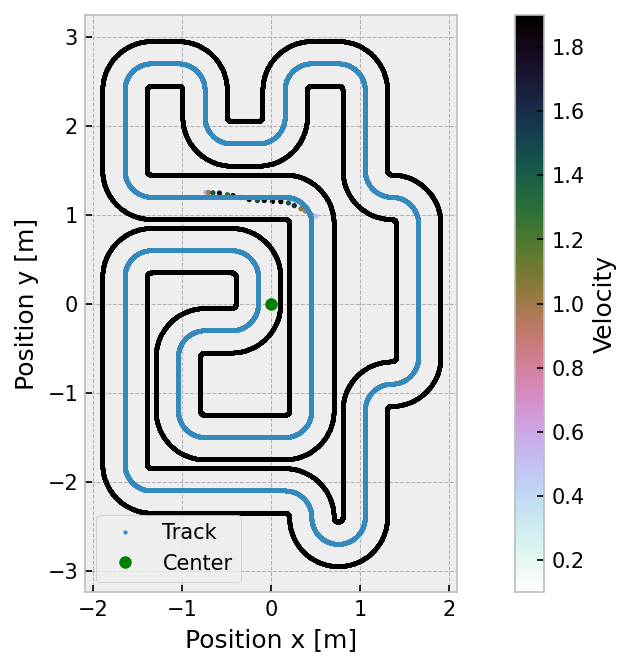

In [23]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,4].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()